In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.Random_Forest import RandomForest_creator
from library.Extra_Trees import ExtraTrees_creator
from library.Neural_Network import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, vif, \
    correlation_plot, rank_importance

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

Using cpu device.


'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### load hyperparameters from all the base learners

In [2]:
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for j in range(num_set) :
        
        model_dict = {}
        for i, model in enumerate(model_list) :

            with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
                temp_dict = pickle.load(f)
                model_dict[model] = temp_dict[f'set{j}']
                
        allset_dict[f'set{j}'] = model_dict
        
    return allset_dict

### transform data by base learner

In [3]:
def transform_train(train_data, mode, base_param, cv):
    
    set_name = list(base_param.keys())
    num_set = len(set_name)
    model_list = list(base_param[set_name[0]].keys())
    set_dict = {}
    for i in tqdm(range(num_set)):
        
        print(f'Dataset {i}:\n')
        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[f'set{i}'], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = pd.DataFrame()
            if mode == 'C':
                
                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                    temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param[f'set{i}']['NeuralNetwork']['batch_size'], 
                                              shuffle = True)
                    valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param[f'set{i}']['NeuralNetwork']['learning_rate'], 
                                                 weight_decay = base_param[f'set{i}']['NeuralNetwork']['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param[f'set{i}']['NeuralNetwork']['bad_weight'], 
                                               base_param[f'set{i}']['NeuralNetwork']['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 200, 
                                              filename = 'none', early_stop = 10)
                    for x, y in valid_loader:
                        output = network(x)
                        _, predict_y = torch.max(output.data, 1)
                    predict = pd.DataFrame({'N': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param[f'set{i}']['LightGBM'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[f'set{i}']['CatBoost'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[f'set{i}']['RandomForest'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[f'set{i}']['ExtraTrees'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[f'set{i}']['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[f'set{i}']['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[f'set{i}']['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[f'set{i}']['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[f'set{i}'] = all_cv
    
    return set_dict


def transform_test(train_data, test_data, mode, base_param):
    
    set_name = list(base_param.keys())
    num_set = len(set_name)
    model_list = list(base_param[set_name[0]].keys())
    test_dict = {}
    for i in tqdm(range(num_set)):
        
        print(f'Dataset {i}:\n')
        train_x, train_y, test_x, test_y = label_divide(train_data[f'set{i}'], test_data, train_only = False)
        model_predict = pd.DataFrame()
        if mode == 'C':

            if 'NeuralNetwork' in model_list:
                temp_train = RunhistSet(train_x, train_y)
                temp_test = RunhistSet(test_x, test_y)
                train_loader = DataLoader(temp_train, 
                                          batch_size = base_param[f'set{i}']['NeuralNetwork']['batch_size'], 
                                          shuffle = True)
                test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                nn_model = NeuralNetworkC(dim = train_x.shape[1])
                optimizer = torch.optim.Adam(nn_model.parameters(), 
                                             lr = base_param[f'set{i}']['NeuralNetwork']['learning_rate'], 
                                             weight_decay = base_param[f'set{i}']['NeuralNetwork']['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-base_param[f'set{i}']['NeuralNetwork']['bad_weight'], 
                                           base_param[f'set{i}']['NeuralNetwork']['bad_weight']])).to('cpu')
                network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 200, 
                                          filename = 'none', early_stop = 20)
                for X, Y in test_loader:
                    X, Y = X.float(), Y.long()
                    output = network(X)
                    _, predict_y = torch.max(output.data, 1)
                predict = pd.DataFrame({'N': predict_y.numpy()})
                model_predict = pd.concat([model_predict, predict], axis = 1)
            
            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param[f'set{i}']['LightGBM'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param[f'set{i}']['CatBoost'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param[f'set{i}']['RandomForest'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param[f'set{i}']['ExtraTrees'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[f'set{i}']['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[f'set{i}']['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[f'set{i}']['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[f'set{i}']['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[f'set{i}'] = model_done
        
    return test_dict

## 

### loading training data & testing data & hyperparameters generating from previous files

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 85)  balance ratio: 590.0
Dimension of dataset 1 : (1296, 85)  balance ratio: 1.0
Dimension of dataset 2 : (2034, 85)  balance ratio: 1.0
Dimension of dataset 3 : (1448, 85)  balance ratio: 1.0
Dimension of dataset 4 : (1320, 85)  balance ratio: 1.0
Dimension of dataset 5 : (1310, 85)  balance ratio: 1.0
Dimension of dataset 6 : (1326, 85)  balance ratio: 1.0
Dimension of dataset 7 : (1320, 85)  balance ratio: 1.0
Dimension of dataset 8 : (1320, 85)  balance ratio: 1.0
Dimension of dataset 9 : (726, 85)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 101)  balance ratio: 574.0
Dimension of dataset 1 : (2088, 101)  balance ratio: 1.0
Dimension of dataset 2 : (2568, 101)  balance ratio: 1.0
Dimension of dataset 3 : (2306, 101)  balance ratio: 1.0
Dimension of dataset 4 : (2100, 101)  balance ratio: 1.0
Dimension of dataset 5 : (2101, 101)  balance ratio: 1.0
Dimensi

## base learner

In [6]:
##### loading hyperparameters #####
hyper_info = {
    'num_set': 10,
    'date': '20211207',
    'model_list': ['NeuralNetwork', 'LightGBM', 'XGBoost', 'CatBoost'],
    'iter_list': [20, 200, 200, 200],
    'filename': 'runhist_array_m2m4_m5_3criteria',
    'TPE_multi': True
}

base_paramC = load_hyper(**hyper_info, mode = 'C')
# base_paramR = load_hyper(**hyper_info, mode = 'R')

### data transform for scheme 1

In [7]:
train_firstC = transform_train(run_train, mode = 'C', base_param = base_paramC, cv = 5)
test_firstC = transform_test(run_train, run_test, mode = 'C', base_param = base_paramC)
train_firstC_x, train_firstC_y = train_set(train_firstC, num_set = 10)
test_firstC_x, test_firstC_y = train_set(test_firstC, num_set = 10) 

# train_firstR = transform_train(run_train, mode = 'R', base_param = base_paramR, cv = 5)
# test_firstR = transform_test(run_train, run_test, mode = 'R', base_param = base_paramR)
# train_firstR_x, train_firstR_y = train_set(train_firstR, num_set = 10)
# test_firstR_x, test_firstR_y = train_set(test_firstR, num_set = 10) 

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.04646367132580165, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 2: Train Loss = 0.026371365379935726, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.025998948904575585, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.02574090714588478, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.02561247758854133, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.02484152645598291, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.02493106199320379, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.024813566596289607, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.024617174215434145, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.024418953684134097, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 10: Train Loss = 0.02435149342424501

Epoch 57: Train Loss = 0.015437237418901956, Recall = 0.10666666666666667, Aging Rate = 0.0002068104264271908, Precision = 0.9230769230769231, f1 = 0.1912350597609562
Epoch 58: Train Loss = 0.015308832194748911, Recall = 0.09333333333333334, Aging Rate = 0.00017499343774608452, Precision = 0.9545454545454546, f1 = 0.17004048582995954
Epoch 59: Train Loss = 0.015237203443053685, Recall = 0.11555555555555555, Aging Rate = 0.0002306731679380205, Precision = 0.896551724137931, f1 = 0.20472440944881887
Epoch 60: Train Loss = 0.015188263652479212, Recall = 0.08, Aging Rate = 0.0001511306962352548, Precision = 0.9473684210526315, f1 = 0.14754098360655737
Test Loss = 0.014670003718773066, Recall = 0.14666666666666667, Aging Rate = 0.00027839865095967994, precision = 0.9428571428571428

Epoch 61: Train Loss = 0.015071493865271925, Recall = 0.10666666666666667, Aging Rate = 0.0002068104264271908, Precision = 0.9230769230769231, f1 = 0.1912350597609562
Epoch 62: Train Loss = 0.014978131337814877,

Test Loss = 0.012366532695502381, Recall = 0.21777777777777776, Aging Rate = 0.00042157510002465814, precision = 0.9245283018867925

Epoch 101: Train Loss = 0.01278073056754481, Recall = 0.19111111111111112, Aging Rate = 0.00037384961700299876, Precision = 0.9148936170212766, f1 = 0.31617647058823534
Epoch 102: Train Loss = 0.012844566972925296, Recall = 0.18666666666666668, Aging Rate = 0.0003658953698327222, Precision = 0.9130434782608695, f1 = 0.30996309963099633
Epoch 103: Train Loss = 0.012772072722204889, Recall = 0.18222222222222223, Aging Rate = 0.00034998687549216904, Precision = 0.9318181818181818, f1 = 0.3048327137546469
Epoch 104: Train Loss = 0.012753700924832908, Recall = 0.2088888888888889, Aging Rate = 0.0003977123585138285, Precision = 0.94, f1 = 0.34181818181818185
Epoch 105: Train Loss = 0.012698691198453049, Recall = 0.20444444444444446, Aging Rate = 0.00038975811134355187, Precision = 0.9387755102040817, f1 = 0.3357664233576642
Test Loss = 0.012241478534598267, Rec

Epoch 144: Train Loss = 0.011694915279289236, Recall = 0.21333333333333335, Aging Rate = 0.00040566660568410503, Precision = 0.9411764705882353, f1 = 0.3478260869565218
Epoch 145: Train Loss = 0.011637148617884755, Recall = 0.2311111111111111, Aging Rate = 0.000461346335876041, Precision = 0.896551724137931, f1 = 0.3674911660777385
Test Loss = 0.011203329900204392, Recall = 0.22666666666666666, Aging Rate = 0.00042157510002465814, precision = 0.9622641509433962

Epoch 146: Train Loss = 0.01161814906474319, Recall = 0.2088888888888889, Aging Rate = 0.0004374835943652113, Precision = 0.8545454545454545, f1 = 0.33571428571428574
Epoch 147: Train Loss = 0.011642360567699373, Recall = 0.2222222222222222, Aging Rate = 0.0004374835943652113, Precision = 0.9090909090909091, f1 = 0.3571428571428571
Epoch 148: Train Loss = 0.01156404291778674, Recall = 0.22666666666666666, Aging Rate = 0.00048520907738687074, Precision = 0.8360655737704918, f1 = 0.35664335664335667
Epoch 149: Train Loss = 0.0115

Epoch 187: Train Loss = 0.01102257838453478, Recall = 0.24888888888888888, Aging Rate = 0.00048520907738687074, Precision = 0.9180327868852459, f1 = 0.3916083916083916
Epoch 188: Train Loss = 0.011012391246569471, Recall = 0.24888888888888888, Aging Rate = 0.000517026066067977, Precision = 0.8615384615384616, f1 = 0.3862068965517241
Epoch 189: Train Loss = 0.010993147218909762, Recall = 0.25333333333333335, Aging Rate = 0.0005090718188977005, Precision = 0.890625, f1 = 0.3944636678200692
Epoch 190: Train Loss = 0.010944312849787077, Recall = 0.24444444444444444, Aging Rate = 0.0005090718188977005, Precision = 0.859375, f1 = 0.3806228373702422
Test Loss = 0.010596175292552955, Recall = 0.22666666666666666, Aging Rate = 0.00042157510002465814, precision = 0.9622641509433962

Epoch 191: Train Loss = 0.010977269153898468, Recall = 0.24, Aging Rate = 0.00047725483021659413, Precision = 0.9, f1 = 0.3789473684210526
Epoch 192: Train Loss = 0.010923089614602087, Recall = 0.26666666666666666, A

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2820816	total: 188ms	remaining: 56.4s
1:	learn: 0.1242346	total: 225ms	remaining: 33.5s
2:	learn: 0.0629337	total: 241ms	remaining: 23.8s
3:	learn: 0.0369198	total: 256ms	remaining: 18.9s
4:	learn: 0.0256879	total: 268ms	remaining: 15.8s
5:	learn: 0.0198007	total: 287ms	remaining: 14.1s
6:	learn: 0.0166165	total: 333ms	remaining: 13.9s
7:	learn: 0.0149295	total: 348ms	remaining: 12.7s
8:	learn: 0.0138924	total: 364ms	remaining: 11.8s
9:	learn: 0.0132100	total: 379ms	remaining: 11s
10:	learn: 0.0127911	total: 426ms	remaining: 11.2s
11:	learn: 0.0125379	total: 458ms	remaining: 11s
12:	learn: 0.0121141	total: 490ms	remaining: 10.8s
13:	learn: 0.0118797	total: 505ms	remaining: 10.3s
14:	learn: 0.0117621	total: 519ms	remaining: 9.87s
15:	learn: 0.0116817	total: 535ms	remaining: 9.5s
16:	learn: 0.0116321	total: 549ms	remaining: 9.14s
17:	learn: 0.0115484	total: 566ms	remaining: 8.87s
18:	learn: 0.0113475	total: 598ms	remaining: 8.84s
19:	learn: 0.0113231	total: 628ms	remaining: 8

164:	learn: 0.0021998	total: 3.72s	remaining: 3.04s
165:	learn: 0.0021773	total: 3.73s	remaining: 3.01s
166:	learn: 0.0021306	total: 3.75s	remaining: 2.98s
167:	learn: 0.0021001	total: 3.76s	remaining: 2.96s
168:	learn: 0.0020818	total: 3.77s	remaining: 2.93s
169:	learn: 0.0020572	total: 3.81s	remaining: 2.91s
170:	learn: 0.0020350	total: 3.83s	remaining: 2.88s
171:	learn: 0.0020225	total: 3.84s	remaining: 2.86s
172:	learn: 0.0019973	total: 3.86s	remaining: 2.83s
173:	learn: 0.0019828	total: 3.87s	remaining: 2.8s
174:	learn: 0.0019669	total: 3.9s	remaining: 2.79s
175:	learn: 0.0019333	total: 3.93s	remaining: 2.77s
176:	learn: 0.0019110	total: 3.95s	remaining: 2.75s
177:	learn: 0.0018855	total: 3.97s	remaining: 2.72s
178:	learn: 0.0018572	total: 3.98s	remaining: 2.69s
179:	learn: 0.0018430	total: 4s	remaining: 2.66s
180:	learn: 0.0018231	total: 4.03s	remaining: 2.65s
181:	learn: 0.0018062	total: 4.04s	remaining: 2.62s
182:	learn: 0.0017954	total: 4.06s	remaining: 2.59s
183:	learn: 0.001

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.048072092554542235, Recall = 0.0, Aging Rate = 0.00025453590944885023, Precision = 0.0, f1 = 0
Epoch 2: Train Loss = 0.026509255478812197, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.026074112720549818, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.025882904874943834, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.025312221079349103, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.025024240382199955, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.02487055153453901, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.024713346811578454, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.024484671264369068, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.02435644420053775, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 10: Train Lo

Epoch 52: Train Loss = 0.015781138946781362, Recall = 0.09333333333333334, Aging Rate = 0.00019885617925691424, Precision = 0.84, f1 = 0.16799999999999998
Epoch 53: Train Loss = 0.015681522390257774, Recall = 0.1111111111111111, Aging Rate = 0.00022271892076774393, Precision = 0.8928571428571429, f1 = 0.1976284584980237
Epoch 54: Train Loss = 0.015603284296353132, Recall = 0.09777777777777778, Aging Rate = 0.00019885617925691424, Precision = 0.88, f1 = 0.17600000000000002
Epoch 55: Train Loss = 0.015487800870340638, Recall = 0.08888888888888889, Aging Rate = 0.00019090193208663766, Precision = 0.8333333333333334, f1 = 0.1606425702811245
Test Loss = 0.015024424972469667, Recall = 0.15555555555555556, Aging Rate = 0.0003102156396407862, precision = 0.8974358974358975
Model in epoch 55 is saved.

Epoch 56: Train Loss = 0.015384356037051707, Recall = 0.12, Aging Rate = 0.0002306731679380205, Precision = 0.9310344827586207, f1 = 0.21259842519685038
Epoch 57: Train Loss = 0.01531140554043953

Epoch 95: Train Loss = 0.0130325292886093, Recall = 0.2, Aging Rate = 0.00044543784153548786, Precision = 0.8035714285714286, f1 = 0.3202846975088968
Test Loss = 0.012556866623902258, Recall = 0.19111111111111112, Aging Rate = 0.0003579411226624456, precision = 0.9555555555555556
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.01301221681580985, Recall = 0.1688888888888889, Aging Rate = 0.0003340783811516159, Precision = 0.9047619047619048, f1 = 0.2846441947565543
Epoch 97: Train Loss = 0.01295042423931325, Recall = 0.1688888888888889, Aging Rate = 0.0003261241339813393, Precision = 0.926829268292683, f1 = 0.2857142857142857
Epoch 98: Train Loss = 0.012939322548015265, Recall = 0.20444444444444446, Aging Rate = 0.0004136208528543816, Precision = 0.8846153846153846, f1 = 0.33212996389891697
Epoch 99: Train Loss = 0.01282267347941446, Recall = 0.19111111111111112, Aging Rate = 0.00040566660568410503, Precision = 0.8431372549019608, f1 = 0.3115942028985507
Epoch 100: Train Loss = 0.

Epoch 138: Train Loss = 0.011705110164604437, Recall = 0.21333333333333335, Aging Rate = 0.00042952934719493475, Precision = 0.8888888888888888, f1 = 0.3440860215053763
Epoch 139: Train Loss = 0.011763558471635606, Recall = 0.21333333333333335, Aging Rate = 0.0004374835943652113, Precision = 0.8727272727272727, f1 = 0.3428571428571429
Epoch 140: Train Loss = 0.011669582209178313, Recall = 0.22666666666666666, Aging Rate = 0.00044543784153548786, Precision = 0.9107142857142857, f1 = 0.3629893238434163
Test Loss = 0.011292481863388174, Recall = 0.20444444444444446, Aging Rate = 0.0004136208528543816, precision = 0.8846153846153846

Epoch 141: Train Loss = 0.011710669862303184, Recall = 0.18666666666666668, Aging Rate = 0.0003977123585138285, Precision = 0.84, f1 = 0.3054545454545455
Epoch 142: Train Loss = 0.011640258572384557, Recall = 0.2088888888888889, Aging Rate = 0.00044543784153548786, Precision = 0.8392857142857143, f1 = 0.33451957295373674
Epoch 143: Train Loss = 0.0116163954557

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2804185	total: 39ms	remaining: 11.7s
1:	learn: 0.1236108	total: 54.4ms	remaining: 8.11s
2:	learn: 0.0628516	total: 86.5ms	remaining: 8.56s
3:	learn: 0.0374246	total: 102ms	remaining: 7.56s
4:	learn: 0.0258539	total: 117ms	remaining: 6.91s
5:	learn: 0.0199787	total: 149ms	remaining: 7.29s
6:	learn: 0.0167509	total: 165ms	remaining: 6.9s
7:	learn: 0.0149631	total: 195ms	remaining: 7.12s
8:	learn: 0.0139457	total: 209ms	remaining: 6.77s
9:	learn: 0.0130903	total: 225ms	remaining: 6.54s
10:	learn: 0.0126339	total: 239ms	remaining: 6.28s
11:	learn: 0.0123684	total: 255ms	remaining: 6.13s
12:	learn: 0.0120632	total: 288ms	remaining: 6.35s
13:	learn: 0.0117410	total: 319ms	remaining: 6.52s
14:	learn: 0.0115875	total: 348ms	remaining: 6.62s
15:	learn: 0.0114926	total: 365ms	remaining: 6.48s
16:	learn: 0.0114390	total: 397ms	remaining: 6.6s
17:	learn: 0.0113957	total: 413ms	remaining: 6.46s
18:	learn: 0.0112900	total: 428ms	remaining: 6.33s
19:	learn: 0.0111963	total: 460ms	remainin

164:	learn: 0.0022812	total: 3.69s	remaining: 3.02s
165:	learn: 0.0022546	total: 3.71s	remaining: 2.99s
166:	learn: 0.0022149	total: 3.72s	remaining: 2.96s
167:	learn: 0.0021843	total: 3.74s	remaining: 2.94s
168:	learn: 0.0021588	total: 3.77s	remaining: 2.92s
169:	learn: 0.0021218	total: 3.8s	remaining: 2.91s
170:	learn: 0.0020989	total: 3.83s	remaining: 2.89s
171:	learn: 0.0020784	total: 3.85s	remaining: 2.86s
172:	learn: 0.0020254	total: 3.86s	remaining: 2.84s
173:	learn: 0.0019874	total: 3.9s	remaining: 2.82s
174:	learn: 0.0019564	total: 3.91s	remaining: 2.79s
175:	learn: 0.0019260	total: 3.93s	remaining: 2.77s
176:	learn: 0.0019028	total: 3.96s	remaining: 2.75s
177:	learn: 0.0018756	total: 3.98s	remaining: 2.73s
178:	learn: 0.0018539	total: 3.99s	remaining: 2.7s
179:	learn: 0.0018411	total: 4.01s	remaining: 2.67s
180:	learn: 0.0018158	total: 4.02s	remaining: 2.64s
181:	learn: 0.0017998	total: 4.04s	remaining: 2.62s
182:	learn: 0.0017862	total: 4.07s	remaining: 2.6s
183:	learn: 0.00

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.05735931596081712, Recall = 0.0, Aging Rate = 0.005218027649183092, Precision = 0.0, f1 = 0
Epoch 2: Train Loss = 0.026783882615337123, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.02630024416806646, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.02588054063438525, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.025812737786256604, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.024846224509417154, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.024977033900200844, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.024725997853025213, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.02453850627783981, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.02424697982053906, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 10: Train Loss = 

Epoch 56: Train Loss = 0.0153301277052263, Recall = 0.08888888888888889, Aging Rate = 0.00018294914013904133, Precision = 0.8695652173913043, f1 = 0.16129032258064516
Epoch 57: Train Loss = 0.015260354270426366, Recall = 0.09333333333333334, Aging Rate = 0.00018294914013904133, Precision = 0.9130434782608695, f1 = 0.16935483870967744
Epoch 58: Train Loss = 0.015102037653464719, Recall = 0.07555555555555556, Aging Rate = 0.0001590862088165577, Precision = 0.85, f1 = 0.13877551020408163
Epoch 59: Train Loss = 0.015070825092132738, Recall = 0.09333333333333334, Aging Rate = 0.00019090345057986923, Precision = 0.875, f1 = 0.1686746987951807
Epoch 60: Train Loss = 0.014907975156333944, Recall = 0.09333333333333334, Aging Rate = 0.00019885776102069713, Precision = 0.84, f1 = 0.16799999999999998
Test Loss = 0.014540771823328413, Recall = 0.1288888888888889, Aging Rate = 0.0002624922445473202, precision = 0.8787878787878788

Epoch 61: Train Loss = 0.014823377797078938, Recall = 0.1066666666666

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2812295	total: 23.1ms	remaining: 6.9s
1:	learn: 0.1237327	total: 37.3ms	remaining: 5.56s
2:	learn: 0.0624066	total: 52.8ms	remaining: 5.23s
3:	learn: 0.0372676	total: 67ms	remaining: 4.96s
4:	learn: 0.0253510	total: 98.9ms	remaining: 5.83s
5:	learn: 0.0195684	total: 115ms	remaining: 5.66s
6:	learn: 0.0166187	total: 130ms	remaining: 5.45s
7:	learn: 0.0147675	total: 147ms	remaining: 5.35s
8:	learn: 0.0136082	total: 176ms	remaining: 5.69s
9:	learn: 0.0129875	total: 191ms	remaining: 5.54s
10:	learn: 0.0125588	total: 206ms	remaining: 5.42s
11:	learn: 0.0122636	total: 239ms	remaining: 5.74s
12:	learn: 0.0121187	total: 254ms	remaining: 5.62s
13:	learn: 0.0119306	total: 286ms	remaining: 5.85s
14:	learn: 0.0118166	total: 302ms	remaining: 5.74s
15:	learn: 0.0116999	total: 318ms	remaining: 5.64s
16:	learn: 0.0115993	total: 334ms	remaining: 5.56s
17:	learn: 0.0115505	total: 348ms	remaining: 5.46s
18:	learn: 0.0114607	total: 365ms	remaining: 5.4s
19:	learn: 0.0113749	total: 380ms	remain

163:	learn: 0.0020977	total: 3.19s	remaining: 2.65s
164:	learn: 0.0020792	total: 3.2s	remaining: 2.62s
165:	learn: 0.0020497	total: 3.22s	remaining: 2.6s
166:	learn: 0.0020179	total: 3.23s	remaining: 2.58s
167:	learn: 0.0019872	total: 3.25s	remaining: 2.55s
168:	learn: 0.0019626	total: 3.28s	remaining: 2.54s
169:	learn: 0.0019103	total: 3.31s	remaining: 2.53s
170:	learn: 0.0018620	total: 3.33s	remaining: 2.51s
171:	learn: 0.0018166	total: 3.34s	remaining: 2.49s
172:	learn: 0.0017912	total: 3.36s	remaining: 2.47s
173:	learn: 0.0017662	total: 3.39s	remaining: 2.46s
174:	learn: 0.0017516	total: 3.42s	remaining: 2.44s
175:	learn: 0.0017116	total: 3.44s	remaining: 2.42s
176:	learn: 0.0016878	total: 3.45s	remaining: 2.4s
177:	learn: 0.0016557	total: 3.47s	remaining: 2.38s
178:	learn: 0.0016232	total: 3.5s	remaining: 2.37s
179:	learn: 0.0016089	total: 3.52s	remaining: 2.35s
180:	learn: 0.0015714	total: 3.55s	remaining: 2.33s
181:	learn: 0.0015596	total: 3.58s	remaining: 2.32s
182:	learn: 0.00

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.05408094227677801, Recall = 0.0044444444444444444, Aging Rate = 0.0011533658396901026, Precision = 0.006896551724137931, f1 = 0.005405405405405405
Epoch 2: Train Loss = 0.026632566065355374, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.026096953775561014, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.026016514865203018, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.025642839855722327, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.02483594966640013, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.024977231951433507, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.024806601688240348, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.024617360569076208, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.024450506414581297, Recall = 0.0, Aging

Epoch 60: Train Loss = 0.014655811037544115, Recall = 0.06666666666666667, Aging Rate = 0.00015908494340553139, Precision = 0.75, f1 = 0.12244897959183675
Test Loss = 0.014309140060925471, Recall = 0.022222222222222223, Aging Rate = 3.9771235851382846e-05, precision = 1.0
Model in epoch 60 is saved.

Epoch 61: Train Loss = 0.014599728448362192, Recall = 0.08, Aging Rate = 0.00019090193208663766, Precision = 0.75, f1 = 0.14457831325301204
Epoch 62: Train Loss = 0.014504374558348038, Recall = 0.08888888888888889, Aging Rate = 0.00019090193208663766, Precision = 0.8333333333333334, f1 = 0.1606425702811245
Epoch 63: Train Loss = 0.014416283403218036, Recall = 0.09777777777777778, Aging Rate = 0.0002068104264271908, Precision = 0.8461538461538461, f1 = 0.17529880478087653
Epoch 64: Train Loss = 0.014326250400174304, Recall = 0.08444444444444445, Aging Rate = 0.0002068104264271908, Precision = 0.7307692307692307, f1 = 0.15139442231075698
Epoch 65: Train Loss = 0.014247262862949183, Recall = 

Epoch 103: Train Loss = 0.012019862619172011, Recall = 0.18666666666666668, Aging Rate = 0.0003658953698327222, Precision = 0.9130434782608695, f1 = 0.30996309963099633
Epoch 104: Train Loss = 0.01198782114837937, Recall = 0.15555555555555556, Aging Rate = 0.0003579411226624456, Precision = 0.7777777777777778, f1 = 0.25925925925925924
Epoch 105: Train Loss = 0.011954049223801772, Recall = 0.17333333333333334, Aging Rate = 0.00037384961700299876, Precision = 0.8297872340425532, f1 = 0.2867647058823529
Test Loss = 0.011412451805417114, Recall = 0.2311111111111111, Aging Rate = 0.0004931633245571472, precision = 0.8387096774193549

Epoch 106: Train Loss = 0.01187890089607776, Recall = 0.17777777777777778, Aging Rate = 0.00042157510002465814, Precision = 0.7547169811320755, f1 = 0.28776978417266186
Epoch 107: Train Loss = 0.01187920934844731, Recall = 0.17777777777777778, Aging Rate = 0.00037384961700299876, Precision = 0.851063829787234, f1 = 0.29411764705882354
Epoch 108: Train Loss = 0.

Epoch 146: Train Loss = 0.010952631067816939, Recall = 0.20444444444444446, Aging Rate = 0.00042952934719493475, Precision = 0.8518518518518519, f1 = 0.32974910394265233
Epoch 147: Train Loss = 0.010885160326937508, Recall = 0.21333333333333335, Aging Rate = 0.00044543784153548786, Precision = 0.8571428571428571, f1 = 0.3416370106761566
Epoch 148: Train Loss = 0.010890424769016062, Recall = 0.2088888888888889, Aging Rate = 0.0004374835943652113, Precision = 0.8545454545454545, f1 = 0.33571428571428574
Epoch 149: Train Loss = 0.010860939988378886, Recall = 0.18666666666666668, Aging Rate = 0.0003977123585138285, Precision = 0.84, f1 = 0.3054545454545455
Epoch 150: Train Loss = 0.010858214081266018, Recall = 0.21777777777777776, Aging Rate = 0.00042952934719493475, Precision = 0.9074074074074074, f1 = 0.35125448028673834
Test Loss = 0.010436323147753895, Recall = 0.19111111111111112, Aging Rate = 0.00037384961700299876, precision = 0.9148936170212766

Epoch 151: Train Loss = 0.0109138044

Epoch 190: Train Loss = 0.010451102189196437, Recall = 0.20444444444444446, Aging Rate = 0.0004693005830463176, Precision = 0.7796610169491526, f1 = 0.323943661971831
Test Loss = 0.010043635447287681, Recall = 0.3111111111111111, Aging Rate = 0.000684065256643785, precision = 0.813953488372093

Epoch 191: Train Loss = 0.010410592411698723, Recall = 0.2222222222222222, Aging Rate = 0.000461346335876041, Precision = 0.8620689655172413, f1 = 0.35335689045936397
Epoch 192: Train Loss = 0.01040420202056416, Recall = 0.21333333333333335, Aging Rate = 0.00047725483021659413, Precision = 0.8, f1 = 0.3368421052631579
Epoch 193: Train Loss = 0.010365432351353067, Recall = 0.21777777777777776, Aging Rate = 0.00048520907738687074, Precision = 0.8032786885245902, f1 = 0.3426573426573426
Epoch 194: Train Loss = 0.010369718630211132, Recall = 0.23555555555555555, Aging Rate = 0.000517026066067977, Precision = 0.8153846153846154, f1 = 0.36551724137931035
Epoch 195: Train Loss = 0.01038433976774425, Re

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2839703	total: 29.2ms	remaining: 8.73s
1:	learn: 0.1253167	total: 59.1ms	remaining: 8.8s
2:	learn: 0.0635610	total: 89.5ms	remaining: 8.86s
3:	learn: 0.0374853	total: 106ms	remaining: 7.82s
4:	learn: 0.0257752	total: 137ms	remaining: 8.1s
5:	learn: 0.0197062	total: 153ms	remaining: 7.51s
6:	learn: 0.0164905	total: 168ms	remaining: 7.02s
7:	learn: 0.0150808	total: 213ms	remaining: 7.76s
8:	learn: 0.0140792	total: 244ms	remaining: 7.88s
9:	learn: 0.0133380	total: 262ms	remaining: 7.6s
10:	learn: 0.0127018	total: 294ms	remaining: 7.71s
11:	learn: 0.0124006	total: 309ms	remaining: 7.42s
12:	learn: 0.0121845	total: 325ms	remaining: 7.17s
13:	learn: 0.0120232	total: 341ms	remaining: 6.96s
14:	learn: 0.0119284	total: 357ms	remaining: 6.79s
15:	learn: 0.0118438	total: 373ms	remaining: 6.62s
16:	learn: 0.0116231	total: 404ms	remaining: 6.73s
17:	learn: 0.0115415	total: 420ms	remaining: 6.58s
18:	learn: 0.0114586	total: 451ms	remaining: 6.67s
19:	learn: 0.0114029	total: 467ms	remaini

163:	learn: 0.0021821	total: 3.61s	remaining: 2.99s
164:	learn: 0.0021510	total: 3.63s	remaining: 2.97s
165:	learn: 0.0021409	total: 3.65s	remaining: 2.95s
166:	learn: 0.0021223	total: 3.68s	remaining: 2.93s
167:	learn: 0.0020887	total: 3.69s	remaining: 2.9s
168:	learn: 0.0020617	total: 3.73s	remaining: 2.89s
169:	learn: 0.0020335	total: 3.74s	remaining: 2.86s
170:	learn: 0.0020022	total: 3.78s	remaining: 2.85s
171:	learn: 0.0019801	total: 3.79s	remaining: 2.82s
172:	learn: 0.0019555	total: 3.82s	remaining: 2.81s
173:	learn: 0.0019321	total: 3.83s	remaining: 2.77s
174:	learn: 0.0019047	total: 3.87s	remaining: 2.76s
175:	learn: 0.0018850	total: 3.9s	remaining: 2.75s
176:	learn: 0.0018648	total: 3.95s	remaining: 2.74s
177:	learn: 0.0018482	total: 3.96s	remaining: 2.71s
178:	learn: 0.0018300	total: 3.99s	remaining: 2.7s
179:	learn: 0.0018152	total: 4.01s	remaining: 2.67s
180:	learn: 0.0017948	total: 4.04s	remaining: 2.66s
181:	learn: 0.0017737	total: 4.06s	remaining: 2.63s
182:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.05912794780659286, Recall = 0.0, Aging Rate = 0.00794641933867337, Precision = 0.0, f1 = 0
Epoch 2: Train Loss = 0.02606626348471758, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.025818084012809314, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.025416218106980037, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.024974245542521423, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.02416044616606016, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.02421694114867592, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.02395635609382903, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.023701484058540435, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.023451304533036694, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 10: Train Loss = 0

Epoch 55: Train Loss = 0.012491934153844952, Recall = 0.14285714285714285, Aging Rate = 0.0002863574536458872, Precision = 0.8888888888888888, f1 = 0.24615384615384617
Test Loss = 0.011917577635753056, Recall = 0.16071428571428573, Aging Rate = 0.00029431182735827294, precision = 0.972972972972973
Model in epoch 55 is saved.

Epoch 56: Train Loss = 0.012373243741309834, Recall = 0.15178571428571427, Aging Rate = 0.00029431182735827294, Precision = 0.918918918918919, f1 = 0.26053639846743293
Epoch 57: Train Loss = 0.01221987146169241, Recall = 0.16071428571428573, Aging Rate = 0.00031022057478304445, Precision = 0.9230769230769231, f1 = 0.2737642585551331
Epoch 58: Train Loss = 0.012135680465232331, Recall = 0.16517857142857142, Aging Rate = 0.0003022662010706587, Precision = 0.9736842105263158, f1 = 0.282442748091603
Epoch 59: Train Loss = 0.012077553303143782, Recall = 0.1875, Aging Rate = 0.00036590119076974475, Precision = 0.9130434782608695, f1 = 0.31111111111111106
Epoch 60: Train

Epoch 98: Train Loss = 0.009584226161488517, Recall = 0.33035714285714285, Aging Rate = 0.0006443042707032462, Precision = 0.9135802469135802, f1 = 0.4852459016393442
Epoch 99: Train Loss = 0.00953113489748823, Recall = 0.3080357142857143, Aging Rate = 0.0005886236547165459, Precision = 0.9324324324324325, f1 = 0.46308724832214765
Epoch 100: Train Loss = 0.009531047144050713, Recall = 0.36607142857142855, Aging Rate = 0.0007238480078271037, Precision = 0.9010989010989011, f1 = 0.5206349206349207
Test Loss = 0.009008672443680223, Recall = 0.33035714285714285, Aging Rate = 0.0006204411495660889, precision = 0.9487179487179487
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.009510537913717396, Recall = 0.33482142857142855, Aging Rate = 0.0006522586444156319, Precision = 0.9146341463414634, f1 = 0.49019607843137253
Epoch 102: Train Loss = 0.009431409684245768, Recall = 0.33482142857142855, Aging Rate = 0.0006761217655527893, Precision = 0.8823529411764706, f1 = 0.4854368932038834
E

Epoch 141: Train Loss = 0.008540758650503424, Recall = 0.38839285714285715, Aging Rate = 0.000779528623813804, Precision = 0.8877551020408163, f1 = 0.5403726708074534
Epoch 142: Train Loss = 0.008594557212230482, Recall = 0.3392857142857143, Aging Rate = 0.0006761217655527893, Precision = 0.8941176470588236, f1 = 0.49190938511326865
Epoch 143: Train Loss = 0.008547793275407894, Recall = 0.3705357142857143, Aging Rate = 0.0007397567552518752, Precision = 0.8924731182795699, f1 = 0.5236593059936909
Epoch 144: Train Loss = 0.008464068901238202, Recall = 0.38839285714285715, Aging Rate = 0.0007636198763890325, Precision = 0.90625, f1 = 0.54375
Epoch 145: Train Loss = 0.008568969421440102, Recall = 0.3705357142857143, Aging Rate = 0.0007238480078271037, Precision = 0.9120879120879121, f1 = 0.526984126984127
Test Loss = 0.008002190474981805, Recall = 0.41517857142857145, Aging Rate = 0.0008272548660881186, precision = 0.8942307692307693

Epoch 146: Train Loss = 0.00846070763248914, Recall = 

Epoch 185: Train Loss = 0.008069485309416171, Recall = 0.4017857142857143, Aging Rate = 0.0008113461186633471, Precision = 0.8823529411764706, f1 = 0.5521472392638037
Test Loss = 0.0076171051106081085, Recall = 0.40625, Aging Rate = 0.0008113461186633471, precision = 0.8921568627450981

Epoch 186: Train Loss = 0.008071320387155688, Recall = 0.39732142857142855, Aging Rate = 0.0007715742501014182, Precision = 0.9175257731958762, f1 = 0.5545171339563864
Epoch 187: Train Loss = 0.008052792052719412, Recall = 0.40625, Aging Rate = 0.0007954373712385755, Precision = 0.91, f1 = 0.5617283950617283
Epoch 188: Train Loss = 0.007976660046219115, Recall = 0.4419642857142857, Aging Rate = 0.0008829354820748188, Precision = 0.8918918918918919, f1 = 0.591044776119403
Epoch 189: Train Loss = 0.008043180766308904, Recall = 0.40625, Aging Rate = 0.0008033917449509612, Precision = 0.900990099009901, f1 = 0.56
Epoch 190: Train Loss = 0.008077019506146546, Recall = 0.41517857142857145, Aging Rate = 0.0008

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2831338	total: 35ms	remaining: 10.5s
1:	learn: 0.1249738	total: 65.2ms	remaining: 9.72s
2:	learn: 0.0636165	total: 97.5ms	remaining: 9.65s
3:	learn: 0.0377362	total: 145ms	remaining: 10.8s
4:	learn: 0.0259190	total: 161ms	remaining: 9.47s
5:	learn: 0.0198104	total: 176ms	remaining: 8.63s
6:	learn: 0.0165347	total: 192ms	remaining: 8.02s
7:	learn: 0.0147917	total: 208ms	remaining: 7.59s
8:	learn: 0.0137893	total: 224ms	remaining: 7.25s
9:	learn: 0.0131079	total: 239ms	remaining: 6.94s
10:	learn: 0.0126421	total: 255ms	remaining: 6.7s
11:	learn: 0.0123834	total: 287ms	remaining: 6.88s
12:	learn: 0.0119085	total: 302ms	remaining: 6.67s
13:	learn: 0.0117345	total: 318ms	remaining: 6.5s
14:	learn: 0.0115478	total: 333ms	remaining: 6.33s
15:	learn: 0.0114726	total: 366ms	remaining: 6.49s
16:	learn: 0.0113157	total: 397ms	remaining: 6.61s
17:	learn: 0.0112164	total: 413ms	remaining: 6.47s
18:	learn: 0.0111799	total: 445ms	remaining: 6.58s
19:	learn: 0.0110930	total: 461ms	remainin

163:	learn: 0.0017540	total: 3.42s	remaining: 2.83s
164:	learn: 0.0017253	total: 3.43s	remaining: 2.81s
165:	learn: 0.0016985	total: 3.45s	remaining: 2.78s
166:	learn: 0.0016758	total: 3.46s	remaining: 2.76s
167:	learn: 0.0016632	total: 3.48s	remaining: 2.73s
168:	learn: 0.0016512	total: 3.51s	remaining: 2.72s
169:	learn: 0.0016340	total: 3.54s	remaining: 2.71s
170:	learn: 0.0016112	total: 3.57s	remaining: 2.69s
171:	learn: 0.0015834	total: 3.59s	remaining: 2.67s
172:	learn: 0.0015562	total: 3.6s	remaining: 2.64s
173:	learn: 0.0015495	total: 3.62s	remaining: 2.62s
174:	learn: 0.0015319	total: 3.63s	remaining: 2.6s
175:	learn: 0.0015150	total: 3.65s	remaining: 2.57s
176:	learn: 0.0014732	total: 3.66s	remaining: 2.55s
177:	learn: 0.0014504	total: 3.68s	remaining: 2.52s
178:	learn: 0.0014391	total: 3.69s	remaining: 2.5s
179:	learn: 0.0014123	total: 3.71s	remaining: 2.47s
180:	learn: 0.0013898	total: 3.74s	remaining: 2.46s
181:	learn: 0.0013764	total: 3.77s	remaining: 2.44s
182:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5762503287562105, Recall = 0.9130040779338469, Aging Rate = 0.7301767104666969, Precision = 0.6251939187092771, f1 = 0.7421731123388583
Epoch 2: Train Loss = 0.3680853390645052, Recall = 0.8812868146805618, Aging Rate = 0.5303579519710013, Precision = 0.8308415207176421, f1 = 0.855321020228672
Epoch 3: Train Loss = 0.27875596432054967, Recall = 0.9143633892161305, Aging Rate = 0.5215224286361577, Precision = 0.8766290182450044, f1 = 0.8950986915058773
Epoch 4: Train Loss = 0.21741259123034534, Recall = 0.940643407340281, Aging Rate = 0.520163117353874, Precision = 0.9041811846689896, f1 = 0.922051965356429
Epoch 5: Train Loss = 0.17436902329670018, Recall = 0.9569551427276847, Aging Rate = 0.5172179429089262, Precision = 0.9250985545335085, f1 = 0.9407572383073497
Test Loss = 0.13947001371682904, Recall = 0.966017217942909, Aging Rate = 0.501132759401903, precision = 0.9638336347197106
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12726366163434408, Recall

Epoch 59: Train Loss = 0.0017312021442238742, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0017434217507972484, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0015085495213058486, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.0016710419162131397, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0018125560051729076, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.0017427075604684937, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.003979192087937384, Recall = 0.9995468962392388, Aging Rate = 0.5, Precision = 0.9995468962392388, f1 = 0.9995468962392388
Epoch 65: Train Loss = 0.0017492154748014444, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.001243233673867829, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 66: Train Loss = 0.0013515350993724366, Recall = 1.0, Aging Rate = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6247613	total: 12.6ms	remaining: 2.51s
1:	learn: 0.5654511	total: 25.3ms	remaining: 2.5s
2:	learn: 0.5196859	total: 37.9ms	remaining: 2.48s
3:	learn: 0.4769736	total: 50.4ms	remaining: 2.47s
4:	learn: 0.4432012	total: 63.1ms	remaining: 2.46s
5:	learn: 0.4056793	total: 75.2ms	remaining: 2.43s
6:	learn: 0.3696595	total: 87ms	remaining: 2.4s
7:	learn: 0.3441038	total: 98ms	remaining: 2.35s
8:	learn: 0.3186199	total: 109ms	remaining: 2.31s
9:	learn: 0.3019559	total: 121ms	remaining: 2.29s
10:	learn: 0.2799736	total: 132ms	remaining: 2.26s
11:	learn: 0.2671142	total: 148ms	remaining: 2.32s
12:	learn: 0.2558919	total: 160ms	remaining: 2.29s
13:	learn: 0.2383306	total: 171ms	remaining: 2.27s
14:	learn: 0.2232573	total: 182ms	remaining: 2.24s
15:	learn: 0.2118596	total: 192ms	remaining: 2.21s
16:	learn: 0.2043252	total: 204ms	remaining: 2.19s
17:	learn: 0.1968181	total: 215ms	remaining: 2.17s
18:	learn: 0.1841178	total: 226ms	remaining: 2.16s
19:	learn: 0.1745763	total: 237ms	remai

177:	learn: 0.0030127	total: 2.01s	remaining: 248ms
178:	learn: 0.0029571	total: 2.02s	remaining: 237ms
179:	learn: 0.0029209	total: 2.03s	remaining: 225ms
180:	learn: 0.0028356	total: 2.04s	remaining: 214ms
181:	learn: 0.0028181	total: 2.05s	remaining: 202ms
182:	learn: 0.0027812	total: 2.06s	remaining: 191ms
183:	learn: 0.0027390	total: 2.07s	remaining: 180ms
184:	learn: 0.0026785	total: 2.08s	remaining: 169ms
185:	learn: 0.0026319	total: 2.09s	remaining: 157ms
186:	learn: 0.0025985	total: 2.1s	remaining: 146ms
187:	learn: 0.0025235	total: 2.12s	remaining: 135ms
188:	learn: 0.0024900	total: 2.14s	remaining: 124ms
189:	learn: 0.0024602	total: 2.15s	remaining: 113ms
190:	learn: 0.0024428	total: 2.17s	remaining: 102ms
191:	learn: 0.0023834	total: 2.18s	remaining: 91ms
192:	learn: 0.0023507	total: 2.2s	remaining: 79.7ms
193:	learn: 0.0022907	total: 2.21s	remaining: 68.3ms
194:	learn: 0.0022521	total: 2.22s	remaining: 57ms
195:	learn: 0.0022274	total: 2.23s	remaining: 45.6ms
196:	learn: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5689190467540934, Recall = 0.8735267452402539, Aging Rate = 0.6434723481414325, Precision = 0.6787601268052131, f1 = 0.7639246778989099
Epoch 2: Train Loss = 0.36771960193097103, Recall = 0.8957388939256573, Aging Rate = 0.5512239347234814, Precision = 0.8125, f1 = 0.8520914187149634
Epoch 3: Train Loss = 0.27401787361445906, Recall = 0.9242973708068903, Aging Rate = 0.5337715321849501, Precision = 0.8658174097664544, f1 = 0.894102170576628
Epoch 4: Train Loss = 0.21565271084511808, Recall = 0.9392565729827742, Aging Rate = 0.5213055303717135, Precision = 0.9008695652173913, f1 = 0.9196626719928983
Epoch 5: Train Loss = 0.16771178309580248, Recall = 0.9678150498640072, Aging Rate = 0.5194922937443336, Precision = 0.9315008726003491, f1 = 0.9493108048021343
Test Loss = 0.1322064742594552, Recall = 0.9922937443336355, Aging Rate = 0.5310516772438804, precision = 0.9342723004694836
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.11733588788418584, Recall = 0.98

Epoch 59: Train Loss = 0.0014741772055205428, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0014992766910809298, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0013181218617373668, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.0015141787307196763, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0015629184615341498, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.0016405237529381219, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.0016730745183261735, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 65: Train Loss = 0.0015744427782639603, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0013509312272451798, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 66: Train Loss = 0.0015195756139535987, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 67: Train 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6282463	total: 13.6ms	remaining: 2.71s
1:	learn: 0.5664245	total: 27ms	remaining: 2.67s
2:	learn: 0.5179865	total: 40ms	remaining: 2.63s
3:	learn: 0.4715740	total: 53.4ms	remaining: 2.62s
4:	learn: 0.4336932	total: 66.7ms	remaining: 2.6s
5:	learn: 0.4137783	total: 79.1ms	remaining: 2.56s
6:	learn: 0.3811509	total: 92.7ms	remaining: 2.55s
7:	learn: 0.3540033	total: 107ms	remaining: 2.56s
8:	learn: 0.3312574	total: 119ms	remaining: 2.52s
9:	learn: 0.3069746	total: 131ms	remaining: 2.49s
10:	learn: 0.2940318	total: 143ms	remaining: 2.46s
11:	learn: 0.2763260	total: 155ms	remaining: 2.42s
12:	learn: 0.2595115	total: 166ms	remaining: 2.39s
13:	learn: 0.2467195	total: 178ms	remaining: 2.36s
14:	learn: 0.2271952	total: 190ms	remaining: 2.34s
15:	learn: 0.2208473	total: 202ms	remaining: 2.32s
16:	learn: 0.2089641	total: 213ms	remaining: 2.3s
17:	learn: 0.1971199	total: 225ms	remaining: 2.27s
18:	learn: 0.1870742	total: 237ms	remaining: 2.26s
19:	learn: 0.1798212	total: 249ms	remain

165:	learn: 0.0045829	total: 2.01s	remaining: 411ms
166:	learn: 0.0044599	total: 2.02s	remaining: 399ms
167:	learn: 0.0043811	total: 2.03s	remaining: 387ms
168:	learn: 0.0042962	total: 2.04s	remaining: 375ms
169:	learn: 0.0042379	total: 2.05s	remaining: 363ms
170:	learn: 0.0041425	total: 2.07s	remaining: 351ms
171:	learn: 0.0040442	total: 2.08s	remaining: 339ms
172:	learn: 0.0039969	total: 2.1s	remaining: 328ms
173:	learn: 0.0039499	total: 2.12s	remaining: 316ms
174:	learn: 0.0038478	total: 2.13s	remaining: 305ms
175:	learn: 0.0037520	total: 2.15s	remaining: 293ms
176:	learn: 0.0036604	total: 2.16s	remaining: 281ms
177:	learn: 0.0035720	total: 2.18s	remaining: 269ms
178:	learn: 0.0035122	total: 2.19s	remaining: 257ms
179:	learn: 0.0034576	total: 2.2s	remaining: 245ms
180:	learn: 0.0034219	total: 2.22s	remaining: 233ms
181:	learn: 0.0033724	total: 2.23s	remaining: 220ms
182:	learn: 0.0032668	total: 2.24s	remaining: 208ms
183:	learn: 0.0032123	total: 2.25s	remaining: 196ms
184:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5836091624107845, Recall = 0.9043951064793838, Aging Rate = 0.7002718622564568, Precision = 0.6457457133613718, f1 = 0.7534918837297093
Epoch 2: Train Loss = 0.3829543048378348, Recall = 0.8912550974173086, Aging Rate = 0.5552786588128682, Precision = 0.8025295797633619, f1 = 0.8445684843280378
Epoch 3: Train Loss = 0.2924078421377736, Recall = 0.9093792478477571, Aging Rate = 0.529451744449479, Precision = 0.858793324775353, f1 = 0.8833626760563379
Epoch 4: Train Loss = 0.23674600465728732, Recall = 0.932487539646579, Aging Rate = 0.5260534662437698, Precision = 0.8863049095607235, f1 = 0.9088098918083461
Epoch 5: Train Loss = 0.1907111623260734, Recall = 0.9501585863162664, Aging Rate = 0.5199365654734934, Precision = 0.9137254901960784, f1 = 0.9315859617947578
Test Loss = 0.15205729828736445, Recall = 0.9777979157227005, Aging Rate = 0.5197100135931129, precision = 0.9407149084568439
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13788596245299437, Recal

Epoch 58: Train Loss = 0.001723876645270352, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.0017381214974958687, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0015247226363587255, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0014417252578659934, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.0015044200889670005, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0015696019158324317, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.00458535444128357, Recall = 0.9990937924784775, Aging Rate = 0.4997734481196194, Precision = 0.9995466908431551, f1 = 0.9993201903467029
Epoch 64: Train Loss = 0.0025219699349102453, Recall = 1.0, Aging Rate = 0.5002265518803806, Precision = 0.9995471014492754, f1 = 0.9997734994337486
Epoch 65: Train Loss = 0.0013889593739395073, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6257924	total: 13.3ms	remaining: 2.65s
1:	learn: 0.5643598	total: 26.6ms	remaining: 2.63s
2:	learn: 0.5150945	total: 39.9ms	remaining: 2.62s
3:	learn: 0.4657639	total: 53.3ms	remaining: 2.61s
4:	learn: 0.4280355	total: 66.7ms	remaining: 2.6s
5:	learn: 0.3992325	total: 79.6ms	remaining: 2.57s
6:	learn: 0.3681874	total: 91.2ms	remaining: 2.52s
7:	learn: 0.3386103	total: 102ms	remaining: 2.46s
8:	learn: 0.3193718	total: 113ms	remaining: 2.4s
9:	learn: 0.3013096	total: 125ms	remaining: 2.37s
10:	learn: 0.2830281	total: 136ms	remaining: 2.33s
11:	learn: 0.2623335	total: 147ms	remaining: 2.3s
12:	learn: 0.2525031	total: 158ms	remaining: 2.27s
13:	learn: 0.2372285	total: 168ms	remaining: 2.23s
14:	learn: 0.2223316	total: 179ms	remaining: 2.21s
15:	learn: 0.2104284	total: 192ms	remaining: 2.2s
16:	learn: 0.2007876	total: 203ms	remaining: 2.18s
17:	learn: 0.1927244	total: 215ms	remaining: 2.17s
18:	learn: 0.1788420	total: 226ms	remaining: 2.15s
19:	learn: 0.1726553	total: 238ms	rema

174:	learn: 0.0032207	total: 2.21s	remaining: 316ms
175:	learn: 0.0031791	total: 2.22s	remaining: 303ms
176:	learn: 0.0031181	total: 2.23s	remaining: 290ms
177:	learn: 0.0030903	total: 2.25s	remaining: 278ms
178:	learn: 0.0030052	total: 2.26s	remaining: 265ms
179:	learn: 0.0029721	total: 2.27s	remaining: 252ms
180:	learn: 0.0028979	total: 2.28s	remaining: 240ms
181:	learn: 0.0028548	total: 2.29s	remaining: 227ms
182:	learn: 0.0028185	total: 2.3s	remaining: 214ms
183:	learn: 0.0027730	total: 2.32s	remaining: 201ms
184:	learn: 0.0027496	total: 2.33s	remaining: 189ms
185:	learn: 0.0026961	total: 2.34s	remaining: 176ms
186:	learn: 0.0026231	total: 2.35s	remaining: 164ms
187:	learn: 0.0026044	total: 2.36s	remaining: 151ms
188:	learn: 0.0025704	total: 2.38s	remaining: 138ms
189:	learn: 0.0025084	total: 2.39s	remaining: 126ms
190:	learn: 0.0024459	total: 2.4s	remaining: 113ms
191:	learn: 0.0024191	total: 2.41s	remaining: 100ms
192:	learn: 0.0023778	total: 2.42s	remaining: 87.9ms
193:	learn: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.588242049527406, Recall = 0.9165911151405258, Aging Rate = 0.7348141432456936, Precision = 0.6236890808143122, f1 = 0.7422907488986784
Epoch 2: Train Loss = 0.38221265293205203, Recall = 0.8898458748866727, Aging Rate = 0.5498640072529465, Precision = 0.8091508656224238, f1 = 0.8475820379965457
Epoch 3: Train Loss = 0.2813156940455017, Recall = 0.9238440616500453, Aging Rate = 0.5342248413417952, Precision = 0.8646584641493423, f1 = 0.893271970195047
Epoch 4: Train Loss = 0.21919505102247513, Recall = 0.942429737080689, Aging Rate = 0.5240253853127833, Precision = 0.8992214532871973, f1 = 0.9203187250996016
Epoch 5: Train Loss = 0.1717196343464951, Recall = 0.9614687216681777, Aging Rate = 0.5151858567543064, Precision = 0.9331280246370436, f1 = 0.9470864032150035
Test Loss = 0.13480469311569782, Recall = 0.9764279238440616, Aging Rate = 0.5174524025385313, precision = 0.9434954007884363
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12120241809599203, Reca

Epoch 60: Train Loss = 0.001661562477132932, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.002260438977771946, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.0016452140556454172, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0018707464428209884, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.0016650616067101975, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.0015783967108930971, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 65: Train Loss = 0.0016745237178901245, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0015305693079578138, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 66: Train Loss = 0.0015461618938387887, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 67: Train Loss = 0.0014385573535563184, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 68: Train Lo

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6260461	total: 13.3ms	remaining: 2.65s
1:	learn: 0.5611758	total: 26.7ms	remaining: 2.65s
2:	learn: 0.5100614	total: 39.9ms	remaining: 2.62s
3:	learn: 0.4653619	total: 53.2ms	remaining: 2.61s
4:	learn: 0.4249483	total: 66.6ms	remaining: 2.6s
5:	learn: 0.4073546	total: 80ms	remaining: 2.58s
6:	learn: 0.3812471	total: 94.9ms	remaining: 2.62s
7:	learn: 0.3484237	total: 107ms	remaining: 2.57s
8:	learn: 0.3192679	total: 119ms	remaining: 2.53s
9:	learn: 0.2953686	total: 131ms	remaining: 2.49s
10:	learn: 0.2774315	total: 143ms	remaining: 2.46s
11:	learn: 0.2635832	total: 155ms	remaining: 2.44s
12:	learn: 0.2496825	total: 167ms	remaining: 2.41s
13:	learn: 0.2340708	total: 179ms	remaining: 2.37s
14:	learn: 0.2225343	total: 191ms	remaining: 2.35s
15:	learn: 0.2139059	total: 203ms	remaining: 2.33s
16:	learn: 0.2059213	total: 214ms	remaining: 2.31s
17:	learn: 0.1904471	total: 226ms	remaining: 2.29s
18:	learn: 0.1820248	total: 238ms	remaining: 2.26s
19:	learn: 0.1709247	total: 250ms	rem

163:	learn: 0.0040807	total: 2s	remaining: 440ms
164:	learn: 0.0040158	total: 2.02s	remaining: 428ms
165:	learn: 0.0039343	total: 2.03s	remaining: 415ms
166:	learn: 0.0039038	total: 2.04s	remaining: 403ms
167:	learn: 0.0038342	total: 2.05s	remaining: 391ms
168:	learn: 0.0037764	total: 2.06s	remaining: 379ms
169:	learn: 0.0037104	total: 2.08s	remaining: 366ms
170:	learn: 0.0036645	total: 2.09s	remaining: 354ms
171:	learn: 0.0036149	total: 2.1s	remaining: 342ms
172:	learn: 0.0035329	total: 2.11s	remaining: 329ms
173:	learn: 0.0034318	total: 2.12s	remaining: 317ms
174:	learn: 0.0033668	total: 2.13s	remaining: 305ms
175:	learn: 0.0032517	total: 2.15s	remaining: 293ms
176:	learn: 0.0032298	total: 2.16s	remaining: 280ms
177:	learn: 0.0031854	total: 2.17s	remaining: 268ms
178:	learn: 0.0031107	total: 2.18s	remaining: 256ms
179:	learn: 0.0030579	total: 2.19s	remaining: 244ms
180:	learn: 0.0029755	total: 2.21s	remaining: 232ms
181:	learn: 0.0029000	total: 2.22s	remaining: 219ms
182:	learn: 0.00

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5809606198062707, Recall = 0.9138712601994561, Aging Rate = 0.7250679963735267, Precision = 0.6301969365426696, f1 = 0.7459759481961148
Epoch 2: Train Loss = 0.37732642843089964, Recall = 0.8902991840435177, Aging Rate = 0.5455575702629193, Precision = 0.8159534690486082, f1 = 0.8515066117494039
Epoch 3: Train Loss = 0.28880913021990307, Recall = 0.914777878513146, Aging Rate = 0.527651858567543, Precision = 0.8668384879725086, f1 = 0.8901632112924569
Epoch 4: Train Loss = 0.2300376531922158, Recall = 0.9397098821396193, Aging Rate = 0.5228921124206709, Precision = 0.8985695708712613, f1 = 0.9186793707068469
Epoch 5: Train Loss = 0.18784479848898658, Recall = 0.958295557570263, Aging Rate = 0.5240253853127833, Precision = 0.9143598615916955, f1 = 0.9358123063302347
Test Loss = 0.14704347560595948, Recall = 0.9777878513145966, Aging Rate = 0.5179057116953762, precision = 0.9439824945295405
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13481686647275526, Rec

Epoch 60: Train Loss = 0.0016321950922031985, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0015901295396018899, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.00164017429451204, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.001632020833453709, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.001560664212023831, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.0017703431280598329, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 65: Train Loss = 0.001982618831864331, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0018332761159109278, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 66: Train Loss = 0.0015552429827365008, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 67: Train Loss = 0.0014585647914610999, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 68: Train Loss 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6225142	total: 13.2ms	remaining: 2.63s
1:	learn: 0.5628587	total: 26.4ms	remaining: 2.62s
2:	learn: 0.5190954	total: 39.8ms	remaining: 2.61s
3:	learn: 0.4782933	total: 53.2ms	remaining: 2.61s
4:	learn: 0.4399292	total: 66.7ms	remaining: 2.6s
5:	learn: 0.4138888	total: 79.9ms	remaining: 2.58s
6:	learn: 0.3855621	total: 92.4ms	remaining: 2.55s
7:	learn: 0.3676570	total: 105ms	remaining: 2.52s
8:	learn: 0.3475479	total: 117ms	remaining: 2.48s
9:	learn: 0.3265099	total: 129ms	remaining: 2.45s
10:	learn: 0.3062138	total: 141ms	remaining: 2.42s
11:	learn: 0.2918342	total: 153ms	remaining: 2.39s
12:	learn: 0.2730070	total: 165ms	remaining: 2.37s
13:	learn: 0.2504460	total: 176ms	remaining: 2.34s
14:	learn: 0.2377268	total: 188ms	remaining: 2.32s
15:	learn: 0.2289086	total: 200ms	remaining: 2.3s
16:	learn: 0.2199423	total: 211ms	remaining: 2.28s
17:	learn: 0.2122089	total: 223ms	remaining: 2.26s
18:	learn: 0.2016170	total: 235ms	remaining: 2.24s
19:	learn: 0.1899033	total: 247ms	re

162:	learn: 0.0035350	total: 1.97s	remaining: 447ms
163:	learn: 0.0034901	total: 1.98s	remaining: 435ms
164:	learn: 0.0034318	total: 1.99s	remaining: 423ms
165:	learn: 0.0033842	total: 2s	remaining: 411ms
166:	learn: 0.0033150	total: 2.02s	remaining: 399ms
167:	learn: 0.0032847	total: 2.03s	remaining: 387ms
168:	learn: 0.0032236	total: 2.04s	remaining: 374ms
169:	learn: 0.0031636	total: 2.05s	remaining: 362ms
170:	learn: 0.0030623	total: 2.06s	remaining: 350ms
171:	learn: 0.0030196	total: 2.08s	remaining: 338ms
172:	learn: 0.0029713	total: 2.09s	remaining: 326ms
173:	learn: 0.0029056	total: 2.1s	remaining: 314ms
174:	learn: 0.0027928	total: 2.11s	remaining: 302ms
175:	learn: 0.0027421	total: 2.12s	remaining: 290ms
176:	learn: 0.0026919	total: 2.13s	remaining: 278ms
177:	learn: 0.0026352	total: 2.15s	remaining: 265ms
178:	learn: 0.0025879	total: 2.16s	remaining: 253ms
179:	learn: 0.0025228	total: 2.17s	remaining: 241ms
180:	learn: 0.0024548	total: 2.18s	remaining: 229ms
181:	learn: 0.00

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5422780687051103, Recall = 0.6920529801324503, Aging Rate = 0.4458609271523179, Precision = 0.7760861492759005, f1 = 0.7316646245405216
Epoch 2: Train Loss = 0.36002741558662316, Recall = 0.8586092715231788, Aging Rate = 0.5067880794701987, Precision = 0.847108787977785, f1 = 0.8528202598256865
Epoch 3: Train Loss = 0.27555385038552693, Recall = 0.9019867549668874, Aging Rate = 0.5054635761589404, Precision = 0.8922371437929905, f1 = 0.897085460233822
Epoch 4: Train Loss = 0.2133238449100627, Recall = 0.926158940397351, Aging Rate = 0.49933774834437084, Precision = 0.9273872679045093, f1 = 0.9267726971504308
Epoch 5: Train Loss = 0.17529147492339278, Recall = 0.9413907284768211, Aging Rate = 0.498841059602649, Precision = 0.9435778294059077, f1 = 0.9424830101110558
Test Loss = 0.142156861031687, Recall = 0.9380794701986755, Aging Rate = 0.4794701986754967, precision = 0.9782458563535912
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12781292066866198, Recal

Test Loss = 0.004857931727703833, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, precision = 0.9993379675604105
Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.0057132837794326395, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 47: Train Loss = 0.00521724426144401, Recall = 0.9990066225165563, Aging Rate = 0.4996688741721854, Precision = 0.9996686547382373, f1 = 0.999337528983107
Epoch 48: Train Loss = 0.005080345467917177, Recall = 0.9996688741721854, Aging Rate = 0.5003311258278146, Precision = 0.999007279947055, f1 = 0.9993379675604105
Epoch 49: Train Loss = 0.004670725804476055, Recall = 0.9990066225165563, Aging Rate = 0.4998344370860927, Precision = 0.999337528983107, f1 = 0.9991720483523762
Epoch 50: Train Loss = 0.004618790923519097, Recall = 0.9993377483443708, Aging Rate = 0.4998344370860927, Precision = 0.9996687644915535, f1 = 0.9995032290114256
Test Loss = 0.005295334137908325, Recall = 1.0,

Epoch 92: Train Loss = 0.003344039243356084, Recall = 1.0, Aging Rate = 0.5001655629139072, Precision = 0.9996689837802052, f1 = 0.9998344644926337
Epoch 93: Train Loss = 0.0031982771188810172, Recall = 0.9996688741721854, Aging Rate = 0.5, Precision = 0.9996688741721854, f1 = 0.9996688741721854
Epoch 94: Train Loss = 0.0035217341936088554, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 95: Train Loss = 0.002887204218199415, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0031741768526474617, Recall = 1.0, Aging Rate = 0.5003311258278146, precision = 0.99933818663137

Epoch 96: Train Loss = 0.004154894970178555, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 97: Train Loss = 0.0038325396776569404, Recall = 0.9996688741721854, Aging Rate = 0.5, Precision = 0.9996688741721854, f1 = 0.9996688741721854
Epoch 98: Trai

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5491000	total: 15.6ms	remaining: 4.66s
1:	learn: 0.4684943	total: 31.3ms	remaining: 4.67s
2:	learn: 0.3896602	total: 46.8ms	remaining: 4.64s
3:	learn: 0.3554129	total: 63ms	remaining: 4.67s
4:	learn: 0.3280997	total: 78.9ms	remaining: 4.65s
5:	learn: 0.2996572	total: 94.1ms	remaining: 4.61s
6:	learn: 0.2673687	total: 110ms	remaining: 4.58s
7:	learn: 0.2464214	total: 124ms	remaining: 4.53s
8:	learn: 0.2284420	total: 139ms	remaining: 4.48s
9:	learn: 0.2178473	total: 153ms	remaining: 4.44s
10:	learn: 0.2015909	total: 168ms	remaining: 4.42s
11:	learn: 0.1890149	total: 183ms	remaining: 4.39s
12:	learn: 0.1816003	total: 197ms	remaining: 4.36s
13:	learn: 0.1631778	total: 212ms	remaining: 4.33s
14:	learn: 0.1528707	total: 226ms	remaining: 4.3s
15:	learn: 0.1439202	total: 240ms	remaining: 4.26s
16:	learn: 0.1359400	total: 255ms	remaining: 4.24s
17:	learn: 0.1343765	total: 258ms	remaining: 4.03s
18:	learn: 0.1255536	total: 272ms	remaining: 4.02s
19:	learn: 0.1169776	total: 286ms	rema

164:	learn: 0.0102425	total: 2.43s	remaining: 1.99s
165:	learn: 0.0101961	total: 2.45s	remaining: 1.98s
166:	learn: 0.0100909	total: 2.47s	remaining: 1.97s
167:	learn: 0.0100909	total: 2.48s	remaining: 1.95s
168:	learn: 0.0100908	total: 2.5s	remaining: 1.93s
169:	learn: 0.0100907	total: 2.51s	remaining: 1.92s
170:	learn: 0.0100433	total: 2.53s	remaining: 1.91s
171:	learn: 0.0100433	total: 2.53s	remaining: 1.88s
172:	learn: 0.0100427	total: 2.55s	remaining: 1.87s
173:	learn: 0.0100426	total: 2.56s	remaining: 1.86s
174:	learn: 0.0100037	total: 2.58s	remaining: 1.84s
175:	learn: 0.0100036	total: 2.59s	remaining: 1.83s
176:	learn: 0.0100035	total: 2.61s	remaining: 1.81s
177:	learn: 0.0099519	total: 2.62s	remaining: 1.8s
178:	learn: 0.0098555	total: 2.64s	remaining: 1.78s
179:	learn: 0.0097781	total: 2.65s	remaining: 1.77s
180:	learn: 0.0097146	total: 2.67s	remaining: 1.75s
181:	learn: 0.0096376	total: 2.68s	remaining: 1.74s
182:	learn: 0.0095588	total: 2.7s	remaining: 1.72s
183:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5506771031594434, Recall = 0.7672185430463576, Aging Rate = 0.5253311258278146, Precision = 0.7302237630003151, f1 = 0.7482641692233166
Epoch 2: Train Loss = 0.3665400597433381, Recall = 0.8516556291390729, Aging Rate = 0.5044701986754967, Precision = 0.8441089596324254, f1 = 0.8478655018955003
Epoch 3: Train Loss = 0.27964030821986546, Recall = 0.9013245033112582, Aging Rate = 0.5057947019867549, Precision = 0.8909983633387889, f1 = 0.8961316872427983
Epoch 4: Train Loss = 0.22545488230045269, Recall = 0.9195364238410596, Aging Rate = 0.4996688741721854, Precision = 0.9201457919151756, f1 = 0.9198410069559456
Epoch 5: Train Loss = 0.18695584251391179, Recall = 0.9354304635761589, Aging Rate = 0.49850993377483444, Precision = 0.9382265028229824, f1 = 0.9368263969490963
Test Loss = 0.14708364309854066, Recall = 0.9622516556291391, Aging Rate = 0.5029801324503311, precision = 0.956550362080316
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1358195798039831, R

Epoch 45: Train Loss = 0.006680327689965928, Recall = 0.9990066225165563, Aging Rate = 0.5001655629139072, Precision = 0.9986759351208209, f1 = 0.9988412514484356
Test Loss = 0.007257293134816731, Recall = 0.9993377483443708, Aging Rate = 0.5004966887417218, precision = 0.9983460138934833

Epoch 46: Train Loss = 0.006946253729521587, Recall = 0.9983443708609272, Aging Rate = 0.4998344370860927, Precision = 0.998675057966214, f1 = 0.9985096870342773
Epoch 47: Train Loss = 0.007144708295864676, Recall = 0.9986754966887417, Aging Rate = 0.4998344370860927, Precision = 0.9990062934746605, f1 = 0.9988408676933267
Epoch 48: Train Loss = 0.0064965197733227184, Recall = 0.9993377483443708, Aging Rate = 0.5004966887417218, Precision = 0.9983460138934833, f1 = 0.9988416349495285
Epoch 49: Train Loss = 0.005891553860231741, Recall = 0.9993377483443708, Aging Rate = 0.5001655629139072, Precision = 0.9990069513406157, f1 = 0.9991723224631683
Epoch 50: Train Loss = 0.0054989924637403416, Recall = 0.

Epoch 90: Train Loss = 0.003908423035535098, Recall = 0.9993377483443708, Aging Rate = 0.4996688741721854, Precision = 0, f1 = 0.0
Test Loss = 0.0036765941477300513, Recall = 1.0, Aging Rate = 0.5006622516556292, precision = 0.9986772486772487

Epoch 91: Train Loss = 0.004122794126561343, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 92: Train Loss = 0.004387472693604843, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 93: Train Loss = 0.004132641307294171, Recall = 0.9996688741721854, Aging Rate = 0.5, Precision = 0.9996688741721854, f1 = 0.9996688741721854
Epoch 94: Train Loss = 0.004402573193139736, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 95: Train Loss = 0.003971891286659567, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.999337967560

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5429536	total: 15.8ms	remaining: 4.74s
1:	learn: 0.4388356	total: 31.8ms	remaining: 4.74s
2:	learn: 0.3839549	total: 47.5ms	remaining: 4.7s
3:	learn: 0.3474593	total: 63.3ms	remaining: 4.68s
4:	learn: 0.3212769	total: 78.9ms	remaining: 4.65s
5:	learn: 0.3022896	total: 93.2ms	remaining: 4.57s
6:	learn: 0.2770021	total: 108ms	remaining: 4.51s
7:	learn: 0.2595566	total: 123ms	remaining: 4.47s
8:	learn: 0.2322189	total: 138ms	remaining: 4.47s
9:	learn: 0.2127780	total: 154ms	remaining: 4.47s
10:	learn: 0.1997181	total: 168ms	remaining: 4.42s
11:	learn: 0.1827681	total: 183ms	remaining: 4.39s
12:	learn: 0.1707311	total: 198ms	remaining: 4.36s
13:	learn: 0.1587449	total: 212ms	remaining: 4.33s
14:	learn: 0.1483934	total: 226ms	remaining: 4.3s
15:	learn: 0.1417471	total: 241ms	remaining: 4.28s
16:	learn: 0.1345529	total: 256ms	remaining: 4.26s
17:	learn: 0.1296731	total: 270ms	remaining: 4.23s
18:	learn: 0.1257695	total: 285ms	remaining: 4.21s
19:	learn: 0.1201537	total: 299ms	rem

161:	learn: 0.0120904	total: 2.39s	remaining: 2.04s
162:	learn: 0.0119668	total: 2.41s	remaining: 2.02s
163:	learn: 0.0117953	total: 2.42s	remaining: 2.01s
164:	learn: 0.0116662	total: 2.44s	remaining: 1.99s
165:	learn: 0.0116662	total: 2.45s	remaining: 1.98s
166:	learn: 0.0115733	total: 2.46s	remaining: 1.96s
167:	learn: 0.0114990	total: 2.48s	remaining: 1.95s
168:	learn: 0.0114546	total: 2.49s	remaining: 1.93s
169:	learn: 0.0114545	total: 2.5s	remaining: 1.91s
170:	learn: 0.0113645	total: 2.51s	remaining: 1.89s
171:	learn: 0.0112717	total: 2.53s	remaining: 1.88s
172:	learn: 0.0111258	total: 2.54s	remaining: 1.86s
173:	learn: 0.0110722	total: 2.56s	remaining: 1.85s
174:	learn: 0.0110329	total: 2.57s	remaining: 1.83s
175:	learn: 0.0109535	total: 2.58s	remaining: 1.82s
176:	learn: 0.0108404	total: 2.6s	remaining: 1.8s
177:	learn: 0.0107245	total: 2.61s	remaining: 1.79s
178:	learn: 0.0106256	total: 2.63s	remaining: 1.78s
179:	learn: 0.0105311	total: 2.65s	remaining: 1.77s
180:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5450847185210677, Recall = 0.8301324503311258, Aging Rate = 0.5778145695364238, Precision = 0.7183381088825215, f1 = 0.770199692780338
Epoch 2: Train Loss = 0.36527955466943074, Recall = 0.8559602649006622, Aging Rate = 0.503476821192053, Precision = 0.8500493258796449, f1 = 0.852994555353902
Epoch 3: Train Loss = 0.29014903731298763, Recall = 0.8927152317880794, Aging Rate = 0.506953642384106, Precision = 0.8804702808621816, f1 = 0.8865504768168365
Epoch 4: Train Loss = 0.23595049872698373, Recall = 0.9182119205298013, Aging Rate = 0.5031456953642384, Precision = 0.9124712076340902, f1 = 0.9153325631292292
Epoch 5: Train Loss = 0.19977077863469028, Recall = 0.9317880794701987, Aging Rate = 0.5008278145695364, Precision = 0.9302479338842975, f1 = 0.9310173697270472
Test Loss = 0.15669992335190047, Recall = 0.9529801324503311, Aging Rate = 0.5018211920529801, precision = 0.9495216100296932
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14725575456950837, Rec

Epoch 45: Train Loss = 0.006351468309263594, Recall = 0.9990066225165563, Aging Rate = 0.5001655629139072, Precision = 0.9986759351208209, f1 = 0.9988412514484356
Test Loss = 0.0048660648801666226, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, precision = 0.9993379675604105
Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.005676268065496292, Recall = 0.9996688741721854, Aging Rate = 0.5003311258278146, Precision = 0.999007279947055, f1 = 0.9993379675604105
Epoch 47: Train Loss = 0.006180750949937382, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 48: Train Loss = 0.0069713656596272, Recall = 0.9983443708609272, Aging Rate = 0.4998344370860927, Precision = 0.998675057966214, f1 = 0.9985096870342773
Epoch 49: Train Loss = 0.006145142897229568, Recall = 0.9993377483443708, Aging Rate = 0.5003311258278146, Precision = 0.99867637326274, f1 = 0.9990069513406157
Epoch 50: Train Loss = 0.005797252637204646, Reca

Test Loss = 0.0030878057596983007, Recall = 0.9996688741721854, Aging Rate = 0.5003311258278146, precision = 0.999007279947055

Epoch 91: Train Loss = 0.004556134247702133, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 92: Train Loss = 0.0033869222483431166, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 93: Train Loss = 0.003471653236674503, Recall = 0.9996688741721854, Aging Rate = 0.5, Precision = 0.9996688741721854, f1 = 0.9996688741721854
Epoch 94: Train Loss = 0.003711195110454415, Recall = 0.9996688741721854, Aging Rate = 0.5, Precision = 0.9996688741721854, f1 = 0.9996688741721854
Epoch 95: Train Loss = 0.0037718317560876246, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Test Loss = 0.005212264722336503, Recall = 0.9980132450331126, Aging Rate = 0.49933774834437084, pre

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5590353	total: 17.7ms	remaining: 5.29s
1:	learn: 0.4671359	total: 36.5ms	remaining: 5.44s
2:	learn: 0.3844253	total: 58.1ms	remaining: 5.75s
3:	learn: 0.3509524	total: 73ms	remaining: 5.4s
4:	learn: 0.3211328	total: 86.6ms	remaining: 5.11s
5:	learn: 0.2922830	total: 99.5ms	remaining: 4.88s
6:	learn: 0.2654794	total: 113ms	remaining: 4.71s
7:	learn: 0.2486761	total: 125ms	remaining: 4.58s
8:	learn: 0.2303233	total: 138ms	remaining: 4.47s
9:	learn: 0.2130363	total: 151ms	remaining: 4.38s
10:	learn: 0.1954764	total: 164ms	remaining: 4.29s
11:	learn: 0.1844542	total: 176ms	remaining: 4.23s
12:	learn: 0.1699604	total: 189ms	remaining: 4.16s
13:	learn: 0.1618440	total: 209ms	remaining: 4.26s
14:	learn: 0.1532512	total: 234ms	remaining: 4.46s
15:	learn: 0.1445971	total: 254ms	remaining: 4.51s
16:	learn: 0.1355753	total: 293ms	remaining: 4.87s
17:	learn: 0.1314045	total: 315ms	remaining: 4.93s
18:	learn: 0.1255901	total: 341ms	remaining: 5.04s
19:	learn: 0.1192053	total: 370ms	rema

170:	learn: 0.0105316	total: 2.81s	remaining: 2.12s
171:	learn: 0.0105316	total: 2.82s	remaining: 2.1s
172:	learn: 0.0104478	total: 2.84s	remaining: 2.08s
173:	learn: 0.0103717	total: 2.85s	remaining: 2.06s
174:	learn: 0.0102775	total: 2.86s	remaining: 2.04s
175:	learn: 0.0101788	total: 2.88s	remaining: 2.03s
176:	learn: 0.0101126	total: 2.89s	remaining: 2.01s
177:	learn: 0.0100753	total: 2.9s	remaining: 1.99s
178:	learn: 0.0100753	total: 2.92s	remaining: 1.97s
179:	learn: 0.0099975	total: 2.93s	remaining: 1.95s
180:	learn: 0.0099463	total: 2.94s	remaining: 1.94s
181:	learn: 0.0099174	total: 2.96s	remaining: 1.92s
182:	learn: 0.0099174	total: 2.97s	remaining: 1.9s
183:	learn: 0.0099174	total: 2.97s	remaining: 1.87s
184:	learn: 0.0098148	total: 2.99s	remaining: 1.86s
185:	learn: 0.0097405	total: 3s	remaining: 1.84s
186:	learn: 0.0096771	total: 3.01s	remaining: 1.82s
187:	learn: 0.0095766	total: 3.03s	remaining: 1.8s
188:	learn: 0.0095325	total: 3.04s	remaining: 1.79s
189:	learn: 0.00947

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5419852213749033, Recall = 0.7599337748344371, Aging Rate = 0.5072847682119205, Precision = 0.7490208877284595, f1 = 0.7544378698224852
Epoch 2: Train Loss = 0.36441636314455245, Recall = 0.8639072847682119, Aging Rate = 0.5134105960264901, Precision = 0.8413415027410512, f1 = 0.852475085770299
Epoch 3: Train Loss = 0.2846506411468746, Recall = 0.9, Aging Rate = 0.5089403973509934, Precision = 0.8841899804814574, f1 = 0.8920249425664588
Epoch 4: Train Loss = 0.2276448534419205, Recall = 0.9248344370860927, Aging Rate = 0.5057947019867549, Precision = 0.9142389525368249, f1 = 0.9195061728395062
Epoch 5: Train Loss = 0.191498310439634, Recall = 0.936092715231788, Aging Rate = 0.5021523178807947, Precision = 0.9320804484009232, f1 = 0.9340822732529325
Test Loss = 0.15100311220481696, Recall = 0.9493377483443709, Aging Rate = 0.49387417218543045, precision = 0.9611129735165941
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14432433667463182, Recall = 0.95099337

Epoch 46: Train Loss = 0.0060602516940461825, Recall = 0.9986754966887417, Aging Rate = 0.4995033112582781, Precision = 0.9996685449121644, f1 = 0.9991717740599634
Epoch 47: Train Loss = 0.005484988524683362, Recall = 0.9996688741721854, Aging Rate = 0.5001655629139072, Precision = 0.9993379675604105, f1 = 0.9995033934779011
Epoch 48: Train Loss = 0.006226124257058991, Recall = 0.9993377483443708, Aging Rate = 0.5003311258278146, Precision = 0.99867637326274, f1 = 0.9990069513406157
Epoch 49: Train Loss = 0.005891565143574794, Recall = 0.9990066225165563, Aging Rate = 0.4998344370860927, Precision = 0.999337528983107, f1 = 0.9991720483523762
Epoch 50: Train Loss = 0.004790135100483895, Recall = 0.9996688741721854, Aging Rate = 0.5004966887417218, Precision = 0.9986768111147867, f1 = 0.9991725963925203
Test Loss = 0.006606825172210371, Recall = 0.9986754966887417, Aging Rate = 0.49933774834437084, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.005192608437161671, 

Epoch 99: Train Loss = 0.0028208490077171796, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 100: Train Loss = 0.003142581586972718, Recall = 1.0, Aging Rate = 0.5001655629139072, Precision = 0.9996689837802052, f1 = 0.9998344644926337
Test Loss = 0.0025518193585021016, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 101: Train Loss = 0.0032084554406067987, Recall = 1.0, Aging Rate = 0.5001655629139072, Precision = 0.9996689837802052, f1 = 0.9998344644926337
Epoch 102: Train Loss = 0.0035741560864231445, Recall = 1.0, Aging Rate = 0.5001655629139072, Precision = 0.9996689837802052, f1 = 0.9998344644926337
Epoch 103: Train Loss = 0.003991587940042234, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 104: Train Loss = 0.0031100381571269094, Recall = 0.9996688741721854, Aging Rate = 0.4998344370860927, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.002985173890317809, Recall = 1.0, Aging Rate = 0.5, Preci

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5418287	total: 16.3ms	remaining: 4.86s
1:	learn: 0.4656313	total: 31.7ms	remaining: 4.73s
2:	learn: 0.3956210	total: 47.3ms	remaining: 4.68s
3:	learn: 0.3493083	total: 62.9ms	remaining: 4.66s
4:	learn: 0.3193404	total: 79ms	remaining: 4.66s
5:	learn: 0.2940443	total: 96.1ms	remaining: 4.71s
6:	learn: 0.2658447	total: 110ms	remaining: 4.62s
7:	learn: 0.2404087	total: 124ms	remaining: 4.51s
8:	learn: 0.2149132	total: 137ms	remaining: 4.42s
9:	learn: 0.1954562	total: 150ms	remaining: 4.34s
10:	learn: 0.1819533	total: 162ms	remaining: 4.26s
11:	learn: 0.1706550	total: 175ms	remaining: 4.2s
12:	learn: 0.1558406	total: 188ms	remaining: 4.14s
13:	learn: 0.1487150	total: 200ms	remaining: 4.09s
14:	learn: 0.1431091	total: 213ms	remaining: 4.05s
15:	learn: 0.1367034	total: 226ms	remaining: 4s
16:	learn: 0.1288619	total: 238ms	remaining: 3.97s
17:	learn: 0.1208548	total: 251ms	remaining: 3.93s
18:	learn: 0.1163118	total: 264ms	remaining: 3.9s
19:	learn: 0.1091106	total: 277ms	remainin

161:	learn: 0.0106524	total: 2.23s	remaining: 1.9s
162:	learn: 0.0106524	total: 2.24s	remaining: 1.88s
163:	learn: 0.0105518	total: 2.25s	remaining: 1.86s
164:	learn: 0.0104693	total: 2.27s	remaining: 1.85s
165:	learn: 0.0103839	total: 2.29s	remaining: 1.85s
166:	learn: 0.0103409	total: 2.31s	remaining: 1.84s
167:	learn: 0.0103408	total: 2.33s	remaining: 1.83s
168:	learn: 0.0103399	total: 2.36s	remaining: 1.83s
169:	learn: 0.0102971	total: 2.38s	remaining: 1.82s
170:	learn: 0.0102971	total: 2.39s	remaining: 1.8s
171:	learn: 0.0102307	total: 2.4s	remaining: 1.79s
172:	learn: 0.0102307	total: 2.42s	remaining: 1.77s
173:	learn: 0.0101831	total: 2.43s	remaining: 1.76s
174:	learn: 0.0101831	total: 2.43s	remaining: 1.74s
175:	learn: 0.0101234	total: 2.44s	remaining: 1.72s
176:	learn: 0.0101234	total: 2.44s	remaining: 1.7s
177:	learn: 0.0101051	total: 2.46s	remaining: 1.69s
178:	learn: 0.0100786	total: 2.47s	remaining: 1.67s
179:	learn: 0.0100786	total: 2.47s	remaining: 1.65s
180:	learn: 0.01

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5540653332574478, Recall = 0.6907284768211921, Aging Rate = 0.45778145695364236, Precision = 0.7544303797468355, f1 = 0.7211754537597235
Epoch 2: Train Loss = 0.35855193469698066, Recall = 0.854635761589404, Aging Rate = 0.5039735099337749, Precision = 0.8478975032851511, f1 = 0.8512532981530344
Epoch 3: Train Loss = 0.2793860390683673, Recall = 0.8960264900662251, Aging Rate = 0.5029801324503311, Precision = 0.8907175773535221, f1 = 0.8933641465830306
Epoch 4: Train Loss = 0.22873626037543973, Recall = 0.916887417218543, Aging Rate = 0.49850993377483444, Precision = 0.919628030554633, f1 = 0.9182556789918753
Epoch 5: Train Loss = 0.18930852425019473, Recall = 0.9374172185430464, Aging Rate = 0.4996688741721854, Precision = 0.9380384360503645, f1 = 0.9377277244120571
Test Loss = 0.15364158451557158, Recall = 0.964569536423841, Aging Rate = 0.5120860927152318, precision = 0.94180407371484
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14186548663685652, Reca

Epoch 45: Train Loss = 0.006351865075115386, Recall = 0.9986754966887417, Aging Rate = 0.5, Precision = 0.9986754966887417, f1 = 0.9986754966887417
Test Loss = 0.0049732628424917135, Recall = 0.9996688741721854, Aging Rate = 0.5004966887417218, precision = 0.9986768111147867

Epoch 46: Train Loss = 0.0060540122035520755, Recall = 0.9993377483443708, Aging Rate = 0.5003311258278146, Precision = 0.99867637326274, f1 = 0.9990069513406157
Epoch 47: Train Loss = 0.006717956369274006, Recall = 0.9986754966887417, Aging Rate = 0.5, Precision = 0.9986754966887417, f1 = 0.9986754966887417
Epoch 48: Train Loss = 0.005453770995658163, Recall = 0.9993377483443708, Aging Rate = 0.5003311258278146, Precision = 0.99867637326274, f1 = 0.9990069513406157
Epoch 49: Train Loss = 0.004895411506649847, Recall = 0.9993377483443708, Aging Rate = 0.5, Precision = 0.9993377483443708, f1 = 0.9993377483443708
Epoch 50: Train Loss = 0.005582886290989372, Recall = 0.9990066225165563, Aging Rate = 0.500165562913907

Epoch 91: Train Loss = 0.004510003812179364, Recall = 0.9996688741721854, Aging Rate = 0.5003311258278146, Precision = 0.999007279947055, f1 = 0.9993379675604105
Epoch 92: Train Loss = 0.0038796419604675263, Recall = 0.9993377483443708, Aging Rate = 0.4996688741721854, Precision = 0, f1 = 0.0
Epoch 93: Train Loss = 0.0030216642578335985, Recall = 1.0, Aging Rate = 0.5003311258278146, Precision = 0.99933818663137, f1 = 0.9996689837802052
Epoch 94: Train Loss = 0.0033509928130217833, Recall = 0.9996688741721854, Aging Rate = 0.4998344370860927, Precision = 0, f1 = 0.0
Epoch 95: Train Loss = 0.003995280471377519, Recall = 0.9996688741721854, Aging Rate = 0.5003311258278146, Precision = 0.999007279947055, f1 = 0.9993379675604105
Test Loss = 0.0037785936581797353, Recall = 0.9990066225165563, Aging Rate = 0.4996688741721854, precision = 0.9996686547382373

Epoch 96: Train Loss = 0.004261502646378532, Recall = 0.9993377483443708, Aging Rate = 0.4998344370860927, Precision = 0.999668764491553

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5337040	total: 15.1ms	remaining: 4.51s
1:	learn: 0.4519037	total: 30.3ms	remaining: 4.51s
2:	learn: 0.3909872	total: 45.5ms	remaining: 4.5s
3:	learn: 0.3536295	total: 60.5ms	remaining: 4.47s
4:	learn: 0.3119841	total: 74.1ms	remaining: 4.37s
5:	learn: 0.2844935	total: 87.5ms	remaining: 4.29s
6:	learn: 0.2614069	total: 101ms	remaining: 4.23s
7:	learn: 0.2435450	total: 114ms	remaining: 4.17s
8:	learn: 0.2209102	total: 127ms	remaining: 4.1s
9:	learn: 0.2052129	total: 140ms	remaining: 4.07s
10:	learn: 0.1924028	total: 153ms	remaining: 4.03s
11:	learn: 0.1784397	total: 167ms	remaining: 4s
12:	learn: 0.1687510	total: 180ms	remaining: 3.96s
13:	learn: 0.1603517	total: 193ms	remaining: 3.94s
14:	learn: 0.1538450	total: 206ms	remaining: 3.91s
15:	learn: 0.1441335	total: 219ms	remaining: 3.88s
16:	learn: 0.1312893	total: 232ms	remaining: 3.86s
17:	learn: 0.1243180	total: 245ms	remaining: 3.83s
18:	learn: 0.1186825	total: 257ms	remaining: 3.8s
19:	learn: 0.1152540	total: 270ms	remaini

164:	learn: 0.0088912	total: 3.13s	remaining: 2.56s
165:	learn: 0.0088448	total: 3.14s	remaining: 2.54s
166:	learn: 0.0087920	total: 3.15s	remaining: 2.51s
167:	learn: 0.0087708	total: 3.17s	remaining: 2.49s
168:	learn: 0.0087708	total: 3.18s	remaining: 2.46s
169:	learn: 0.0086954	total: 3.19s	remaining: 2.44s
170:	learn: 0.0086513	total: 3.2s	remaining: 2.42s
171:	learn: 0.0085691	total: 3.21s	remaining: 2.39s
172:	learn: 0.0085329	total: 3.23s	remaining: 2.37s
173:	learn: 0.0084550	total: 3.24s	remaining: 2.35s
174:	learn: 0.0084082	total: 3.26s	remaining: 2.33s
175:	learn: 0.0083261	total: 3.27s	remaining: 2.31s
176:	learn: 0.0082893	total: 3.28s	remaining: 2.28s
177:	learn: 0.0082349	total: 3.3s	remaining: 2.26s
178:	learn: 0.0082295	total: 3.31s	remaining: 2.24s
179:	learn: 0.0081946	total: 3.32s	remaining: 2.21s
180:	learn: 0.0081479	total: 3.33s	remaining: 2.19s
181:	learn: 0.0080774	total: 3.35s	remaining: 2.17s
182:	learn: 0.0080285	total: 3.36s	remaining: 2.15s
183:	learn: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.590937832476061, Recall = 0.9436790923824959, Aging Rate = 0.945097244732577, Precision = 0.4992497320471597, f1 = 0.6530211692135147
Epoch 2: Train Loss = 0.47890244286682465, Recall = 0.9825769854132901, Aging Rate = 0.8964748784440842, Precision = 0.5480225988700564, f1 = 0.7036123603655882
Epoch 3: Train Loss = 0.4078043966857502, Recall = 0.9444894651539708, Aging Rate = 0.713128038897893, Precision = 0.6622159090909091, f1 = 0.778557114228457
Epoch 4: Train Loss = 0.3600413371813355, Recall = 0.9384116693679092, Aging Rate = 0.6482982171799028, Precision = 0.72375, f1 = 0.8172194777699364
Epoch 5: Train Loss = 0.31353549478119735, Recall = 0.9473257698541329, Aging Rate = 0.6138573743922204, Precision = 0.7716171617161716, f1 = 0.850491087668243
Test Loss = 0.2782100286195885, Recall = 0.9590761750405187, Aging Rate = 0.5883306320907618, precision = 0.8150826446280992
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2618569576179962, Recall = 0.95461912

Epoch 53: Train Loss = 0.004858876745302586, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.004760290613032672, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.0045559779473699664, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.004297108460003374, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.004390840597505073, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.004303061513900395, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.00416729064519416, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.003981487171549344, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0039917744101422145, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.003733720207764998, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3034295	total: 18.5ms	remaining: 5.53s
1:	learn: 0.2183356	total: 24.3ms	remaining: 3.62s
2:	learn: 0.1752688	total: 30.2ms	remaining: 2.99s
3:	learn: 0.1521585	total: 36.2ms	remaining: 2.68s
4:	learn: 0.1367428	total: 42.7ms	remaining: 2.52s
5:	learn: 0.1295684	total: 48.8ms	remaining: 2.39s
6:	learn: 0.1208967	total: 54.7ms	remaining: 2.29s
7:	learn: 0.1153189	total: 60.7ms	remaining: 2.22s
8:	learn: 0.1061114	total: 66.8ms	remaining: 2.16s
9:	learn: 0.1020035	total: 72.9ms	remaining: 2.11s
10:	learn: 0.1004657	total: 78.8ms	remaining: 2.07s
11:	learn: 0.0973551	total: 84.2ms	remaining: 2.02s
12:	learn: 0.0942926	total: 89.7ms	remaining: 1.98s
13:	learn: 0.0908788	total: 95.4ms	remaining: 1.95s
14:	learn: 0.0877356	total: 101ms	remaining: 1.92s
15:	learn: 0.0838495	total: 106ms	remaining: 1.89s
16:	learn: 0.0805760	total: 112ms	remaining: 1.86s
17:	learn: 0.0780555	total: 117ms	remaining: 1.84s
18:	learn: 0.0740809	total: 123ms	remaining: 1.81s
19:	learn: 0.0731983	total:

175:	learn: 0.0008902	total: 932ms	remaining: 657ms
176:	learn: 0.0008902	total: 937ms	remaining: 651ms
177:	learn: 0.0008752	total: 941ms	remaining: 645ms
178:	learn: 0.0008752	total: 946ms	remaining: 640ms
179:	learn: 0.0008752	total: 951ms	remaining: 634ms
180:	learn: 0.0008653	total: 956ms	remaining: 628ms
181:	learn: 0.0008653	total: 960ms	remaining: 623ms
182:	learn: 0.0008653	total: 965ms	remaining: 617ms
183:	learn: 0.0008652	total: 970ms	remaining: 612ms
184:	learn: 0.0008652	total: 975ms	remaining: 606ms
185:	learn: 0.0008652	total: 981ms	remaining: 601ms
186:	learn: 0.0008652	total: 986ms	remaining: 596ms
187:	learn: 0.0008652	total: 991ms	remaining: 590ms
188:	learn: 0.0008448	total: 996ms	remaining: 585ms
189:	learn: 0.0008447	total: 1s	remaining: 580ms
190:	learn: 0.0008447	total: 1s	remaining: 574ms
191:	learn: 0.0008447	total: 1.01s	remaining: 568ms
192:	learn: 0.0008447	total: 1.01s	remaining: 563ms
193:	learn: 0.0008447	total: 1.02s	remaining: 557ms
194:	learn: 0.0008

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5913720825059625, Recall = 0.9728415079043372, Aging Rate = 0.9764896635589785, Precision = 0.49813200498132004, f1 = 0.6588881262868909
Epoch 2: Train Loss = 0.48897989847469675, Recall = 0.984596676124848, Aging Rate = 0.9199432509120389, Precision = 0.5351398986560917, f1 = 0.6934056522980303
Epoch 3: Train Loss = 0.41699681106394587, Recall = 0.9558167815160113, Aging Rate = 0.739562221321443, Precision = 0.6462044395724856, f1 = 0.7710922171353826
Epoch 4: Train Loss = 0.36978452016962265, Recall = 0.9428455614106201, Aging Rate = 0.6653830563437373, Precision = 0.7084983247030155, f1 = 0.8090434782608696
Epoch 5: Train Loss = 0.32659169358669815, Recall = 0.9408188082691528, Aging Rate = 0.6246453182002432, Precision = 0.7530824140168721, f1 = 0.8365471256082176
Test Loss = 0.2915375095221694, Recall = 0.9659505472233482, Aging Rate = 0.6254560194568302, precision = 0.772197018794556
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.27309089529403174, Re

Epoch 49: Train Loss = 0.0053376045295486195, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.00523770751590517, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.004965142281608974, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.004924494240857302, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.004789862715698443, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0045842125347049486, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.004468970843351076, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.004338058309699777, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0040693543054824855, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.004191810033485342, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3020720	total: 14.4ms	remaining: 4.32s
1:	learn: 0.2142504	total: 20.6ms	remaining: 3.07s
2:	learn: 0.1739390	total: 26.7ms	remaining: 2.64s
3:	learn: 0.1509862	total: 32.7ms	remaining: 2.42s
4:	learn: 0.1352681	total: 38.6ms	remaining: 2.27s
5:	learn: 0.1273976	total: 44.3ms	remaining: 2.17s
6:	learn: 0.1191621	total: 50.3ms	remaining: 2.11s
7:	learn: 0.1144896	total: 56.1ms	remaining: 2.05s
8:	learn: 0.1107827	total: 61.7ms	remaining: 2s
9:	learn: 0.1066640	total: 68ms	remaining: 1.97s
10:	learn: 0.1045516	total: 73.5ms	remaining: 1.93s
11:	learn: 0.0995366	total: 78.8ms	remaining: 1.89s
12:	learn: 0.0917893	total: 84.1ms	remaining: 1.86s
13:	learn: 0.0872510	total: 89.2ms	remaining: 1.82s
14:	learn: 0.0814955	total: 94.4ms	remaining: 1.79s
15:	learn: 0.0785526	total: 99.5ms	remaining: 1.76s
16:	learn: 0.0761927	total: 105ms	remaining: 1.74s
17:	learn: 0.0712244	total: 110ms	remaining: 1.72s
18:	learn: 0.0672887	total: 115ms	remaining: 1.7s
19:	learn: 0.0620436	total: 120

173:	learn: 0.0009505	total: 923ms	remaining: 668ms
174:	learn: 0.0009505	total: 928ms	remaining: 663ms
175:	learn: 0.0009505	total: 934ms	remaining: 658ms
176:	learn: 0.0009505	total: 939ms	remaining: 652ms
177:	learn: 0.0009504	total: 944ms	remaining: 647ms
178:	learn: 0.0009504	total: 950ms	remaining: 642ms
179:	learn: 0.0009504	total: 955ms	remaining: 637ms
180:	learn: 0.0009252	total: 960ms	remaining: 631ms
181:	learn: 0.0009251	total: 966ms	remaining: 626ms
182:	learn: 0.0009251	total: 971ms	remaining: 621ms
183:	learn: 0.0009251	total: 976ms	remaining: 616ms
184:	learn: 0.0008987	total: 982ms	remaining: 611ms
185:	learn: 0.0008774	total: 988ms	remaining: 605ms
186:	learn: 0.0008774	total: 993ms	remaining: 600ms
187:	learn: 0.0008774	total: 998ms	remaining: 595ms
188:	learn: 0.0008774	total: 1s	remaining: 589ms
189:	learn: 0.0008774	total: 1.01s	remaining: 584ms
190:	learn: 0.0008774	total: 1.01s	remaining: 578ms
191:	learn: 0.0008774	total: 1.02s	remaining: 573ms
192:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6076947777291566, Recall = 0.9019051479529794, Aging Rate = 0.9000810701256587, Precision = 0.5010132852961044, f1 = 0.6441806601042269
Epoch 2: Train Loss = 0.5119187136168996, Recall = 0.9983785974868261, Aging Rate = 0.9770976895014187, Precision = 0.5108898568761667, f1 = 0.6759055982436882
Epoch 3: Train Loss = 0.4445318347730277, Recall = 0.9728415079043372, Aging Rate = 0.8254965545196595, Precision = 0.5892462558310827, f1 = 0.7339449541284403
Epoch 4: Train Loss = 0.39536015250250833, Recall = 0.9436562626672071, Aging Rate = 0.7012565869477098, Precision = 0.6728323699421965, f1 = 0.7855576176817951
Epoch 5: Train Loss = 0.3565951732183981, Recall = 0.9485204702067288, Aging Rate = 0.6609241994325091, Precision = 0.7175712971481141, f1 = 0.8170391061452514
Test Loss = 0.32021896866685134, Recall = 0.9643291447101743, Aging Rate = 0.6295095257397649, precision = 0.7659368963296845
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.30193880946954155, Re

Epoch 51: Train Loss = 0.0052254897832793475, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.005031888466819148, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.004845371377836712, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.004697339718932619, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.004514714159157518, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.004255087897358942, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.004373484443462434, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.004227965292500058, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.004117863330904003, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.003994186482998914, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 6

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3591626	total: 6.45ms	remaining: 1.93s
1:	learn: 0.2363130	total: 12.5ms	remaining: 1.85s
2:	learn: 0.1805215	total: 18.2ms	remaining: 1.81s
3:	learn: 0.1553152	total: 24.1ms	remaining: 1.78s
4:	learn: 0.1386584	total: 29.8ms	remaining: 1.76s
5:	learn: 0.1302553	total: 35.6ms	remaining: 1.75s
6:	learn: 0.1216837	total: 41.5ms	remaining: 1.74s
7:	learn: 0.1155692	total: 47.4ms	remaining: 1.73s
8:	learn: 0.1099773	total: 53.3ms	remaining: 1.72s
9:	learn: 0.1056492	total: 59.3ms	remaining: 1.72s
10:	learn: 0.1004436	total: 65.2ms	remaining: 1.71s
11:	learn: 0.0950137	total: 71.2ms	remaining: 1.71s
12:	learn: 0.0889071	total: 76.8ms	remaining: 1.7s
13:	learn: 0.0853518	total: 81.9ms	remaining: 1.67s
14:	learn: 0.0820661	total: 87.1ms	remaining: 1.66s
15:	learn: 0.0799480	total: 92.3ms	remaining: 1.64s
16:	learn: 0.0779839	total: 97.6ms	remaining: 1.62s
17:	learn: 0.0755860	total: 103ms	remaining: 1.61s
18:	learn: 0.0724712	total: 108ms	remaining: 1.6s
19:	learn: 0.0699510	total

172:	learn: 0.0008559	total: 915ms	remaining: 672ms
173:	learn: 0.0008559	total: 920ms	remaining: 666ms
174:	learn: 0.0008559	total: 925ms	remaining: 661ms
175:	learn: 0.0008559	total: 930ms	remaining: 655ms
176:	learn: 0.0008374	total: 935ms	remaining: 650ms
177:	learn: 0.0008374	total: 939ms	remaining: 644ms
178:	learn: 0.0008374	total: 944ms	remaining: 638ms
179:	learn: 0.0008374	total: 949ms	remaining: 633ms
180:	learn: 0.0008373	total: 954ms	remaining: 627ms
181:	learn: 0.0008088	total: 959ms	remaining: 622ms
182:	learn: 0.0008087	total: 964ms	remaining: 617ms
183:	learn: 0.0008087	total: 970ms	remaining: 611ms
184:	learn: 0.0008087	total: 975ms	remaining: 606ms
185:	learn: 0.0008086	total: 979ms	remaining: 600ms
186:	learn: 0.0008086	total: 985ms	remaining: 595ms
187:	learn: 0.0008086	total: 989ms	remaining: 589ms
188:	learn: 0.0008086	total: 994ms	remaining: 584ms
189:	learn: 0.0008086	total: 999ms	remaining: 578ms
190:	learn: 0.0008085	total: 1s	remaining: 573ms
191:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5811149738895105, Recall = 0.9833806242399675, Aging Rate = 0.9864207539521687, Precision = 0.49845900965687284, f1 = 0.6615762203436052
Epoch 2: Train Loss = 0.47776062406650865, Recall = 0.9805431698419133, Aging Rate = 0.9004864207539521, Precision = 0.5444519468827369, f1 = 0.7001447178002894
Epoch 3: Train Loss = 0.4069002857443095, Recall = 0.9517632752330766, Aging Rate = 0.7298338062423997, Precision = 0.6520410996945293, f1 = 0.7738958470665788
Epoch 4: Train Loss = 0.35568218592163225, Recall = 0.9347385488447507, Aging Rate = 0.6430887717875963, Precision = 0.726757012291207, f1 = 0.8177304964539007
Epoch 5: Train Loss = 0.31442581888486076, Recall = 0.938386704499392, Aging Rate = 0.6055938386704499, Precision = 0.7747657295850067, f1 = 0.848762603116407
Test Loss = 0.2780755580945396, Recall = 0.9525739764896636, Aging Rate = 0.5695176327523308, precision = 0.8362989323843416
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2614737701744602, Reca

Epoch 56: Train Loss = 0.004339851372179519, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.004207059227037355, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.004093700966465181, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.004042048837587896, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0038901995501303944, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.003680276699941024, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.003762688803934633, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0036504088742805724, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.0035614381551087194, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.003524620327562468, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3638776	total: 6.23ms	remaining: 1.86s
1:	learn: 0.2402764	total: 12.3ms	remaining: 1.83s
2:	learn: 0.1878889	total: 18.2ms	remaining: 1.8s
3:	learn: 0.1567153	total: 24.2ms	remaining: 1.79s
4:	learn: 0.1426989	total: 30.2ms	remaining: 1.78s
5:	learn: 0.1310100	total: 36.1ms	remaining: 1.77s
6:	learn: 0.1241321	total: 42ms	remaining: 1.76s
7:	learn: 0.1191906	total: 47.6ms	remaining: 1.74s
8:	learn: 0.1164679	total: 53.2ms	remaining: 1.72s
9:	learn: 0.1122206	total: 58.8ms	remaining: 1.71s
10:	learn: 0.1080566	total: 64.5ms	remaining: 1.7s
11:	learn: 0.0996493	total: 69.7ms	remaining: 1.67s
12:	learn: 0.0966160	total: 74.6ms	remaining: 1.65s
13:	learn: 0.0906941	total: 79.7ms	remaining: 1.63s
14:	learn: 0.0821787	total: 84.7ms	remaining: 1.61s
15:	learn: 0.0791789	total: 89.7ms	remaining: 1.59s
16:	learn: 0.0747486	total: 94.8ms	remaining: 1.58s
17:	learn: 0.0721636	total: 99.8ms	remaining: 1.56s
18:	learn: 0.0700813	total: 105ms	remaining: 1.55s
19:	learn: 0.0674174	total:

176:	learn: 0.0008449	total: 916ms	remaining: 636ms
177:	learn: 0.0008449	total: 921ms	remaining: 631ms
178:	learn: 0.0008448	total: 926ms	remaining: 626ms
179:	learn: 0.0008448	total: 931ms	remaining: 620ms
180:	learn: 0.0008448	total: 936ms	remaining: 615ms
181:	learn: 0.0008448	total: 941ms	remaining: 610ms
182:	learn: 0.0008448	total: 945ms	remaining: 604ms
183:	learn: 0.0008447	total: 950ms	remaining: 599ms
184:	learn: 0.0008447	total: 955ms	remaining: 594ms
185:	learn: 0.0008447	total: 960ms	remaining: 589ms
186:	learn: 0.0008276	total: 966ms	remaining: 584ms
187:	learn: 0.0008276	total: 971ms	remaining: 578ms
188:	learn: 0.0008276	total: 976ms	remaining: 573ms
189:	learn: 0.0008276	total: 981ms	remaining: 568ms
190:	learn: 0.0008275	total: 986ms	remaining: 563ms
191:	learn: 0.0008275	total: 991ms	remaining: 557ms
192:	learn: 0.0008275	total: 996ms	remaining: 552ms
193:	learn: 0.0008275	total: 1s	remaining: 547ms
194:	learn: 0.0008174	total: 1s	remaining: 541ms
195:	learn: 0.0008

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5840350100276052, Recall = 0.9987839481151196, Aging Rate = 0.9993919740575598, Precision = 0.4996958020685459, f1 = 0.6661259799945931
Epoch 2: Train Loss = 0.48711401898222123, Recall = 0.9918929874341306, Aging Rate = 0.9446696392379408, Precision = 0.5249946363441321, f1 = 0.6865881032547699
Epoch 3: Train Loss = 0.4131825848368918, Recall = 0.9574381840291852, Aging Rate = 0.7549655451965951, Precision = 0.6340939597315436, f1 = 0.7629198966408268
Epoch 4: Train Loss = 0.3566047845700515, Recall = 0.9363599513579246, Aging Rate = 0.6520064856100527, Precision = 0.7180603046316444, f1 = 0.812807881773399
Epoch 5: Train Loss = 0.31250386363492594, Recall = 0.9400081070125659, Aging Rate = 0.6116740980948521, Precision = 0.768389662027833, f1 = 0.8455788514129444
Test Loss = 0.2738146880436968, Recall = 0.9618970409404135, Aging Rate = 0.5806647750304013, precision = 0.8282722513089005
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2556365128586927, Recal

Epoch 52: Train Loss = 0.004850896585386897, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.004703754329631867, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.00457247105371592, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.004337956492019342, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.004121021538245011, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.004215454982829978, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.004107147238145944, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.0039602954592404755, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.003858233750678892, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.0037243905093862152, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Lo

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3449021	total: 15.2ms	remaining: 4.56s
1:	learn: 0.2350707	total: 21.2ms	remaining: 3.15s
2:	learn: 0.1832895	total: 27.1ms	remaining: 2.69s
3:	learn: 0.1557256	total: 32.9ms	remaining: 2.44s
4:	learn: 0.1395972	total: 39ms	remaining: 2.3s
5:	learn: 0.1276469	total: 45.1ms	remaining: 2.21s
6:	learn: 0.1205076	total: 51ms	remaining: 2.13s
7:	learn: 0.1148229	total: 57ms	remaining: 2.08s
8:	learn: 0.1099966	total: 63ms	remaining: 2.04s
9:	learn: 0.1054702	total: 69.2ms	remaining: 2s
10:	learn: 0.1006447	total: 74.4ms	remaining: 1.95s
11:	learn: 0.0976137	total: 79.5ms	remaining: 1.91s
12:	learn: 0.0936967	total: 84.7ms	remaining: 1.87s
13:	learn: 0.0915264	total: 89.7ms	remaining: 1.83s
14:	learn: 0.0885964	total: 94.8ms	remaining: 1.8s
15:	learn: 0.0860190	total: 100ms	remaining: 1.77s
16:	learn: 0.0787217	total: 105ms	remaining: 1.75s
17:	learn: 0.0772208	total: 110ms	remaining: 1.73s
18:	learn: 0.0716443	total: 116ms	remaining: 1.72s
19:	learn: 0.0667827	total: 121ms	remai

167:	learn: 0.0008932	total: 926ms	remaining: 727ms
168:	learn: 0.0008932	total: 931ms	remaining: 722ms
169:	learn: 0.0008932	total: 936ms	remaining: 716ms
170:	learn: 0.0008932	total: 941ms	remaining: 710ms
171:	learn: 0.0008931	total: 946ms	remaining: 704ms
172:	learn: 0.0008931	total: 951ms	remaining: 698ms
173:	learn: 0.0008930	total: 956ms	remaining: 692ms
174:	learn: 0.0008930	total: 961ms	remaining: 687ms
175:	learn: 0.0008929	total: 966ms	remaining: 681ms
176:	learn: 0.0008929	total: 972ms	remaining: 675ms
177:	learn: 0.0008929	total: 977ms	remaining: 669ms
178:	learn: 0.0008929	total: 982ms	remaining: 664ms
179:	learn: 0.0008676	total: 987ms	remaining: 658ms
180:	learn: 0.0008420	total: 992ms	remaining: 652ms
181:	learn: 0.0008420	total: 997ms	remaining: 646ms
182:	learn: 0.0008420	total: 1s	remaining: 641ms
183:	learn: 0.0008420	total: 1.01s	remaining: 635ms
184:	learn: 0.0008420	total: 1.01s	remaining: 629ms
185:	learn: 0.0008420	total: 1.02s	remaining: 623ms
186:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6079840324951661, Recall = 0.604982206405694, Aging Rate = 0.4094750889679715, Precision = 0.7387289516567083, f1 = 0.6651993152359991
Epoch 2: Train Loss = 0.41783785310928506, Recall = 0.8109430604982206, Aging Rate = 0.4786476868327402, Precision = 0.8471189591078067, f1 = 0.8286363636363636
Epoch 3: Train Loss = 0.32003702000578954, Recall = 0.8852313167259787, Aging Rate = 0.5060053380782918, Precision = 0.8747252747252747, f1 = 0.8799469378730931
Epoch 4: Train Loss = 0.26915598297458526, Recall = 0.9110320284697508, Aging Rate = 0.5057829181494662, Precision = 0.9006156552330695, f1 = 0.9057938965059709
Epoch 5: Train Loss = 0.23149885634934775, Recall = 0.9306049822064056, Aging Rate = 0.5042259786476868, Precision = 0.9228054697838554, f1 = 0.926688815060908
Test Loss = 0.19829993411315294, Recall = 0.9430604982206405, Aging Rate = 0.5022241992882562, precision = 0.9388839681133747
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.18797739120564852, R

Test Loss = 0.017134986506291132, Recall = 1.0, Aging Rate = 0.5, precision = 1.0
Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.01767237894767332, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 47: Train Loss = 0.01720369837223635, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.01718990085812226, Recall = 0.998220640569395, Aging Rate = 0.4991103202846975, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.01742958172068689, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.01711467064890573, Recall = 0.9986654804270463, Aging Rate = 0.49933274021352314, Precision = 0, f1 = 0.0
Test Loss = 0.015373254387085972, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.017108421534087735, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5648813	total: 5.62ms	remaining: 837ms
1:	learn: 0.4498124	total: 11.6ms	remaining: 857ms
2:	learn: 0.3404971	total: 18.6ms	remaining: 911ms
3:	learn: 0.2655575	total: 25.5ms	remaining: 930ms
4:	learn: 0.2041041	total: 32.6ms	remaining: 947ms
5:	learn: 0.1678419	total: 38.7ms	remaining: 930ms
6:	learn: 0.1394114	total: 45.1ms	remaining: 921ms
7:	learn: 0.1155291	total: 51ms	remaining: 906ms
8:	learn: 0.1021522	total: 56.9ms	remaining: 891ms
9:	learn: 0.0853732	total: 63.2ms	remaining: 884ms
10:	learn: 0.0741797	total: 69.9ms	remaining: 884ms
11:	learn: 0.0667641	total: 75ms	remaining: 863ms
12:	learn: 0.0586243	total: 80ms	remaining: 843ms
13:	learn: 0.0512861	total: 84.9ms	remaining: 825ms
14:	learn: 0.0444980	total: 90.4ms	remaining: 814ms
15:	learn: 0.0381149	total: 95.3ms	remaining: 798ms
16:	learn: 0.0337422	total: 100ms	remaining: 785ms
17:	learn: 0.0290261	total: 106ms	remaining: 775ms
18:	learn: 0.0253285	total: 111ms	remaining: 764ms
19:	learn: 0.0228606	total: 115

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.596420212008447, Recall = 0.6097018246550957, Aging Rate = 0.39052069425901204, Precision = 0.7806267806267806, f1 = 0.6846576711644178
Epoch 2: Train Loss = 0.40579729451303437, Recall = 0.8139741878059635, Aging Rate = 0.4766355140186916, Precision = 0.853874883286648, f1 = 0.8334472544998861
Epoch 3: Train Loss = 0.30572532895914334, Recall = 0.8914107699154428, Aging Rate = 0.5026702269692924, Precision = 0.8866755201416556, f1 = 0.8890368397691966
Epoch 4: Train Loss = 0.24963182931111874, Recall = 0.9167779261237206, Aging Rate = 0.4991099243435692, Precision = 0.9184128399465002, f1 = 0.9175946547884186
Epoch 5: Train Loss = 0.21220633556007756, Recall = 0.9279038718291055, Aging Rate = 0.4959946595460614, Precision = 0.9353970390309556, f1 = 0.9316353887399463
Test Loss = 0.17922657859500482, Recall = 0.9354695149087673, Aging Rate = 0.49109924343569206, precision = 0.9524241051200725
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1704666772231453, 

Epoch 49: Train Loss = 0.016125394822014177, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.016982127855352403, Recall = 0.9982198486871384, Aging Rate = 0.4991099243435692, Precision = 0, f1 = 0.0
Test Loss = 0.015541332746509, Recall = 1.0, Aging Rate = 0.5, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.01631673011231652, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.01603290300383587, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.01643458987297312, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.01582794172981937, Recall = 0.9995549621717846, Aging Rate = 0.5, Precision = 0.9995549621717846, f1 = 0.9995549621717846
Epoch 55: Train Loss = 0.01603255115787639, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5118339	total: 5.62ms	remaining: 837ms
1:	learn: 0.3984615	total: 11.5ms	remaining: 850ms
2:	learn: 0.3296941	total: 17.3ms	remaining: 850ms
3:	learn: 0.2712707	total: 23ms	remaining: 840ms
4:	learn: 0.2253818	total: 29.5ms	remaining: 855ms
5:	learn: 0.1826011	total: 35.4ms	remaining: 850ms
6:	learn: 0.1455870	total: 41.5ms	remaining: 848ms
7:	learn: 0.1200391	total: 48.2ms	remaining: 855ms
8:	learn: 0.1051000	total: 53.9ms	remaining: 845ms
9:	learn: 0.0915791	total: 59.2ms	remaining: 829ms
10:	learn: 0.0741590	total: 66.3ms	remaining: 838ms
11:	learn: 0.0714204	total: 69.8ms	remaining: 803ms
12:	learn: 0.0625742	total: 75.9ms	remaining: 800ms
13:	learn: 0.0574279	total: 80.6ms	remaining: 783ms
14:	learn: 0.0496529	total: 85.5ms	remaining: 770ms
15:	learn: 0.0452861	total: 89.3ms	remaining: 748ms
16:	learn: 0.0424284	total: 93.3ms	remaining: 730ms
17:	learn: 0.0363489	total: 98.1ms	remaining: 719ms
18:	learn: 0.0324659	total: 103ms	remaining: 710ms
19:	learn: 0.0293944	tota

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5939000620940658, Recall = 0.5976858032932799, Aging Rate = 0.3751668891855808, Precision = 0.7965599051008304, f1 = 0.6829392321383169
Epoch 2: Train Loss = 0.4063635548459831, Recall = 0.8072986203827325, Aging Rate = 0.4801958166444148, Precision = 0.8405931417979611, f1 = 0.8236095346197503
Epoch 3: Train Loss = 0.3118111419383292, Recall = 0.881619937694704, Aging Rate = 0.4991099243435692, Precision = 0.8831921533660276, f1 = 0.8824053452115812
Epoch 4: Train Loss = 0.257546755503059, Recall = 0.9127725856697819, Aging Rate = 0.5060080106809078, Precision = 0.9019349164467898, f1 = 0.9073213890732139
Epoch 5: Train Loss = 0.22149118587447636, Recall = 0.9327992879394749, Aging Rate = 0.5055629728526925, Precision = 0.9225352112676056, f1 = 0.9276388581544589
Test Loss = 0.1912863193669211, Recall = 0.9368046283934134, Aging Rate = 0.49043168669336895, precision = 0.95508166969147
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.18092572902593285, Recall

Epoch 48: Train Loss = 0.016452869251585955, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.016217116242864024, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.01649846789614858, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Test Loss = 0.015599484761416727, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, precision = 1.0

Epoch 51: Train Loss = 0.016840313021615844, Recall = 0.9986648865153538, Aging Rate = 0.4993324432576769, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.01627907323148259, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.016001546078182934, Recall = 0.9991099243435692, Aging Rate = 0.4997774810858923, Precision = 0.9995547640249333, f1 = 0.9993322946806142
Epoch 54: Train Loss = 0.016255807005528828, Recall = 0.999109924343569

Epoch 103: Train Loss = 0.014514148043419687, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.014387313319634585, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.01534396890404957, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Test Loss = 0.013504628483313796, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 106: Train Loss = 0.014489617587896549, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 107: Train Loss = 0.014318262150823659, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 108: Train Loss = 0.014352554545340323, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 109: Train Loss = 0.014338925321477423, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 110: Train Loss = 0.015011927317272545, Recall = 0.9991099243435692, Aging Rat

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5534115	total: 6.1ms	remaining: 909ms
1:	learn: 0.3983817	total: 12.8ms	remaining: 948ms
2:	learn: 0.3283119	total: 18.6ms	remaining: 911ms
3:	learn: 0.2497894	total: 24.8ms	remaining: 906ms
4:	learn: 0.1976458	total: 31ms	remaining: 898ms
5:	learn: 0.1649635	total: 37ms	remaining: 888ms
6:	learn: 0.1306357	total: 43.3ms	remaining: 884ms
7:	learn: 0.1031121	total: 49.8ms	remaining: 884ms
8:	learn: 0.0896255	total: 55.4ms	remaining: 868ms
9:	learn: 0.0765062	total: 61.8ms	remaining: 865ms
10:	learn: 0.0666219	total: 66.9ms	remaining: 845ms
11:	learn: 0.0572806	total: 72.8ms	remaining: 837ms
12:	learn: 0.0512592	total: 78.5ms	remaining: 827ms
13:	learn: 0.0441471	total: 83.6ms	remaining: 812ms
14:	learn: 0.0392328	total: 88.3ms	remaining: 794ms
15:	learn: 0.0358890	total: 92.4ms	remaining: 774ms
16:	learn: 0.0332438	total: 96.5ms	remaining: 755ms
17:	learn: 0.0300080	total: 101ms	remaining: 741ms
18:	learn: 0.0276733	total: 105ms	remaining: 721ms
19:	learn: 0.0251752	total: 1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6278753917669263, Recall = 0.5687583444592791, Aging Rate = 0.38295505117935025, Precision = 0.7425915165601394, f1 = 0.6441532258064516
Epoch 2: Train Loss = 0.4206041190217854, Recall = 0.8104138851802403, Aging Rate = 0.4797507788161994, Precision = 0.8446196660482375, f1 = 0.8271632977515331
Epoch 3: Train Loss = 0.31297509128855344, Recall = 0.881619937694704, Aging Rate = 0.4984423676012461, Precision = 0.884375, f1 = 0.8829953198127924
Epoch 4: Train Loss = 0.2568287772698884, Recall = 0.9190031152647975, Aging Rate = 0.5026702269692924, Precision = 0.9141212926073484, f1 = 0.9165557035064358
Epoch 5: Train Loss = 0.21545224844030025, Recall = 0.9368046283934134, Aging Rate = 0.5006675567423231, Precision = 0.9355555555555556, f1 = 0.936179675339115
Test Loss = 0.18823700992396317, Recall = 0.9546061415220294, Aging Rate = 0.5129060970182465, precision = 0.93058568329718
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17540555708292702, Recall = 0.948

Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.01771819752793963, Recall = 0.9995549621717846, Aging Rate = 0.5002225189141077, Precision = 0.9991103202846975, f1 = 0.9993325917686319
Epoch 47: Train Loss = 0.016367775479038994, Recall = 0.9995549621717846, Aging Rate = 0.5, Precision = 0.9995549621717846, f1 = 0.9995549621717846
Epoch 48: Train Loss = 0.016687351399987047, Recall = 0.9982198486871384, Aging Rate = 0.4993324432576769, Precision = 0.999554367201426, f1 = 0.9988866622133155
Epoch 49: Train Loss = 0.016399928433285933, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.015851289575606997, Recall = 0.9986648865153538, Aging Rate = 0.4995549621717846, Precision = 0.999554565701559, f1 = 0.9991095280498664
Test Loss = 0.014828381935175149, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.01601155898457084, Recall = 1.0, Aging Rate = 0.5002225189141077, Precision = 0.9995551601423488, 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5127387	total: 6.76ms	remaining: 1.01s
1:	learn: 0.3842795	total: 14ms	remaining: 1.04s
2:	learn: 0.3064320	total: 20.1ms	remaining: 984ms
3:	learn: 0.2460386	total: 25.9ms	remaining: 946ms
4:	learn: 0.1917558	total: 32.2ms	remaining: 933ms
5:	learn: 0.1518048	total: 39ms	remaining: 936ms
6:	learn: 0.1322687	total: 43.9ms	remaining: 897ms
7:	learn: 0.1115982	total: 49.7ms	remaining: 882ms
8:	learn: 0.1002333	total: 54.9ms	remaining: 860ms
9:	learn: 0.0833807	total: 61.4ms	remaining: 860ms
10:	learn: 0.0727334	total: 67.4ms	remaining: 852ms
11:	learn: 0.0643712	total: 72.5ms	remaining: 834ms
12:	learn: 0.0578010	total: 77.7ms	remaining: 819ms
13:	learn: 0.0509700	total: 83ms	remaining: 806ms
14:	learn: 0.0436809	total: 88ms	remaining: 792ms
15:	learn: 0.0389181	total: 92.8ms	remaining: 777ms
16:	learn: 0.0344294	total: 97.3ms	remaining: 761ms
17:	learn: 0.0324926	total: 101ms	remaining: 742ms
18:	learn: 0.0307410	total: 106ms	remaining: 729ms
19:	learn: 0.0282300	total: 110m

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6137464534032063, Recall = 0.5398308856252781, Aging Rate = 0.32777036048064084, Precision = 0.823489477257298, f1 = 0.6521505376344086
Epoch 2: Train Loss = 0.4259984542064047, Recall = 0.8197596795727636, Aging Rate = 0.48842901646639963, Precision = 0.8391799544419134, f1 = 0.8293561458802342
Epoch 3: Train Loss = 0.3135187366590215, Recall = 0.8807298620382733, Aging Rate = 0.4975522919448153, Precision = 0.8850626118067979, f1 = 0.8828909212580861
Epoch 4: Train Loss = 0.25051137562269205, Recall = 0.9185580774365821, Aging Rate = 0.5031152647975078, Precision = 0.9128704113224237, f1 = 0.9157054125998225
Epoch 5: Train Loss = 0.20725666790948638, Recall = 0.9399198931909212, Aging Rate = 0.5002225189141077, Precision = 0.9395017793594306, f1 = 0.9397107897664072
Test Loss = 0.17606425392770958, Recall = 0.9492656875834445, Aging Rate = 0.4939919893190921, precision = 0.9608108108108108
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1632856250697897, R

Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.01668803629842158, Recall = 0.9986648865153538, Aging Rate = 0.4993324432576769, Precision = 0, f1 = 0.0
Epoch 47: Train Loss = 0.016602744508334065, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.01610275192918197, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.015997882866108742, Recall = 1.0, Aging Rate = 0.5002225189141077, Precision = 0.9995551601423488, f1 = 0.999777530589544
Epoch 50: Train Loss = 0.01625565369375146, Recall = 0.9991099243435692, Aging Rate = 0.4995549621717846, Precision = 0, f1 = 0.0
Test Loss = 0.014612952018058003, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, precision = 1.0

Epoch 51: Train Loss = 0.01563526890528669, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.01582543265126715, Recall = 0.99955

Epoch 102: Train Loss = 0.015036285040020598, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.014481189007517306, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.014407686688980766, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.014764695503746051, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Test Loss = 0.013098132636184208, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 106: Train Loss = 0.014249345310476684, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 107: Train Loss = 0.014316174620285822, Recall = 0.9995549621717846, Aging Rate = 0.4997774810858923, Precision = 0, f1 = 0.0
Epoch 108: Train Loss = 0.014579876156504757, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 109: Train Loss =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5355742	total: 5.75ms	remaining: 857ms
1:	learn: 0.4137733	total: 11ms	remaining: 816ms
2:	learn: 0.3356395	total: 16.4ms	remaining: 803ms
3:	learn: 0.2647256	total: 22.3ms	remaining: 814ms
4:	learn: 0.2067648	total: 28.6ms	remaining: 830ms
5:	learn: 0.1758542	total: 34.5ms	remaining: 828ms
6:	learn: 0.1382840	total: 40.9ms	remaining: 835ms
7:	learn: 0.1205319	total: 46.5ms	remaining: 825ms
8:	learn: 0.1020048	total: 51.9ms	remaining: 814ms
9:	learn: 0.0865946	total: 57.7ms	remaining: 808ms
10:	learn: 0.0731383	total: 63.9ms	remaining: 807ms
11:	learn: 0.0630723	total: 69.2ms	remaining: 795ms
12:	learn: 0.0568749	total: 74.6ms	remaining: 786ms
13:	learn: 0.0488819	total: 80.6ms	remaining: 783ms
14:	learn: 0.0429737	total: 85.9ms	remaining: 773ms
15:	learn: 0.0393216	total: 90.3ms	remaining: 756ms
16:	learn: 0.0335308	total: 96.1ms	remaining: 752ms
17:	learn: 0.0303615	total: 101ms	remaining: 740ms
18:	learn: 0.0272960	total: 106ms	remaining: 729ms
19:	learn: 0.0249130	total

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6229046733119425, Recall = 0.5920107719928187, Aging Rate = 0.39812332439678283, Precision = 0.7401795735129069, f1 = 0.65785536159601
Epoch 2: Train Loss = 0.45873985211161017, Recall = 0.7755834829443446, Aging Rate = 0.4542001787310098, Precision = 0.8499754058042303, f1 = 0.811077211922084
Epoch 3: Train Loss = 0.35251567201810396, Recall = 0.8411131059245961, Aging Rate = 0.47587131367292224, Precision = 0.8798122065727699, f1 = 0.8600275355667737
Epoch 4: Train Loss = 0.2808826142277858, Recall = 0.8837522441651705, Aging Rate = 0.4830205540661305, Precision = 0.9107308048103607, f1 = 0.8970387243735763
Epoch 5: Train Loss = 0.23187762882370733, Recall = 0.914721723518851, Aging Rate = 0.4915102770330652, Precision = 0.9263636363636364, f1 = 0.9205058717253838
Test Loss = 0.1948453432566572, Recall = 0.9708258527827648, Aging Rate = 0.5178731009830205, precision = 0.9331320103537533
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17446649784323784, Rec

Epoch 54: Train Loss = 0.002643369737067081, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.0025543107372776033, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Test Loss = 0.0024234446069813257, Recall = 1.0, Aging Rate = 0.49776586237712245, precision = 1.0

Epoch 56: Train Loss = 0.0024970341190842242, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.00250898799763275, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.0024172341949585245, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.0023770713139370323, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.002300389146622041, Recall = 1.0, Aging Rate = 0.49776586237712245, Precision = 0, f1 = 0.0
Test Loss = 0.0021693845282843914, Recall = 1.0, Aging Rate = 0.49776586237712

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5120985	total: 12.3ms	remaining: 2.45s
1:	learn: 0.4135517	total: 24.2ms	remaining: 2.4s
2:	learn: 0.3265254	total: 36.3ms	remaining: 2.38s
3:	learn: 0.2693980	total: 48ms	remaining: 2.35s
4:	learn: 0.2298629	total: 59.7ms	remaining: 2.33s
5:	learn: 0.1998426	total: 71.4ms	remaining: 2.31s
6:	learn: 0.1672989	total: 83.4ms	remaining: 2.3s
7:	learn: 0.1434606	total: 94.1ms	remaining: 2.26s
8:	learn: 0.1340706	total: 104ms	remaining: 2.21s
9:	learn: 0.1093879	total: 114ms	remaining: 2.17s
10:	learn: 0.0966696	total: 124ms	remaining: 2.13s
11:	learn: 0.0865663	total: 134ms	remaining: 2.1s
12:	learn: 0.0768784	total: 145ms	remaining: 2.08s
13:	learn: 0.0724135	total: 155ms	remaining: 2.06s
14:	learn: 0.0670346	total: 166ms	remaining: 2.05s
15:	learn: 0.0620271	total: 176ms	remaining: 2.02s
16:	learn: 0.0572347	total: 186ms	remaining: 2s
17:	learn: 0.0520788	total: 197ms	remaining: 1.99s
18:	learn: 0.0468082	total: 207ms	remaining: 1.98s
19:	learn: 0.0435155	total: 218ms	remaini

162:	learn: 0.0001770	total: 1.75s	remaining: 398ms
163:	learn: 0.0001770	total: 1.76s	remaining: 387ms
164:	learn: 0.0001770	total: 1.77s	remaining: 376ms
165:	learn: 0.0001770	total: 1.78s	remaining: 365ms
166:	learn: 0.0001770	total: 1.79s	remaining: 355ms
167:	learn: 0.0001770	total: 1.8s	remaining: 344ms
168:	learn: 0.0001770	total: 1.81s	remaining: 333ms
169:	learn: 0.0001770	total: 1.82s	remaining: 322ms
170:	learn: 0.0001770	total: 1.83s	remaining: 311ms
171:	learn: 0.0001770	total: 1.84s	remaining: 300ms
172:	learn: 0.0001770	total: 1.85s	remaining: 289ms
173:	learn: 0.0001770	total: 1.86s	remaining: 279ms
174:	learn: 0.0001770	total: 1.88s	remaining: 268ms
175:	learn: 0.0001739	total: 1.89s	remaining: 257ms
176:	learn: 0.0001654	total: 1.9s	remaining: 247ms
177:	learn: 0.0001654	total: 1.91s	remaining: 236ms
178:	learn: 0.0001601	total: 1.92s	remaining: 225ms
179:	learn: 0.0001601	total: 1.93s	remaining: 215ms
180:	learn: 0.0001601	total: 1.94s	remaining: 204ms
181:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6206726944379967, Recall = 0.39829366861248316, Aging Rate = 0.2346368715083799, Precision = 0.8447619047619047, f1 = 0.5413487946292339
Epoch 2: Train Loss = 0.4466930445679073, Recall = 0.7786259541984732, Aging Rate = 0.45675977653631283, Precision = 0.8483365949119374, f1 = 0.8119878248653711
Epoch 3: Train Loss = 0.3505678570137344, Recall = 0.8343062415806017, Aging Rate = 0.4766480446927374, Precision = 0.8710736052508204, f1 = 0.8522935779816514
Epoch 4: Train Loss = 0.2934923571314892, Recall = 0.8706780422092502, Aging Rate = 0.48223463687150836, Precision = 0.8985171455050973, f1 = 0.8843785632839224
Epoch 5: Train Loss = 0.24968069568359652, Recall = 0.9012123933542883, Aging Rate = 0.4893854748603352, Precision = 0.9164383561643835, f1 = 0.9087616028978944
Test Loss = 0.21220947192367895, Recall = 0.9191737763807813, Aging Rate = 0.4779888268156425, precision = 0.956989247311828
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19818577435429535, 

Epoch 49: Train Loss = 0.0038528119908989144, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.0036470250270261777, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.0033728170036936606, Recall = 1.0, Aging Rate = 0.4976536312849162, precision = 1.0

Epoch 51: Train Loss = 0.0035706927385909595, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.0035883987146070715, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.003291028551913423, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.0031857019263272844, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.003141577885272866, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.002987024514004588, Recall = 1.0, Aging Rate = 0.4976536312849162, pre

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5176584	total: 12.1ms	remaining: 2.4s
1:	learn: 0.3938075	total: 24.3ms	remaining: 2.4s
2:	learn: 0.3335310	total: 36.7ms	remaining: 2.41s
3:	learn: 0.2596231	total: 48.9ms	remaining: 2.4s
4:	learn: 0.2246568	total: 62ms	remaining: 2.42s
5:	learn: 0.2061880	total: 73.9ms	remaining: 2.39s
6:	learn: 0.1678582	total: 85.3ms	remaining: 2.35s
7:	learn: 0.1395731	total: 95.7ms	remaining: 2.3s
8:	learn: 0.1247930	total: 106ms	remaining: 2.25s
9:	learn: 0.1090268	total: 117ms	remaining: 2.21s
10:	learn: 0.0981203	total: 126ms	remaining: 2.17s
11:	learn: 0.0912440	total: 137ms	remaining: 2.15s
12:	learn: 0.0837842	total: 148ms	remaining: 2.12s
13:	learn: 0.0749073	total: 158ms	remaining: 2.1s
14:	learn: 0.0691582	total: 168ms	remaining: 2.07s
15:	learn: 0.0630317	total: 178ms	remaining: 2.05s
16:	learn: 0.0591107	total: 189ms	remaining: 2.04s
17:	learn: 0.0560446	total: 199ms	remaining: 2.01s
18:	learn: 0.0507530	total: 209ms	remaining: 1.99s
19:	learn: 0.0463093	total: 219ms	remain

165:	learn: 0.0001578	total: 1.77s	remaining: 362ms
166:	learn: 0.0001578	total: 1.78s	remaining: 352ms
167:	learn: 0.0001578	total: 1.79s	remaining: 341ms
168:	learn: 0.0001578	total: 1.8s	remaining: 330ms
169:	learn: 0.0001578	total: 1.81s	remaining: 319ms
170:	learn: 0.0001578	total: 1.82s	remaining: 309ms
171:	learn: 0.0001578	total: 1.83s	remaining: 298ms
172:	learn: 0.0001578	total: 1.84s	remaining: 287ms
173:	learn: 0.0001578	total: 1.85s	remaining: 276ms
174:	learn: 0.0001578	total: 1.86s	remaining: 266ms
175:	learn: 0.0001578	total: 1.87s	remaining: 255ms
176:	learn: 0.0001578	total: 1.88s	remaining: 244ms
177:	learn: 0.0001578	total: 1.89s	remaining: 233ms
178:	learn: 0.0001578	total: 1.9s	remaining: 223ms
179:	learn: 0.0001578	total: 1.91s	remaining: 212ms
180:	learn: 0.0001578	total: 1.92s	remaining: 201ms
181:	learn: 0.0001578	total: 1.93s	remaining: 191ms
182:	learn: 0.0001578	total: 1.94s	remaining: 180ms
183:	learn: 0.0001578	total: 1.95s	remaining: 169ms
184:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6292398259226837, Recall = 0.46744499326448136, Aging Rate = 0.29720670391061454, Precision = 0.7827067669172932, f1 = 0.5853247118358167
Epoch 2: Train Loss = 0.4710157913868654, Recall = 0.7642568477772789, Aging Rate = 0.45631284916201115, Precision = 0.8334965719882468, f1 = 0.7973764347622394
Epoch 3: Train Loss = 0.35989061253696847, Recall = 0.8396946564885496, Aging Rate = 0.48089385474860336, Precision = 0.8689591078066915, f1 = 0.8540762731217173
Epoch 4: Train Loss = 0.2930502713592359, Recall = 0.874719353390211, Aging Rate = 0.48044692737430167, Precision = 0.906046511627907, f1 = 0.8901073794836646
Epoch 5: Train Loss = 0.24027113701711153, Recall = 0.9097440502918724, Aging Rate = 0.4835754189944134, Precision = 0.9362292051756007, f1 = 0.9227966294693691
Test Loss = 0.20133168252819744, Recall = 0.9577907498877414, Aging Rate = 0.5032402234636871, precision = 0.9471580817051509
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1862772888477954,

Epoch 52: Train Loss = 0.0030648403170430126, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0031387535101271044, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.002882558738438194, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.002808418278348263, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.0026165755977073696, Recall = 1.0, Aging Rate = 0.4976536312849162, precision = 1.0

Epoch 56: Train Loss = 0.0027771895402241187, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.002663381667287406, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.002649461184758381, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.002541134032113842, Recall = 1.0, Aging Rate = 0.497653631284

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5067609	total: 11.6ms	remaining: 2.3s
1:	learn: 0.4184714	total: 23.4ms	remaining: 2.32s
2:	learn: 0.3157484	total: 35.3ms	remaining: 2.32s
3:	learn: 0.2715129	total: 47.2ms	remaining: 2.31s
4:	learn: 0.2347590	total: 58.9ms	remaining: 2.3s
5:	learn: 0.2062593	total: 70.8ms	remaining: 2.29s
6:	learn: 0.1709385	total: 82.9ms	remaining: 2.29s
7:	learn: 0.1472099	total: 92.7ms	remaining: 2.22s
8:	learn: 0.1313059	total: 103ms	remaining: 2.18s
9:	learn: 0.1190415	total: 112ms	remaining: 2.13s
10:	learn: 0.1072787	total: 123ms	remaining: 2.11s
11:	learn: 0.0955967	total: 132ms	remaining: 2.08s
12:	learn: 0.0901431	total: 143ms	remaining: 2.06s
13:	learn: 0.0835391	total: 154ms	remaining: 2.05s
14:	learn: 0.0764446	total: 164ms	remaining: 2.02s
15:	learn: 0.0671548	total: 175ms	remaining: 2.01s
16:	learn: 0.0631302	total: 185ms	remaining: 1.99s
17:	learn: 0.0607038	total: 196ms	remaining: 1.99s
18:	learn: 0.0558285	total: 207ms	remaining: 1.98s
19:	learn: 0.0493650	total: 219ms	r

160:	learn: 0.0001907	total: 1.72s	remaining: 417ms
161:	learn: 0.0001907	total: 1.73s	remaining: 406ms
162:	learn: 0.0001907	total: 1.74s	remaining: 396ms
163:	learn: 0.0001830	total: 1.75s	remaining: 385ms
164:	learn: 0.0001830	total: 1.76s	remaining: 374ms
165:	learn: 0.0001830	total: 1.77s	remaining: 363ms
166:	learn: 0.0001830	total: 1.78s	remaining: 352ms
167:	learn: 0.0001830	total: 1.79s	remaining: 341ms
168:	learn: 0.0001830	total: 1.8s	remaining: 331ms
169:	learn: 0.0001830	total: 1.81s	remaining: 320ms
170:	learn: 0.0001830	total: 1.82s	remaining: 309ms
171:	learn: 0.0001830	total: 1.83s	remaining: 298ms
172:	learn: 0.0001830	total: 1.84s	remaining: 287ms
173:	learn: 0.0001830	total: 1.85s	remaining: 277ms
174:	learn: 0.0001830	total: 1.86s	remaining: 266ms
175:	learn: 0.0001830	total: 1.87s	remaining: 255ms
176:	learn: 0.0001830	total: 1.88s	remaining: 244ms
177:	learn: 0.0001807	total: 1.89s	remaining: 233ms
178:	learn: 0.0001807	total: 1.9s	remaining: 223ms
179:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6304474763896878, Recall = 0.3592276605298608, Aging Rate = 0.21273743016759777, Precision = 0.8403361344537815, f1 = 0.5033029254482542
Epoch 2: Train Loss = 0.45968786740436235, Recall = 0.7674000898069151, Aging Rate = 0.4507262569832402, Precision = 0.8472979672781359, f1 = 0.8053722902921772
Epoch 3: Train Loss = 0.35454070650665453, Recall = 0.8414907947911989, Aging Rate = 0.47910614525139666, Precision = 0.8740671641791045, f1 = 0.8574696865705788
Epoch 4: Train Loss = 0.28854920549765645, Recall = 0.8796587337224966, Aging Rate = 0.4829050279329609, Precision = 0.906524757056918, f1 = 0.8928896991795806
Epoch 5: Train Loss = 0.24119450524865582, Recall = 0.9097440502918724, Aging Rate = 0.4911731843575419, Precision = 0.921747042766151, f1 = 0.9157062146892655
Test Loss = 0.20645510909277634, Recall = 0.9137853614728334, Aging Rate = 0.47307262569832403, precision = 0.9612659423712802
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19087741826166654

Epoch 50: Train Loss = 0.0034098028151224777, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.003134687860449516, Recall = 1.0, Aging Rate = 0.4976536312849162, precision = 1.0

Epoch 51: Train Loss = 0.0032796910125502078, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.0031902389566013435, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0030350966378005855, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.0030045061771804727, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.0030655743766513617, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.0027585640969015036, Recall = 1.0, Aging Rate = 0.4976536312849162, precision = 1.0

Epoch 56: Train Loss = 0.0028582349299406374, Recall = 1.0, Aging Rate = 0.4976536312849162, Precisio

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5232577	total: 11.9ms	remaining: 2.36s
1:	learn: 0.4217341	total: 23.6ms	remaining: 2.33s
2:	learn: 0.3304336	total: 35.5ms	remaining: 2.33s
3:	learn: 0.2729652	total: 47.5ms	remaining: 2.33s
4:	learn: 0.2340125	total: 59.3ms	remaining: 2.31s
5:	learn: 0.2025759	total: 71.3ms	remaining: 2.31s
6:	learn: 0.1703873	total: 83.3ms	remaining: 2.3s
7:	learn: 0.1469643	total: 93.3ms	remaining: 2.24s
8:	learn: 0.1264073	total: 103ms	remaining: 2.19s
9:	learn: 0.1104515	total: 113ms	remaining: 2.15s
10:	learn: 0.0993568	total: 123ms	remaining: 2.11s
11:	learn: 0.0920043	total: 133ms	remaining: 2.08s
12:	learn: 0.0819001	total: 143ms	remaining: 2.05s
13:	learn: 0.0780919	total: 153ms	remaining: 2.03s
14:	learn: 0.0657685	total: 163ms	remaining: 2.01s
15:	learn: 0.0608241	total: 173ms	remaining: 1.99s
16:	learn: 0.0561318	total: 183ms	remaining: 1.97s
17:	learn: 0.0516311	total: 193ms	remaining: 1.95s
18:	learn: 0.0463465	total: 204ms	remaining: 1.94s
19:	learn: 0.0442385	total: 214ms	

178:	learn: 0.0001995	total: 1.93s	remaining: 226ms
179:	learn: 0.0001995	total: 1.94s	remaining: 215ms
180:	learn: 0.0001995	total: 1.95s	remaining: 204ms
181:	learn: 0.0001995	total: 1.96s	remaining: 193ms
182:	learn: 0.0001995	total: 1.96s	remaining: 183ms
183:	learn: 0.0001995	total: 1.97s	remaining: 172ms
184:	learn: 0.0001995	total: 1.99s	remaining: 161ms
185:	learn: 0.0001995	total: 2s	remaining: 150ms
186:	learn: 0.0001995	total: 2s	remaining: 139ms
187:	learn: 0.0001995	total: 2.01s	remaining: 129ms
188:	learn: 0.0001995	total: 2.02s	remaining: 118ms
189:	learn: 0.0001995	total: 2.03s	remaining: 107ms
190:	learn: 0.0001953	total: 2.04s	remaining: 96.2ms
191:	learn: 0.0001953	total: 2.05s	remaining: 85.5ms
192:	learn: 0.0001953	total: 2.06s	remaining: 74.8ms
193:	learn: 0.0001953	total: 2.07s	remaining: 64.1ms
194:	learn: 0.0001953	total: 2.08s	remaining: 53.4ms
195:	learn: 0.0001953	total: 2.09s	remaining: 42.8ms
196:	learn: 0.0001953	total: 2.1s	remaining: 32.1ms
197:	learn: 

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.631189254489025, Recall = 0.38302649303996406, Aging Rate = 0.2353072625698324, Precision = 0.8100664767331434, f1 = 0.5201219512195122
Epoch 2: Train Loss = 0.46455547543211356, Recall = 0.7691962281095645, Aging Rate = 0.4583240223463687, Precision = 0.8352023403217943, f1 = 0.8008415147265078
Epoch 3: Train Loss = 0.3583036278412995, Recall = 0.8446340368208352, Aging Rate = 0.4773184357541899, Precision = 0.8806179775280899, f1 = 0.862250744900298
Epoch 4: Train Loss = 0.29474729770055696, Recall = 0.8877413560844185, Aging Rate = 0.4922905027932961, Precision = 0.8974126191556968, f1 = 0.8925507900677201
Epoch 5: Train Loss = 0.2433431536658516, Recall = 0.9097440502918724, Aging Rate = 0.4940782122905028, Precision = 0.9163274536408865, f1 = 0.9130238846327174
Test Loss = 0.21760733745617575, Recall = 0.8643915581499776, Aging Rate = 0.44379888268156426, precision = 0.9692849949647533
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1943390188370337, Re

Epoch 49: Train Loss = 0.003398256010828571, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.00325949590528311, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.0030234802040328694, Recall = 1.0, Aging Rate = 0.4976536312849162, precision = 1.0

Epoch 51: Train Loss = 0.0031458416364972567, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.003117352270744949, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0029838230087312575, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.0028533242729247947, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.002789310577309914, Recall = 1.0, Aging Rate = 0.4976536312849162, Precision = 0, f1 = 0.0
Test Loss = 0.0026027373091302105, Recall = 1.0, Aging Rate = 0.4976536312849162, preci

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5044185	total: 12.8ms	remaining: 2.55s
1:	learn: 0.3898962	total: 25.2ms	remaining: 2.49s
2:	learn: 0.3136641	total: 37.6ms	remaining: 2.47s
3:	learn: 0.2742691	total: 50.3ms	remaining: 2.46s
4:	learn: 0.2324626	total: 62.8ms	remaining: 2.45s
5:	learn: 0.2108851	total: 74.5ms	remaining: 2.41s
6:	learn: 0.1708617	total: 84.9ms	remaining: 2.34s
7:	learn: 0.1465456	total: 95.6ms	remaining: 2.29s
8:	learn: 0.1256149	total: 107ms	remaining: 2.27s
9:	learn: 0.1193405	total: 118ms	remaining: 2.24s
10:	learn: 0.1062297	total: 129ms	remaining: 2.21s
11:	learn: 0.0980763	total: 140ms	remaining: 2.19s
12:	learn: 0.0847796	total: 151ms	remaining: 2.17s
13:	learn: 0.0761944	total: 162ms	remaining: 2.15s
14:	learn: 0.0680486	total: 173ms	remaining: 2.13s
15:	learn: 0.0633000	total: 184ms	remaining: 2.11s
16:	learn: 0.0590499	total: 195ms	remaining: 2.1s
17:	learn: 0.0552358	total: 205ms	remaining: 2.07s
18:	learn: 0.0513687	total: 216ms	remaining: 2.06s
19:	learn: 0.0458885	total: 228ms	

171:	learn: 0.0001828	total: 1.96s	remaining: 320ms
172:	learn: 0.0001828	total: 1.97s	remaining: 308ms
173:	learn: 0.0001828	total: 1.99s	remaining: 297ms
174:	learn: 0.0001828	total: 2s	remaining: 285ms
175:	learn: 0.0001828	total: 2.01s	remaining: 274ms
176:	learn: 0.0001828	total: 2.02s	remaining: 262ms
177:	learn: 0.0001828	total: 2.03s	remaining: 251ms
178:	learn: 0.0001828	total: 2.04s	remaining: 239ms
179:	learn: 0.0001828	total: 2.05s	remaining: 228ms
180:	learn: 0.0001828	total: 2.06s	remaining: 216ms
181:	learn: 0.0001803	total: 2.07s	remaining: 205ms
182:	learn: 0.0001803	total: 2.08s	remaining: 194ms
183:	learn: 0.0001803	total: 2.1s	remaining: 182ms
184:	learn: 0.0001803	total: 2.11s	remaining: 171ms
185:	learn: 0.0001803	total: 2.12s	remaining: 159ms
186:	learn: 0.0001803	total: 2.13s	remaining: 148ms
187:	learn: 0.0001803	total: 2.14s	remaining: 136ms
188:	learn: 0.0001803	total: 2.15s	remaining: 125ms
189:	learn: 0.0001803	total: 2.16s	remaining: 114ms
190:	learn: 0.00

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47258465734864313, Recall = 0.9730025538124772, Aging Rate = 0.8807376227700942, Precision = 0.6069640418752845, f1 = 0.7475823405746321
Epoch 2: Train Loss = 0.30919351901408787, Recall = 0.9584093396570594, Aging Rate = 0.6865103227099619, Precision = 0.7670072992700729, f1 = 0.852092118066818
Epoch 3: Train Loss = 0.24483353499002794, Recall = 0.9664356074425392, Aging Rate = 0.6500300661455202, Precision = 0.816836262719704, f1 = 0.8853609625668449
Epoch 4: Train Loss = 0.20103830876869389, Recall = 0.9693542502736228, Aging Rate = 0.6237722990579274, Precision = 0.8537917737789203, f1 = 0.9079104732615754
Epoch 5: Train Loss = 0.16509832341450206, Recall = 0.9784750091207588, Aging Rate = 0.6059330527159752, Precision = 0.8871981475355607, f1 = 0.9306037473976405
Test Loss = 0.1351995619585505, Recall = 0.9879605983217804, Aging Rate = 0.6007215874924835, precision = 0.9035702369035702
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12512899897014432, R

Epoch 48: Train Loss = 0.0035087060506981465, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 49: Train Loss = 0.0032231516057674324, Recall = 1.0, Aging Rate = 0.5498095810783724, Precision = 0.999270871308786, f1 = 0.99963530269876
Epoch 50: Train Loss = 0.0030214877724576584, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Test Loss = 0.002527974323905507, Recall = 1.0, Aging Rate = 0.5494086991381039, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.0031372951129445795, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 52: Train Loss = 0.0030311593796802493, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0031944959915205192, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.004045331618237302, Recall =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5883018	total: 36.7ms	remaining: 9.13s
1:	learn: 0.5155153	total: 52.1ms	remaining: 6.46s
2:	learn: 0.4607837	total: 57.4ms	remaining: 4.73s
3:	learn: 0.4376417	total: 67.8ms	remaining: 4.17s
4:	learn: 0.4110264	total: 83.7ms	remaining: 4.1s
5:	learn: 0.3880931	total: 98.3ms	remaining: 4s
6:	learn: 0.3708456	total: 128ms	remaining: 4.46s
7:	learn: 0.3504697	total: 161ms	remaining: 4.86s
8:	learn: 0.3378983	total: 167ms	remaining: 4.46s
9:	learn: 0.3223934	total: 172ms	remaining: 4.14s
10:	learn: 0.3089371	total: 178ms	remaining: 3.87s
11:	learn: 0.2916163	total: 183ms	remaining: 3.63s
12:	learn: 0.2851361	total: 188ms	remaining: 3.43s
13:	learn: 0.2716080	total: 193ms	remaining: 3.25s
14:	learn: 0.2588500	total: 207ms	remaining: 3.24s
15:	learn: 0.2511530	total: 222ms	remaining: 3.25s
16:	learn: 0.2452768	total: 227ms	remaining: 3.11s
17:	learn: 0.2363856	total: 232ms	remaining: 2.99s
18:	learn: 0.2263752	total: 237ms	remaining: 2.88s
19:	learn: 0.2185028	total: 241ms	remai

166:	learn: 0.0209966	total: 2.03s	remaining: 1.01s
167:	learn: 0.0208302	total: 2.05s	remaining: 1s
168:	learn: 0.0206747	total: 2.06s	remaining: 990ms
169:	learn: 0.0205224	total: 2.08s	remaining: 980ms
170:	learn: 0.0202840	total: 2.1s	remaining: 969ms
171:	learn: 0.0199373	total: 2.11s	remaining: 958ms
172:	learn: 0.0198578	total: 2.12s	remaining: 942ms
173:	learn: 0.0197136	total: 2.12s	remaining: 927ms
174:	learn: 0.0194405	total: 2.13s	remaining: 911ms
175:	learn: 0.0192345	total: 2.13s	remaining: 896ms
176:	learn: 0.0190863	total: 2.14s	remaining: 881ms
177:	learn: 0.0189483	total: 2.14s	remaining: 866ms
178:	learn: 0.0188720	total: 2.16s	remaining: 856ms
179:	learn: 0.0187315	total: 2.16s	remaining: 841ms
180:	learn: 0.0185622	total: 2.17s	remaining: 826ms
181:	learn: 0.0185621	total: 2.17s	remaining: 811ms
182:	learn: 0.0184635	total: 2.18s	remaining: 797ms
183:	learn: 0.0183388	total: 2.18s	remaining: 782ms
184:	learn: 0.0181248	total: 2.19s	remaining: 768ms
185:	learn: 0.01

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4821039306111507, Recall = 0.9821233126596133, Aging Rate = 0.9174183203046703, Precision = 0.5881581822154249, f1 = 0.735720142115332
Epoch 2: Train Loss = 0.3101193755118396, Recall = 0.9624224735497994, Aging Rate = 0.6867107636800962, Precision = 0.7699941622883829, f1 = 0.8555213231717205
Epoch 3: Train Loss = 0.24383057199611194, Recall = 0.967894928858081, Aging Rate = 0.6462216877129685, Precision = 0.8228908188585607, f1 = 0.8895222129086336
Epoch 4: Train Loss = 0.2067677453951789, Recall = 0.9708135716891645, Aging Rate = 0.6275806774904791, Precision = 0.8498882146279144, f1 = 0.9063351498637602
Epoch 5: Train Loss = 0.17387803069728963, Recall = 0.974461875228019, Aging Rate = 0.6117458408498697, Precision = 0.8751638269986893, f1 = 0.9221474192991541
Test Loss = 0.1450389976861315, Recall = 0.9865012769062386, Aging Rate = 0.6055321707757065, precision = 0.895067858325058
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13696667121894662, Recall

Epoch 47: Train Loss = 0.0042748377056585915, Recall = 1.0, Aging Rate = 0.5500100220485067, Precision = 0.9989067055393586, f1 = 0.9994530537830446
Epoch 48: Train Loss = 0.004433122315210895, Recall = 1.0, Aging Rate = 0.550210463018641, Precision = 0.9985428051001821, f1 = 0.999270871308786
Epoch 49: Train Loss = 0.0045226787396729605, Recall = 1.0, Aging Rate = 0.5500100220485067, Precision = 0.9989067055393586, f1 = 0.9994530537830446
Epoch 50: Train Loss = 0.004234264518550021, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Test Loss = 0.004765034567935836, Recall = 1.0, Aging Rate = 0.550210463018641, precision = 0.9985428051001821

Epoch 51: Train Loss = 0.004176058195537715, Recall = 1.0, Aging Rate = 0.5498095810783724, Precision = 0.999270871308786, f1 = 0.99963530269876
Epoch 52: Train Loss = 0.0038123975897039475, Recall = 1.0, Aging Rate = 0.5500100220485067, Precision = 0.9989067055393586, f1 = 0.9994530537830446
Epoc

Epoch 97: Train Loss = 0.00225458267199648, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 98: Train Loss = 0.002229507169274639, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 99: Train Loss = 0.0022693571542559752, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 100: Train Loss = 0.0027177309721284917, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Test Loss = 0.0029266486657489564, Recall = 1.0, Aging Rate = 0.5496091401082381, precision = 0.99963530269876

Epoch 101: Train Loss = 0.002889747269739845, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 102: Train Loss = 0.002441454750177144, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.002316995412844916, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 104: 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6074565	total: 25.2ms	remaining: 6.28s
1:	learn: 0.5413743	total: 39.8ms	remaining: 4.93s
2:	learn: 0.4899953	total: 55.5ms	remaining: 4.57s
3:	learn: 0.4597689	total: 71.2ms	remaining: 4.38s
4:	learn: 0.4350615	total: 103ms	remaining: 5.02s
5:	learn: 0.4116907	total: 118ms	remaining: 4.8s
6:	learn: 0.3832564	total: 134ms	remaining: 4.66s
7:	learn: 0.3681215	total: 150ms	remaining: 4.54s
8:	learn: 0.3499491	total: 155ms	remaining: 4.14s
9:	learn: 0.3342547	total: 166ms	remaining: 3.99s
10:	learn: 0.3213385	total: 172ms	remaining: 3.74s
11:	learn: 0.3001336	total: 181ms	remaining: 3.6s
12:	learn: 0.2845811	total: 213ms	remaining: 3.88s
13:	learn: 0.2760095	total: 260ms	remaining: 4.39s
14:	learn: 0.2663769	total: 308ms	remaining: 4.83s
15:	learn: 0.2575447	total: 340ms	remaining: 4.97s
16:	learn: 0.2501982	total: 371ms	remaining: 5.09s
17:	learn: 0.2411903	total: 377ms	remaining: 4.85s
18:	learn: 0.2348276	total: 381ms	remaining: 4.64s
19:	learn: 0.2288105	total: 386ms	remai

173:	learn: 0.0206953	total: 2.06s	remaining: 901ms
174:	learn: 0.0206272	total: 2.07s	remaining: 886ms
175:	learn: 0.0204303	total: 2.08s	remaining: 874ms
176:	learn: 0.0204299	total: 2.09s	remaining: 864ms
177:	learn: 0.0202839	total: 2.1s	remaining: 849ms
178:	learn: 0.0200435	total: 2.11s	remaining: 836ms
179:	learn: 0.0198481	total: 2.14s	remaining: 832ms
180:	learn: 0.0196728	total: 2.15s	remaining: 818ms
181:	learn: 0.0195429	total: 2.15s	remaining: 803ms
182:	learn: 0.0193652	total: 2.15s	remaining: 789ms
183:	learn: 0.0192178	total: 2.16s	remaining: 775ms
184:	learn: 0.0190925	total: 2.16s	remaining: 760ms
185:	learn: 0.0190528	total: 2.17s	remaining: 746ms
186:	learn: 0.0188228	total: 2.2s	remaining: 740ms
187:	learn: 0.0186914	total: 2.22s	remaining: 732ms
188:	learn: 0.0185907	total: 2.22s	remaining: 718ms
189:	learn: 0.0184648	total: 2.23s	remaining: 704ms
190:	learn: 0.0183093	total: 2.23s	remaining: 690ms
191:	learn: 0.0182509	total: 2.24s	remaining: 676ms
192:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47624112708364513, Recall = 0.9865012769062386, Aging Rate = 0.9170174383644016, Precision = 0.5910382513661202, f1 = 0.7392017495899399
Epoch 2: Train Loss = 0.31392737541487375, Recall = 0.964611455673112, Aging Rate = 0.691320905993185, Precision = 0.7665990142070165, f1 = 0.8542810985460421
Epoch 3: Train Loss = 0.25133727152795826, Recall = 0.9642466253192266, Aging Rate = 0.6440168370414913, Precision = 0.8225957049486461, f1 = 0.8878065166274772
Epoch 4: Train Loss = 0.21366581595548528, Recall = 0.9675300985041956, Aging Rate = 0.6275806774904791, Precision = 0.8470137336314276, f1 = 0.9032697547683924
Epoch 5: Train Loss = 0.18210080651893815, Recall = 0.9726377234585918, Aging Rate = 0.6111445179394668, Precision = 0.8743850442768121, f1 = 0.9208981001727116
Test Loss = 0.1486406336120528, Recall = 0.9850419554906968, Aging Rate = 0.604529965925035, precision = 0.8952254641909815
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14029575550716275, Re

Epoch 47: Train Loss = 0.0037669615528510246, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.004070105741618511, Recall = 1.0, Aging Rate = 0.5498095810783724, Precision = 0.999270871308786, f1 = 0.99963530269876
Epoch 49: Train Loss = 0.0036403375251584935, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 50: Train Loss = 0.003270797032730736, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Test Loss = 0.003064424805729102, Recall = 1.0, Aging Rate = 0.5494086991381039, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.0038940800489410893, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 52: Train Loss = 0.003873291497743573, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0033792324719241562, Recall = 1

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6030416	total: 34ms	remaining: 8.46s
1:	learn: 0.5300836	total: 49.5ms	remaining: 6.13s
2:	learn: 0.4939809	total: 64.3ms	remaining: 5.3s
3:	learn: 0.4559135	total: 94.4ms	remaining: 5.8s
4:	learn: 0.4343364	total: 110ms	remaining: 5.39s
5:	learn: 0.4015080	total: 140ms	remaining: 5.7s
6:	learn: 0.3670953	total: 188ms	remaining: 6.51s
7:	learn: 0.3468942	total: 204ms	remaining: 6.16s
8:	learn: 0.3295347	total: 236ms	remaining: 6.33s
9:	learn: 0.3178788	total: 267ms	remaining: 6.41s
10:	learn: 0.3059428	total: 283ms	remaining: 6.14s
11:	learn: 0.2982641	total: 299ms	remaining: 5.93s
12:	learn: 0.2809024	total: 314ms	remaining: 5.73s
13:	learn: 0.2685918	total: 319ms	remaining: 5.38s
14:	learn: 0.2569669	total: 324ms	remaining: 5.08s
15:	learn: 0.2473021	total: 329ms	remaining: 4.81s
16:	learn: 0.2389179	total: 334ms	remaining: 4.58s
17:	learn: 0.2275139	total: 339ms	remaining: 4.37s
18:	learn: 0.2200319	total: 345ms	remaining: 4.2s
19:	learn: 0.2146122	total: 361ms	remaining

167:	learn: 0.0242232	total: 2.27s	remaining: 1.11s
168:	learn: 0.0242231	total: 2.31s	remaining: 1.1s
169:	learn: 0.0242156	total: 2.34s	remaining: 1.1s
170:	learn: 0.0242088	total: 2.35s	remaining: 1.09s
171:	learn: 0.0241994	total: 2.37s	remaining: 1.07s
172:	learn: 0.0239497	total: 2.39s	remaining: 1.06s
173:	learn: 0.0236513	total: 2.4s	remaining: 1.05s
174:	learn: 0.0236512	total: 2.43s	remaining: 1.04s
175:	learn: 0.0232631	total: 2.45s	remaining: 1.03s
176:	learn: 0.0231456	total: 2.45s	remaining: 1.01s
177:	learn: 0.0229901	total: 2.46s	remaining: 995ms
178:	learn: 0.0228185	total: 2.46s	remaining: 978ms
179:	learn: 0.0224745	total: 2.47s	remaining: 961ms
180:	learn: 0.0221730	total: 2.48s	remaining: 945ms
181:	learn: 0.0219737	total: 2.48s	remaining: 928ms
182:	learn: 0.0219635	total: 2.49s	remaining: 913ms
183:	learn: 0.0216840	total: 2.51s	remaining: 900ms
184:	learn: 0.0216839	total: 2.56s	remaining: 899ms
185:	learn: 0.0215256	total: 2.58s	remaining: 889ms
186:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4941816312214444, Recall = 0.9813936519518424, Aging Rate = 0.924032872319102, Precision = 0.5835140997830802, f1 = 0.7318732145286355
Epoch 2: Train Loss = 0.32513982812336584, Recall = 0.961327982488143, Aging Rate = 0.6987372218881539, Precision = 0.7558806655192197, f1 = 0.8463144371286334
Epoch 3: Train Loss = 0.25669191375383754, Recall = 0.9668004377964247, Aging Rate = 0.6540388855482061, Precision = 0.8121360711002146, f1 = 0.882744836775483
Epoch 4: Train Loss = 0.21411041355988478, Recall = 0.9686245895658518, Aging Rate = 0.6285828823411506, Precision = 0.8466198979591837, f1 = 0.9035222052067381
Epoch 5: Train Loss = 0.18081833702644812, Recall = 0.97117840204305, Aging Rate = 0.6109440769693325, Precision = 0.8733595800524935, f1 = 0.9196752461565038
Test Loss = 0.1475657185229349, Recall = 0.977745348412988, Aging Rate = 0.5888955702545601, precision = 0.9121851599727706
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13814374965784137, Recall

Epoch 48: Train Loss = 0.0029902987742725976, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 49: Train Loss = 0.0029402504533030485, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 50: Train Loss = 0.002923601601548354, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Test Loss = 0.002336463902916966, Recall = 1.0, Aging Rate = 0.5494086991381039, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.0027371607073088952, Recall = 1.0, Aging Rate = 0.5494086991381039, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.0030850768800526947, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 53: Train Loss = 0.0026956560267712326, Recall = 1.0, Aging Rate = 0.5496091401082381, Precision = 0.99963530269876, f1 = 0.9998176180922853
Epoch 54: Train Loss = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6054946	total: 25.3ms	remaining: 6.3s
1:	learn: 0.5260557	total: 41ms	remaining: 5.08s
2:	learn: 0.4950122	total: 56.9ms	remaining: 4.68s
3:	learn: 0.4573964	total: 72.6ms	remaining: 4.46s
4:	learn: 0.4304743	total: 87.9ms	remaining: 4.31s
5:	learn: 0.4076756	total: 120ms	remaining: 4.87s
6:	learn: 0.3812348	total: 152ms	remaining: 5.26s
7:	learn: 0.3673042	total: 183ms	remaining: 5.54s
8:	learn: 0.3432766	total: 199ms	remaining: 5.33s
9:	learn: 0.3257710	total: 215ms	remaining: 5.16s
10:	learn: 0.3102137	total: 231ms	remaining: 5.01s
11:	learn: 0.2966259	total: 278ms	remaining: 5.52s
12:	learn: 0.2891921	total: 310ms	remaining: 5.65s
13:	learn: 0.2802935	total: 341ms	remaining: 5.75s
14:	learn: 0.2682555	total: 356ms	remaining: 5.57s
15:	learn: 0.2611964	total: 387ms	remaining: 5.65s
16:	learn: 0.2438969	total: 392ms	remaining: 5.37s
17:	learn: 0.2358875	total: 396ms	remaining: 5.11s
18:	learn: 0.2257568	total: 402ms	remaining: 4.88s
19:	learn: 0.2146168	total: 406ms	remai

168:	learn: 0.0178466	total: 2.09s	remaining: 1s
169:	learn: 0.0175330	total: 2.1s	remaining: 986ms
170:	learn: 0.0174037	total: 2.1s	remaining: 970ms
171:	learn: 0.0173452	total: 2.11s	remaining: 957ms
172:	learn: 0.0172333	total: 2.12s	remaining: 942ms
173:	learn: 0.0170213	total: 2.13s	remaining: 929ms
174:	learn: 0.0168953	total: 2.13s	remaining: 915ms
175:	learn: 0.0166478	total: 2.14s	remaining: 900ms
176:	learn: 0.0164770	total: 2.17s	remaining: 897ms
177:	learn: 0.0163689	total: 2.21s	remaining: 892ms
178:	learn: 0.0162986	total: 2.24s	remaining: 888ms
179:	learn: 0.0161618	total: 2.25s	remaining: 876ms
180:	learn: 0.0161172	total: 2.29s	remaining: 871ms
181:	learn: 0.0160141	total: 2.3s	remaining: 860ms
182:	learn: 0.0159315	total: 2.33s	remaining: 854ms
183:	learn: 0.0158876	total: 2.34s	remaining: 839ms
184:	learn: 0.0156774	total: 2.34s	remaining: 823ms
185:	learn: 0.0156774	total: 2.35s	remaining: 808ms
186:	learn: 0.0156000	total: 2.36s	remaining: 797ms
187:	learn: 0.0153

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47853713615856464, Recall = 0.9894160583941606, Aging Rate = 0.9230152365677626, Precision = 0.5888357949609035, f1 = 0.7382897603485838
Epoch 2: Train Loss = 0.31140661048430296, Recall = 0.9635036496350365, Aging Rate = 0.6904570970328789, Precision = 0.7665505226480837, f1 = 0.8538163001293662
Epoch 3: Train Loss = 0.24965355213680743, Recall = 0.9667883211678832, Aging Rate = 0.6533680834001604, Precision = 0.8128260202516109, f1 = 0.883147191198533
Epoch 4: Train Loss = 0.20117889288529073, Recall = 0.9715328467153285, Aging Rate = 0.628307939053729, Precision = 0.8493937460114869, f1 = 0.9063670411985019
Epoch 5: Train Loss = 0.16928770346529692, Recall = 0.9722627737226277, Aging Rate = 0.6088612670408982, Precision = 0.8771814290418176, f1 = 0.9222779989613986
Test Loss = 0.13531345744417875, Recall = 0.9821167883211679, Aging Rate = 0.5878107457898958, precision = 0.9178035470668485
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12695350601623895, 

Epoch 48: Train Loss = 0.0027585067205039937, Recall = 1.0, Aging Rate = 0.5493183640737771, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.0027068266532579532, Recall = 1.0, Aging Rate = 0.5493183640737771, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.002696362568839261, Recall = 1.0, Aging Rate = 0.5493183640737771, Precision = 0, f1 = 0.0
Test Loss = 0.0026084096131752206, Recall = 1.0, Aging Rate = 0.5495188452285485, precision = 0.9996351696461145

Epoch 51: Train Loss = 0.0030825976398119997, Recall = 1.0, Aging Rate = 0.5495188452285485, Precision = 0.9996351696461145, f1 = 0.9998175515416895
Epoch 52: Train Loss = 0.0028600233849533853, Recall = 1.0, Aging Rate = 0.5493183640737771, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.0026097731175963148, Recall = 1.0, Aging Rate = 0.5493183640737771, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.0028069379344379413, Recall = 1.0, Aging Rate = 0.5495188452285485, Precision = 0.9996351696461145, f1 = 0.9998175515416895
Epoc

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6082341	total: 23.9ms	remaining: 5.96s
1:	learn: 0.5342307	total: 54.5ms	remaining: 6.76s
2:	learn: 0.4672491	total: 70.1ms	remaining: 5.77s
3:	learn: 0.4233481	total: 84.8ms	remaining: 5.21s
4:	learn: 0.4025339	total: 132ms	remaining: 6.45s
5:	learn: 0.3793818	total: 137ms	remaining: 5.57s
6:	learn: 0.3499704	total: 148ms	remaining: 5.14s
7:	learn: 0.3290233	total: 164ms	remaining: 4.95s
8:	learn: 0.3164501	total: 169ms	remaining: 4.53s
9:	learn: 0.3051416	total: 179ms	remaining: 4.3s
10:	learn: 0.2854167	total: 211ms	remaining: 4.58s
11:	learn: 0.2729753	total: 243ms	remaining: 4.81s
12:	learn: 0.2619297	total: 275ms	remaining: 5.01s
13:	learn: 0.2591773	total: 294ms	remaining: 4.96s
14:	learn: 0.2488574	total: 322ms	remaining: 5.04s
15:	learn: 0.2416108	total: 370ms	remaining: 5.41s
16:	learn: 0.2347766	total: 416ms	remaining: 5.7s
17:	learn: 0.2288689	total: 441ms	remaining: 5.68s
18:	learn: 0.2218572	total: 447ms	remaining: 5.43s
19:	learn: 0.2117630	total: 473ms	remai

161:	learn: 0.0191384	total: 2.06s	remaining: 1.12s
162:	learn: 0.0189205	total: 2.07s	remaining: 1.1s
163:	learn: 0.0187567	total: 2.07s	remaining: 1.09s
164:	learn: 0.0185694	total: 2.08s	remaining: 1.07s
165:	learn: 0.0185091	total: 2.08s	remaining: 1.05s
166:	learn: 0.0182747	total: 2.09s	remaining: 1.04s
167:	learn: 0.0180621	total: 2.09s	remaining: 1.02s
168:	learn: 0.0180298	total: 2.1s	remaining: 1.01s
169:	learn: 0.0179447	total: 2.13s	remaining: 1s
170:	learn: 0.0177642	total: 2.15s	remaining: 992ms
171:	learn: 0.0176393	total: 2.18s	remaining: 988ms
172:	learn: 0.0174237	total: 2.19s	remaining: 977ms
173:	learn: 0.0173452	total: 2.23s	remaining: 973ms
174:	learn: 0.0171919	total: 2.24s	remaining: 961ms
175:	learn: 0.0171011	total: 2.27s	remaining: 956ms
176:	learn: 0.0170469	total: 2.29s	remaining: 945ms
177:	learn: 0.0168352	total: 2.29s	remaining: 928ms
178:	learn: 0.0166965	total: 2.3s	remaining: 912ms
179:	learn: 0.0165817	total: 2.3s	remaining: 896ms
180:	learn: 0.01647

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5409947199965711, Recall = 0.9368327402135231, Aging Rate = 0.7588967971530249, Precision = 0.6172332942555686, f1 = 0.7441696113074205
Epoch 2: Train Loss = 0.35756091375792154, Recall = 0.8821174377224199, Aging Rate = 0.5360320284697508, Precision = 0.8228215767634854, f1 = 0.8514383855732074
Epoch 3: Train Loss = 0.27951070231475017, Recall = 0.905693950177936, Aging Rate = 0.5171263345195729, Precision = 0.8756989247311828, f1 = 0.8904439099059699
Epoch 4: Train Loss = 0.2329825386139846, Recall = 0.9301601423487544, Aging Rate = 0.5126779359430605, Precision = 0.9071583514099784, f1 = 0.9185152646606634
Epoch 5: Train Loss = 0.1934192873457997, Recall = 0.9435053380782918, Aging Rate = 0.5093416370106761, Precision = 0.9262008733624454, f1 = 0.9347730277655355
Test Loss = 0.1518478770591186, Recall = 0.978202846975089, Aging Rate = 0.5160142348754448, precision = 0.9478448275862069
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13761170934952027, Reca

Epoch 52: Train Loss = 0.016171396325518016, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.015810248554680908, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 54: Train Loss = 0.01590469925999111, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.016486873737539685, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9995551601423488
Test Loss = 0.013959796999803218, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.016147420675331377, Recall = 0.9995551601423488, Aging Rate = 0.5002224199288257, Precision = 0.9991107158737217, f1 = 0.9993328885923949
Epoch 57: Train Loss = 0.015387166059473231, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.01571832526660793, Recall = 0.99955516014

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3187490	total: 8.89ms	remaining: 1.77s
1:	learn: 0.2134222	total: 18.5ms	remaining: 1.84s
2:	learn: 0.1598986	total: 27.7ms	remaining: 1.82s
3:	learn: 0.1353480	total: 37.5ms	remaining: 1.84s
4:	learn: 0.1194818	total: 47.1ms	remaining: 1.84s
5:	learn: 0.1037631	total: 56.8ms	remaining: 1.83s
6:	learn: 0.0928881	total: 65.9ms	remaining: 1.82s
7:	learn: 0.0844161	total: 75ms	remaining: 1.8s
8:	learn: 0.0759571	total: 83.9ms	remaining: 1.78s
9:	learn: 0.0680421	total: 92.1ms	remaining: 1.75s
10:	learn: 0.0607073	total: 100ms	remaining: 1.72s
11:	learn: 0.0558762	total: 108ms	remaining: 1.7s
12:	learn: 0.0503507	total: 116ms	remaining: 1.68s
13:	learn: 0.0457837	total: 125ms	remaining: 1.66s
14:	learn: 0.0415449	total: 134ms	remaining: 1.66s
15:	learn: 0.0384506	total: 144ms	remaining: 1.65s
16:	learn: 0.0352634	total: 153ms	remaining: 1.64s
17:	learn: 0.0320374	total: 161ms	remaining: 1.62s
18:	learn: 0.0304308	total: 168ms	remaining: 1.6s
19:	learn: 0.0287751	total: 177ms	re

171:	learn: 0.0008883	total: 1.31s	remaining: 213ms
172:	learn: 0.0008883	total: 1.32s	remaining: 205ms
173:	learn: 0.0008882	total: 1.32s	remaining: 198ms
174:	learn: 0.0008882	total: 1.33s	remaining: 190ms
175:	learn: 0.0008882	total: 1.34s	remaining: 182ms
176:	learn: 0.0008881	total: 1.34s	remaining: 175ms
177:	learn: 0.0008881	total: 1.35s	remaining: 167ms
178:	learn: 0.0008881	total: 1.36s	remaining: 159ms
179:	learn: 0.0008881	total: 1.36s	remaining: 152ms
180:	learn: 0.0008880	total: 1.37s	remaining: 144ms
181:	learn: 0.0008880	total: 1.38s	remaining: 136ms
182:	learn: 0.0008879	total: 1.38s	remaining: 129ms
183:	learn: 0.0008879	total: 1.39s	remaining: 121ms
184:	learn: 0.0008879	total: 1.4s	remaining: 113ms
185:	learn: 0.0008879	total: 1.4s	remaining: 106ms
186:	learn: 0.0008879	total: 1.41s	remaining: 98.1ms
187:	learn: 0.0008879	total: 1.42s	remaining: 90.5ms
188:	learn: 0.0008877	total: 1.42s	remaining: 82.9ms
189:	learn: 0.0008877	total: 1.43s	remaining: 75.3ms
190:	learn

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5532618271074261, Recall = 0.8816725978647687, Aging Rate = 0.7110765124555161, Precision = 0.6199562089458868, f1 = 0.7280073461891645
Epoch 2: Train Loss = 0.3751503740341214, Recall = 0.880338078291815, Aging Rate = 0.542482206405694, Precision = 0.8113981139811398, f1 = 0.8444634094303393
Epoch 3: Train Loss = 0.2957768763193456, Recall = 0.9016903914590747, Aging Rate = 0.5195729537366548, Precision = 0.867722602739726, f1 = 0.8843804537521816
Epoch 4: Train Loss = 0.24033562308740786, Recall = 0.927491103202847, Aging Rate = 0.5124555160142349, Precision = 0.9049479166666666, f1 = 0.9160808435852372
Epoch 5: Train Loss = 0.20677574031929952, Recall = 0.9350533807829181, Aging Rate = 0.5088967971530249, Precision = 0.9187062937062938, f1 = 0.9268077601410936
Test Loss = 0.16585407042842742, Recall = 0.9741992882562278, Aging Rate = 0.5264679715302492, precision = 0.9252217997465145
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15227086229574638, Recal

Epoch 52: Train Loss = 0.016051347748611746, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.016747476768371686, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 54: Train Loss = 0.015818350988165128, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.015574653437394264, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9995551601423488
Test Loss = 0.01396041504004672, Recall = 1.0, Aging Rate = 0.5002224199288257, precision = 0.9995553579368608

Epoch 56: Train Loss = 0.015735479830714518, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 57: Train Loss = 0.015667424527298513, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 58: Train Loss = 0.015884492549634276, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3239085	total: 8.73ms	remaining: 1.74s
1:	learn: 0.1962577	total: 17ms	remaining: 1.68s
2:	learn: 0.1644832	total: 25ms	remaining: 1.64s
3:	learn: 0.1359258	total: 33.6ms	remaining: 1.65s
4:	learn: 0.1161920	total: 42.7ms	remaining: 1.67s
5:	learn: 0.1029289	total: 51.9ms	remaining: 1.68s
6:	learn: 0.0918378	total: 59.9ms	remaining: 1.65s
7:	learn: 0.0833756	total: 68.8ms	remaining: 1.65s
8:	learn: 0.0761621	total: 77ms	remaining: 1.63s
9:	learn: 0.0683666	total: 84.3ms	remaining: 1.6s
10:	learn: 0.0624690	total: 91.7ms	remaining: 1.58s
11:	learn: 0.0560032	total: 99.6ms	remaining: 1.56s
12:	learn: 0.0510893	total: 107ms	remaining: 1.54s
13:	learn: 0.0464116	total: 115ms	remaining: 1.53s
14:	learn: 0.0415271	total: 122ms	remaining: 1.51s
15:	learn: 0.0376092	total: 130ms	remaining: 1.5s
16:	learn: 0.0332680	total: 138ms	remaining: 1.49s
17:	learn: 0.0306368	total: 145ms	remaining: 1.47s
18:	learn: 0.0278502	total: 154ms	remaining: 1.46s
19:	learn: 0.0256408	total: 163ms	rem

173:	learn: 0.0007405	total: 1.3s	remaining: 195ms
174:	learn: 0.0007404	total: 1.31s	remaining: 188ms
175:	learn: 0.0007404	total: 1.32s	remaining: 180ms
176:	learn: 0.0007404	total: 1.33s	remaining: 173ms
177:	learn: 0.0007404	total: 1.33s	remaining: 165ms
178:	learn: 0.0007403	total: 1.34s	remaining: 158ms
179:	learn: 0.0007403	total: 1.35s	remaining: 150ms
180:	learn: 0.0007403	total: 1.36s	remaining: 143ms
181:	learn: 0.0007403	total: 1.37s	remaining: 136ms
182:	learn: 0.0007402	total: 1.38s	remaining: 128ms
183:	learn: 0.0007402	total: 1.39s	remaining: 121ms
184:	learn: 0.0007402	total: 1.4s	remaining: 113ms
185:	learn: 0.0007402	total: 1.41s	remaining: 106ms
186:	learn: 0.0007402	total: 1.42s	remaining: 98.4ms
187:	learn: 0.0007402	total: 1.42s	remaining: 90.9ms
188:	learn: 0.0007401	total: 1.43s	remaining: 83.3ms
189:	learn: 0.0007401	total: 1.44s	remaining: 75.8ms
190:	learn: 0.0007401	total: 1.45s	remaining: 68.2ms
191:	learn: 0.0007401	total: 1.46s	remaining: 60.7ms
192:	lea

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5554693513069289, Recall = 0.925711743772242, Aging Rate = 0.770685053380783, Precision = 0.6005772005772005, f1 = 0.728513915631017
Epoch 2: Train Loss = 0.3844648307434605, Recall = 0.8607651245551602, Aging Rate = 0.5340302491103203, Precision = 0.8059142024156601, f1 = 0.8324370832437082
Epoch 3: Train Loss = 0.3142451308269942, Recall = 0.8985765124555161, Aging Rate = 0.5255782918149466, Precision = 0.8548455353364367, f1 = 0.876165690739536
Epoch 4: Train Loss = 0.25997526423999, Recall = 0.9159252669039146, Aging Rate = 0.5186832740213523, Precision = 0.8829331046312179, f1 = 0.8991266375545852
Epoch 5: Train Loss = 0.2191449311492282, Recall = 0.9297153024911032, Aging Rate = 0.5077846975088968, Precision = 0.9154621112571178, f1 = 0.9225336570293534
Test Loss = 0.17496948617633126, Recall = 0.9568505338078291, Aging Rate = 0.5048932384341637, precision = 0.9475770925110132
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16567522913111488, Recall = 

Test Loss = 0.01457980596145542, Recall = 1.0, Aging Rate = 0.5002224199288257, precision = 0.9995553579368608

Epoch 51: Train Loss = 0.016451881953193623, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.015831274434499894, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 53: Train Loss = 0.015942621826992978, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.01540601801365826, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.016888346059042363, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Test Loss = 0.014888536967204559, Recall = 1.0, Aging Rate = 0.5002224199288257, precision = 0.9995553579368608

Epoch 56: Train Loss = 0.016111987145796577, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 57: Train Loss = 0.0154

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3162833	total: 8.52ms	remaining: 1.7s
1:	learn: 0.2270990	total: 18ms	remaining: 1.79s
2:	learn: 0.1565156	total: 26.7ms	remaining: 1.75s
3:	learn: 0.1332602	total: 35.7ms	remaining: 1.75s
4:	learn: 0.1159801	total: 45.9ms	remaining: 1.79s
5:	learn: 0.1038376	total: 56.1ms	remaining: 1.81s
6:	learn: 0.0927010	total: 64.4ms	remaining: 1.78s
7:	learn: 0.0838856	total: 72.9ms	remaining: 1.75s
8:	learn: 0.0734201	total: 81ms	remaining: 1.72s
9:	learn: 0.0648476	total: 89.9ms	remaining: 1.71s
10:	learn: 0.0583761	total: 97.7ms	remaining: 1.68s
11:	learn: 0.0524957	total: 106ms	remaining: 1.67s
12:	learn: 0.0485324	total: 114ms	remaining: 1.64s
13:	learn: 0.0446136	total: 123ms	remaining: 1.63s
14:	learn: 0.0405143	total: 131ms	remaining: 1.62s
15:	learn: 0.0379094	total: 140ms	remaining: 1.61s
16:	learn: 0.0349058	total: 149ms	remaining: 1.6s
17:	learn: 0.0313343	total: 157ms	remaining: 1.59s
18:	learn: 0.0292287	total: 165ms	remaining: 1.57s
19:	learn: 0.0273860	total: 172ms	re

173:	learn: 0.0008422	total: 1.3s	remaining: 194ms
174:	learn: 0.0008422	total: 1.31s	remaining: 187ms
175:	learn: 0.0008422	total: 1.31s	remaining: 179ms
176:	learn: 0.0008422	total: 1.32s	remaining: 172ms
177:	learn: 0.0008422	total: 1.33s	remaining: 164ms
178:	learn: 0.0008422	total: 1.33s	remaining: 157ms
179:	learn: 0.0008421	total: 1.34s	remaining: 149ms
180:	learn: 0.0008421	total: 1.35s	remaining: 142ms
181:	learn: 0.0008421	total: 1.35s	remaining: 134ms
182:	learn: 0.0008421	total: 1.36s	remaining: 127ms
183:	learn: 0.0008421	total: 1.37s	remaining: 119ms
184:	learn: 0.0008127	total: 1.38s	remaining: 112ms
185:	learn: 0.0008127	total: 1.38s	remaining: 104ms
186:	learn: 0.0008127	total: 1.39s	remaining: 96.7ms
187:	learn: 0.0008126	total: 1.4s	remaining: 89.3ms
188:	learn: 0.0008126	total: 1.41s	remaining: 81.8ms
189:	learn: 0.0008126	total: 1.41s	remaining: 74.4ms
190:	learn: 0.0008126	total: 1.42s	remaining: 66.9ms
191:	learn: 0.0008126	total: 1.43s	remaining: 59.5ms
192:	lea

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5441222786903381, Recall = 0.8505338078291815, Aging Rate = 0.6563612099644128, Precision = 0.6479159606912911, f1 = 0.7355260627043663
Epoch 2: Train Loss = 0.38203495899977635, Recall = 0.87144128113879, Aging Rate = 0.5400355871886121, Precision = 0.806836902800659, f1 = 0.8378956372968349
Epoch 3: Train Loss = 0.3122306168079376, Recall = 0.8972419928825622, Aging Rate = 0.5213523131672598, Precision = 0.860494880546075, f1 = 0.8784843205574911
Epoch 4: Train Loss = 0.25594353946290405, Recall = 0.9177046263345195, Aging Rate = 0.5162366548042705, Precision = 0.8888410168031021, f1 = 0.9030422411906326
Epoch 5: Train Loss = 0.2110457550800568, Recall = 0.9359430604982206, Aging Rate = 0.5108985765124555, Precision = 0.9159773617762299, f1 = 0.9258525852585259
Test Loss = 0.1693500891539974, Recall = 0.9497330960854092, Aging Rate = 0.49644128113879005, precision = 0.9565412186379928
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15861135344700458, Recal

Epoch 51: Train Loss = 0.015558693021058612, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.015389045173454751, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.015442637551005837, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.015616618405059776, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.015833052203350857, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Test Loss = 0.01375784812448712, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.016387126133429197, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9995551601423488
Epoch 57: Train Loss = 0.01557829286704284, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3100808	total: 8.65ms	remaining: 1.72s
1:	learn: 0.1912036	total: 19.1ms	remaining: 1.89s
2:	learn: 0.1541439	total: 27.9ms	remaining: 1.83s
3:	learn: 0.1295865	total: 35.7ms	remaining: 1.75s
4:	learn: 0.1101562	total: 44.8ms	remaining: 1.75s
5:	learn: 0.0973487	total: 53.9ms	remaining: 1.74s
6:	learn: 0.0894781	total: 63.7ms	remaining: 1.76s
7:	learn: 0.0781522	total: 73.2ms	remaining: 1.76s
8:	learn: 0.0707239	total: 82.1ms	remaining: 1.74s
9:	learn: 0.0624090	total: 91.4ms	remaining: 1.74s
10:	learn: 0.0558132	total: 100ms	remaining: 1.72s
11:	learn: 0.0512710	total: 109ms	remaining: 1.71s
12:	learn: 0.0466681	total: 118ms	remaining: 1.7s
13:	learn: 0.0418969	total: 126ms	remaining: 1.68s
14:	learn: 0.0377535	total: 135ms	remaining: 1.67s
15:	learn: 0.0345154	total: 143ms	remaining: 1.64s
16:	learn: 0.0322602	total: 151ms	remaining: 1.63s
17:	learn: 0.0294265	total: 160ms	remaining: 1.61s
18:	learn: 0.0272346	total: 168ms	remaining: 1.6s
19:	learn: 0.0249478	total: 177ms

171:	learn: 0.0008091	total: 1.31s	remaining: 213ms
172:	learn: 0.0008091	total: 1.31s	remaining: 205ms
173:	learn: 0.0008091	total: 1.32s	remaining: 198ms
174:	learn: 0.0008091	total: 1.33s	remaining: 190ms
175:	learn: 0.0008091	total: 1.34s	remaining: 182ms
176:	learn: 0.0008091	total: 1.34s	remaining: 175ms
177:	learn: 0.0008091	total: 1.35s	remaining: 167ms
178:	learn: 0.0008090	total: 1.36s	remaining: 160ms
179:	learn: 0.0008090	total: 1.37s	remaining: 152ms
180:	learn: 0.0008090	total: 1.37s	remaining: 144ms
181:	learn: 0.0008090	total: 1.38s	remaining: 137ms
182:	learn: 0.0008090	total: 1.39s	remaining: 129ms
183:	learn: 0.0008090	total: 1.39s	remaining: 121ms
184:	learn: 0.0008088	total: 1.4s	remaining: 114ms
185:	learn: 0.0008088	total: 1.41s	remaining: 106ms
186:	learn: 0.0008088	total: 1.42s	remaining: 98.4ms
187:	learn: 0.0008087	total: 1.42s	remaining: 90.8ms
188:	learn: 0.0008087	total: 1.43s	remaining: 83.2ms
189:	learn: 0.0007803	total: 1.44s	remaining: 75.6ms
190:	lear

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5506830637565286, Recall = 0.9132562277580071, Aging Rate = 0.7451067615658363, Precision = 0.6128358208955224, f1 = 0.7334762415148266
Epoch 2: Train Loss = 0.3742307442575163, Recall = 0.869661921708185, Aging Rate = 0.531806049822064, Precision = 0.8176495190296947, f1 = 0.8428540633757274
Epoch 3: Train Loss = 0.3001550469958485, Recall = 0.8927935943060499, Aging Rate = 0.510008896797153, Precision = 0.8752725686873092, f1 = 0.8839462673419952
Epoch 4: Train Loss = 0.24817427048903767, Recall = 0.9185943060498221, Aging Rate = 0.5151245551601423, Precision = 0.8916234887737479, f1 = 0.9049079754601228
Epoch 5: Train Loss = 0.2071930465961266, Recall = 0.9306049822064056, Aging Rate = 0.5022241992882562, Precision = 0.9264836138175376, f1 = 0.9285397248113627
Test Loss = 0.17449703563362678, Recall = 0.974644128113879, Aging Rate = 0.5358096085409253, precision = 0.9095060190950602
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15671601838488597, Recall

Epoch 58: Train Loss = 0.015944352761255675, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.016075127376939478, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.016025961456270194, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Test Loss = 0.01611487196552902, Recall = 1.0, Aging Rate = 0.5002224199288257, precision = 0.9995553579368608

Epoch 61: Train Loss = 0.016101652166385243, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.016112942500470795, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.015707841222555613, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.016083334728386054, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 65: Train Loss = 0.015993720152518077, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.014354

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3236561	total: 8.7ms	remaining: 1.73s
1:	learn: 0.2259915	total: 17ms	remaining: 1.68s
2:	learn: 0.1613678	total: 25.7ms	remaining: 1.69s
3:	learn: 0.1371273	total: 35ms	remaining: 1.71s
4:	learn: 0.1224312	total: 43.5ms	remaining: 1.7s
5:	learn: 0.1038822	total: 52.3ms	remaining: 1.69s
6:	learn: 0.0946321	total: 61.3ms	remaining: 1.69s
7:	learn: 0.0846634	total: 69.4ms	remaining: 1.67s
8:	learn: 0.0771076	total: 78.1ms	remaining: 1.66s
9:	learn: 0.0709624	total: 86.3ms	remaining: 1.64s
10:	learn: 0.0637835	total: 95.1ms	remaining: 1.63s
11:	learn: 0.0580582	total: 103ms	remaining: 1.61s
12:	learn: 0.0532678	total: 111ms	remaining: 1.6s
13:	learn: 0.0476865	total: 119ms	remaining: 1.58s
14:	learn: 0.0445297	total: 126ms	remaining: 1.56s
15:	learn: 0.0406810	total: 135ms	remaining: 1.55s
16:	learn: 0.0379437	total: 142ms	remaining: 1.52s
17:	learn: 0.0352169	total: 149ms	remaining: 1.5s
18:	learn: 0.0318762	total: 156ms	remaining: 1.49s
19:	learn: 0.0288081	total: 165ms	rema

175:	learn: 0.0006698	total: 1.31s	remaining: 179ms
176:	learn: 0.0006698	total: 1.32s	remaining: 171ms
177:	learn: 0.0006698	total: 1.32s	remaining: 164ms
178:	learn: 0.0006698	total: 1.33s	remaining: 156ms
179:	learn: 0.0006698	total: 1.34s	remaining: 149ms
180:	learn: 0.0006698	total: 1.35s	remaining: 141ms
181:	learn: 0.0006697	total: 1.35s	remaining: 134ms
182:	learn: 0.0006697	total: 1.36s	remaining: 126ms
183:	learn: 0.0006697	total: 1.37s	remaining: 119ms
184:	learn: 0.0006697	total: 1.37s	remaining: 111ms
185:	learn: 0.0006696	total: 1.38s	remaining: 104ms
186:	learn: 0.0006696	total: 1.39s	remaining: 96.5ms
187:	learn: 0.0006696	total: 1.4s	remaining: 89.1ms
188:	learn: 0.0006696	total: 1.4s	remaining: 81.6ms
189:	learn: 0.0006695	total: 1.41s	remaining: 74.2ms
190:	learn: 0.0006695	total: 1.42s	remaining: 66.7ms
191:	learn: 0.0006694	total: 1.42s	remaining: 59.3ms
192:	learn: 0.0006694	total: 1.43s	remaining: 51.9ms
193:	learn: 0.0006694	total: 1.44s	remaining: 44.4ms
194:	l

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5995367803607548, Recall = 0.5622775800711743, Aging Rate = 0.35120106761565834, Precision = 0.8005066497783407, f1 = 0.6605696367912203
Epoch 2: Train Loss = 0.38808487074655146, Recall = 0.8327402135231317, Aging Rate = 0.48020462633451955, Precision = 0.8670680870773506, f1 = 0.8495575221238939
Epoch 3: Train Loss = 0.2866789920792461, Recall = 0.9101423487544484, Aging Rate = 0.5080071174377224, Precision = 0.8957968476357268, f1 = 0.9029126213592232
Epoch 4: Train Loss = 0.23639086005526505, Recall = 0.9266014234875445, Aging Rate = 0.5051156583629893, Precision = 0.9172170849845883, f1 = 0.921885372870104
Epoch 5: Train Loss = 0.2013871779539407, Recall = 0.9363879003558719, Aging Rate = 0.498220640569395, Precision = 0.9397321428571429, f1 = 0.9380570409982176
Test Loss = 0.17522105065529034, Recall = 0.9408362989323843, Aging Rate = 0.4893238434163701, precision = 0.9613636363636363
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16675134713751566, R

Epoch 48: Train Loss = 0.015815882728140124, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.015806943832754133, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.01605155641126887, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Test Loss = 0.014414473953805997, Recall = 1.0, Aging Rate = 0.5, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.015816825047612615, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.0155394506206557, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.015473147847580316, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.015557273602597017, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5410074	total: 5.82ms	remaining: 1.16s
1:	learn: 0.4155695	total: 12.2ms	remaining: 1.21s
2:	learn: 0.3295578	total: 18.4ms	remaining: 1.21s
3:	learn: 0.2764538	total: 24.6ms	remaining: 1.2s
4:	learn: 0.2277032	total: 30.6ms	remaining: 1.19s
5:	learn: 0.1929187	total: 37.1ms	remaining: 1.2s
6:	learn: 0.1689342	total: 43.2ms	remaining: 1.19s
7:	learn: 0.1453687	total: 50ms	remaining: 1.2s
8:	learn: 0.1280922	total: 55.9ms	remaining: 1.19s
9:	learn: 0.1153587	total: 62ms	remaining: 1.18s
10:	learn: 0.0997860	total: 69.1ms	remaining: 1.19s
11:	learn: 0.0889124	total: 76.2ms	remaining: 1.19s
12:	learn: 0.0782703	total: 82.1ms	remaining: 1.18s
13:	learn: 0.0702764	total: 87.2ms	remaining: 1.16s
14:	learn: 0.0646176	total: 92.2ms	remaining: 1.14s
15:	learn: 0.0561863	total: 97.6ms	remaining: 1.12s
16:	learn: 0.0520133	total: 102ms	remaining: 1.1s
17:	learn: 0.0474189	total: 107ms	remaining: 1.08s
18:	learn: 0.0436519	total: 112ms	remaining: 1.07s
19:	learn: 0.0394172	total: 117ms

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5994809677168144, Recall = 0.5467081850533808, Aging Rate = 0.33830071174377224, Precision = 0.8080210387902695, f1 = 0.6521623772884054
Epoch 2: Train Loss = 0.3820210790719002, Recall = 0.8540925266903915, Aging Rate = 0.4991103202846975, Precision = 0.8556149732620321, f1 = 0.8548530721282279
Epoch 3: Train Loss = 0.2766612456362443, Recall = 0.9092526690391459, Aging Rate = 0.5044483985765125, Precision = 0.9012345679012346, f1 = 0.9052258635961028
Epoch 4: Train Loss = 0.22577089378842255, Recall = 0.9252669039145908, Aging Rate = 0.4991103202846975, Precision = 0.9269162210338681, f1 = 0.9260908281389136
Epoch 5: Train Loss = 0.19329774528211546, Recall = 0.931049822064057, Aging Rate = 0.49377224199288255, Precision = 0.9427927927927928, f1 = 0.9368845120859446
Test Loss = 0.16476843503446342, Recall = 0.9443950177935944, Aging Rate = 0.49065836298932386, precision = 0.9623753399818676
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15757534257882005,

Epoch 47: Train Loss = 0.016155587747905178, Recall = 0.998220640569395, Aging Rate = 0.4991103202846975, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.015713867910365404, Recall = 0.998220640569395, Aging Rate = 0.49933274021352314, Precision = 0.999554565701559, f1 = 0.9988871578010238
Epoch 49: Train Loss = 0.016050404587303193, Recall = 0.9977758007117438, Aging Rate = 0.4988879003558719, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.015322757109310279, Recall = 0.9986654804270463, Aging Rate = 0.49933274021352314, Precision = 0, f1 = 0.0
Test Loss = 0.013934584665924205, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.015612461116973616, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.015598335502225096, Recall = 0.9977758007117438, Aging Rate = 0.4991103202846975, Precision = 0.999554367201426, f1 = 0.9986642920747996
Epoch 53: 

Epoch 99: Train Loss = 0.014075651748298114, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 100: Train Loss = 0.013948088037877532, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9995551601423488
Test Loss = 0.012910397981833733, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 101: Train Loss = 0.01369028137599075, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 102: Train Loss = 0.013747819934663398, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.013791860072969647, Recall = 0.9991103202846975, Aging Rate = 0.4997775800711744, Precision = 0.9995549621717846, f1 = 0.9993325917686319
Epoch 104: Train Loss = 0.013753465936913609, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.014380699805782783, Recall = 0.9986654804270463, A

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5237306	total: 7.36ms	remaining: 1.46s
1:	learn: 0.4312865	total: 13.4ms	remaining: 1.33s
2:	learn: 0.3364103	total: 20ms	remaining: 1.31s
3:	learn: 0.2719769	total: 26ms	remaining: 1.27s
4:	learn: 0.2360532	total: 32.1ms	remaining: 1.25s
5:	learn: 0.2011289	total: 38.3ms	remaining: 1.24s
6:	learn: 0.1693043	total: 44.4ms	remaining: 1.22s
7:	learn: 0.1495580	total: 50.3ms	remaining: 1.21s
8:	learn: 0.1297733	total: 57.6ms	remaining: 1.22s
9:	learn: 0.1108461	total: 63.4ms	remaining: 1.2s
10:	learn: 0.0973115	total: 69.5ms	remaining: 1.19s
11:	learn: 0.0863590	total: 75.2ms	remaining: 1.18s
12:	learn: 0.0756124	total: 81.3ms	remaining: 1.17s
13:	learn: 0.0682337	total: 87.3ms	remaining: 1.16s
14:	learn: 0.0606658	total: 92.5ms	remaining: 1.14s
15:	learn: 0.0542155	total: 97.4ms	remaining: 1.12s
16:	learn: 0.0487117	total: 102ms	remaining: 1.1s
17:	learn: 0.0438254	total: 107ms	remaining: 1.08s
18:	learn: 0.0404511	total: 112ms	remaining: 1.07s
19:	learn: 0.0370771	total: 117

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5950231617880037, Recall = 0.6236654804270463, Aging Rate = 0.40102313167259784, Precision = 0.7775929007210205, f1 = 0.6921747716613182
Epoch 2: Train Loss = 0.3735572226425083, Recall = 0.8661032028469751, Aging Rate = 0.5022241992882562, Precision = 0.8622674933569531, f1 = 0.8641810918774967
Epoch 3: Train Loss = 0.2694085768533347, Recall = 0.9177046263345195, Aging Rate = 0.5077846975088968, Precision = 0.9036355672360928, f1 = 0.9106157581107923
Epoch 4: Train Loss = 0.22309025740284089, Recall = 0.9292704626334519, Aging Rate = 0.4991103202846975, Precision = 0.9309269162210339, f1 = 0.9300979519145146
Epoch 5: Train Loss = 0.19490224907830941, Recall = 0.9350533807829181, Aging Rate = 0.4986654804270463, Precision = 0.9375557537912578, f1 = 0.9363028953229398
Test Loss = 0.16414836110063294, Recall = 0.9457295373665481, Aging Rate = 0.4984430604982206, precision = 0.9486836233824185
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1563367091145804, R

Epoch 47: Train Loss = 0.01668272525390272, Recall = 0.9986654804270463, Aging Rate = 0.49955516014234874, Precision = 0.9995547640249333, f1 = 0.9991099243435693
Epoch 48: Train Loss = 0.01650681023177727, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.01624598540365696, Recall = 0.9986654804270463, Aging Rate = 0.49933274021352314, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.015839620947413598, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Test Loss = 0.01469772728657171, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, precision = 1.0

Epoch 51: Train Loss = 0.01597207428032393, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.015909225597076145, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.01583269288186713, Recall = 0.998665480427046

Epoch 101: Train Loss = 0.014333481028729063, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 102: Train Loss = 0.01393939994832375, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.013924045687097247, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.014245879286204157, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.014597775293613563, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Test Loss = 0.013743083745082077, Recall = 1.0, Aging Rate = 0.5002224199288257, precision = 0.9995553579368608

Epoch 106: Train Loss = 0.01449200937199635, Recall = 1.0, Aging Rate = 0.5002224199288257, Precision = 0.9995553579368608, f1 = 0.9997776295307983
Epoch 107: Train Loss = 0.014278128617227714, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 10

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5276403	total: 5.62ms	remaining: 1.12s
1:	learn: 0.4229303	total: 11.9ms	remaining: 1.18s
2:	learn: 0.3594827	total: 17.8ms	remaining: 1.17s
3:	learn: 0.2890789	total: 23.7ms	remaining: 1.16s
4:	learn: 0.2440786	total: 29.6ms	remaining: 1.15s
5:	learn: 0.2130919	total: 35.4ms	remaining: 1.15s
6:	learn: 0.1885503	total: 41.5ms	remaining: 1.14s
7:	learn: 0.1570275	total: 47.8ms	remaining: 1.15s
8:	learn: 0.1382568	total: 53.5ms	remaining: 1.14s
9:	learn: 0.1156440	total: 59.7ms	remaining: 1.13s
10:	learn: 0.0992250	total: 65.7ms	remaining: 1.13s
11:	learn: 0.0867685	total: 71.4ms	remaining: 1.12s
12:	learn: 0.0757502	total: 76.4ms	remaining: 1.1s
13:	learn: 0.0683303	total: 81.2ms	remaining: 1.08s
14:	learn: 0.0628269	total: 86ms	remaining: 1.06s
15:	learn: 0.0556037	total: 91.1ms	remaining: 1.05s
16:	learn: 0.0513753	total: 95.6ms	remaining: 1.03s
17:	learn: 0.0446124	total: 101ms	remaining: 1.02s
18:	learn: 0.0400175	total: 106ms	remaining: 1.01s
19:	learn: 0.0373105	total:

196:	learn: 0.0006415	total: 732ms	remaining: 11.1ms
197:	learn: 0.0006415	total: 735ms	remaining: 7.42ms
198:	learn: 0.0006415	total: 738ms	remaining: 3.71ms
199:	learn: 0.0006415	total: 741ms	remaining: 0us


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5990640947403009, Recall = 0.5774021352313167, Aging Rate = 0.36076512455516013, Precision = 0.8002466091245376, f1 = 0.6708010335917313
Epoch 2: Train Loss = 0.3844071723176067, Recall = 0.8362989323843416, Aging Rate = 0.48576512455516013, Precision = 0.8608058608058609, f1 = 0.8483754512635381
Epoch 3: Train Loss = 0.2835706485123821, Recall = 0.9119217081850534, Aging Rate = 0.5142348754448398, Precision = 0.8866782006920415, f1 = 0.8991228070175439
Epoch 4: Train Loss = 0.23060235959142977, Recall = 0.9252669039145908, Aging Rate = 0.4997775800711744, Precision = 0.9256786826880284, f1 = 0.9254727474972192
Epoch 5: Train Loss = 0.1941214288681003, Recall = 0.9395017793594306, Aging Rate = 0.49933274021352314, Precision = 0.9407572383073497, f1 = 0.9401290896950814
Test Loss = 0.17477573926338522, Recall = 0.9306049822064056, Aging Rate = 0.47820284697508897, precision = 0.9730232558139534
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16450345648777442

Epoch 49: Train Loss = 0.01599562272522267, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.016059241652011447, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Test Loss = 0.014550583662458587, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, precision = 1.0

Epoch 51: Train Loss = 0.01593956662494411, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.015929338664770976, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.015809507603057764, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.015821357237778312, Recall = 0.9995551601423488, Aging Rate = 0.4997775800711744, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.015399809031883168, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.01444404527173772, Recall = 0.9995551601423488, 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5288970	total: 6.5ms	remaining: 1.29s
1:	learn: 0.4175062	total: 12.6ms	remaining: 1.25s
2:	learn: 0.3335063	total: 18.8ms	remaining: 1.24s
3:	learn: 0.2720952	total: 24.7ms	remaining: 1.21s
4:	learn: 0.2252287	total: 31.3ms	remaining: 1.22s
5:	learn: 0.1931033	total: 37.1ms	remaining: 1.2s
6:	learn: 0.1603628	total: 43.6ms	remaining: 1.2s
7:	learn: 0.1338237	total: 49.2ms	remaining: 1.18s
8:	learn: 0.1168558	total: 54.7ms	remaining: 1.16s
9:	learn: 0.1065041	total: 59.3ms	remaining: 1.13s
10:	learn: 0.0939330	total: 65.4ms	remaining: 1.12s
11:	learn: 0.0832093	total: 71.1ms	remaining: 1.11s
12:	learn: 0.0736220	total: 76.5ms	remaining: 1.1s
13:	learn: 0.0675034	total: 81.6ms	remaining: 1.08s
14:	learn: 0.0606957	total: 86.2ms	remaining: 1.06s
15:	learn: 0.0551154	total: 90.9ms	remaining: 1.04s
16:	learn: 0.0502789	total: 95.6ms	remaining: 1.03s
17:	learn: 0.0447465	total: 101ms	remaining: 1.02s
18:	learn: 0.0413746	total: 105ms	remaining: 1s
19:	learn: 0.0369117	total: 110

193:	learn: 0.0006513	total: 733ms	remaining: 22.7ms
194:	learn: 0.0006513	total: 736ms	remaining: 18.9ms
195:	learn: 0.0006513	total: 739ms	remaining: 15.1ms
196:	learn: 0.0006513	total: 742ms	remaining: 11.3ms
197:	learn: 0.0006513	total: 745ms	remaining: 7.53ms
198:	learn: 0.0006513	total: 748ms	remaining: 3.76ms
199:	learn: 0.0006513	total: 751ms	remaining: 0us


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6065596995404606, Recall = 0.5827402135231317, Aging Rate = 0.36610320284697506, Precision = 0.795868772782503, f1 = 0.672829994863893
Epoch 2: Train Loss = 0.39244725515409723, Recall = 0.8336298932384342, Aging Rate = 0.48821174377224197, Precision = 0.85375854214123, f1 = 0.8435741616025207
Epoch 3: Train Loss = 0.2866333067629261, Recall = 0.902135231316726, Aging Rate = 0.5031138790035588, Precision = 0.896551724137931, f1 = 0.8993348115299334
Epoch 4: Train Loss = 0.23554242765564087, Recall = 0.9270462633451957, Aging Rate = 0.5031138790035588, Precision = 0.9213085764809903, f1 = 0.9241685144124168
Epoch 5: Train Loss = 0.20026725307902407, Recall = 0.9350533807829181, Aging Rate = 0.4962188612099644, Precision = 0.9421783953384133, f1 = 0.9386023665996875
Test Loss = 0.17210853882001387, Recall = 0.9408362989323843, Aging Rate = 0.4891014234875445, precision = 0.9618008185538881
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16360596368533437, Reca

Epoch 47: Train Loss = 0.016003355702047247, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.016055199576150692, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.016129320262006593, Recall = 0.9986654804270463, Aging Rate = 0.49933274021352314, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.015986398014892888, Recall = 0.9995551601423488, Aging Rate = 0.5, Precision = 0.9995551601423488, f1 = 0.9995551601423488
Test Loss = 0.014464989258142128, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.015509287491971063, Recall = 0.9991103202846975, Aging Rate = 0.4997775800711744, Precision = 0.9995549621717846, f1 = 0.9993325917686319
Epoch 52: Train Loss = 0.015434894288204, Recall = 0.9991103202846975, Aging Rate = 0.49955516014234874, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.015490666323497201, Recall = 1.0, Aging Rate = 0.5, Prec

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5428444	total: 6.8ms	remaining: 1.35s
1:	learn: 0.4223242	total: 13.4ms	remaining: 1.33s
2:	learn: 0.3521023	total: 19.5ms	remaining: 1.28s
3:	learn: 0.2827732	total: 25.4ms	remaining: 1.25s
4:	learn: 0.2315665	total: 31ms	remaining: 1.21s
5:	learn: 0.1928738	total: 37.2ms	remaining: 1.2s
6:	learn: 0.1671783	total: 43.3ms	remaining: 1.19s
7:	learn: 0.1453775	total: 49.1ms	remaining: 1.18s
8:	learn: 0.1261194	total: 54.9ms	remaining: 1.17s
9:	learn: 0.1124995	total: 60.9ms	remaining: 1.16s
10:	learn: 0.0956577	total: 66.9ms	remaining: 1.15s
11:	learn: 0.0835932	total: 72.3ms	remaining: 1.13s
12:	learn: 0.0751392	total: 78.1ms	remaining: 1.12s
13:	learn: 0.0688574	total: 83.5ms	remaining: 1.11s
14:	learn: 0.0624231	total: 87.8ms	remaining: 1.08s
15:	learn: 0.0580551	total: 92.6ms	remaining: 1.06s
16:	learn: 0.0523757	total: 97.5ms	remaining: 1.05s
17:	learn: 0.0480792	total: 102ms	remaining: 1.03s
18:	learn: 0.0439785	total: 107ms	remaining: 1.02s
19:	learn: 0.0407553	total: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5684398950182664, Recall = 0.07555555555555556, Aging Rate = 0.08491710473109583, Precision = 0.08095238095238096, f1 = 0.0781609195402299
Epoch 2: Train Loss = 0.4612008869238243, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.42651129839056856, Recall = 0.0044444444444444444, Aging Rate = 0.0004043671653861706, Precision = 0, f1 = 0.0
Epoch 4: Train Loss = 0.38677481008453307, Recall = 0.04888888888888889, Aging Rate = 0.004448038819247877, Precision = 0, f1 = 0.0
Epoch 5: Train Loss = 0.34833189190711467, Recall = 0.21777777777777776, Aging Rate = 0.023048928427011728, Precision = 0.8596491228070176, f1 = 0.34751773049645385
Test Loss = 0.3187098237506976, Recall = 0.3466666666666667, Aging Rate = 0.032753740396279825, precision = 0.9629629629629629
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3071730349693422, Recall = 0.3511111111111111, Aging Rate = 0.039223615042458554, Precision = 0.8144329896907216, f1 = 0.490683229

Epoch 49: Train Loss = 0.02043486018753635, Recall = 0.9866666666666667, Aging Rate = 0.09017387788111605, Precision = 0.9955156950672646, f1 = 0.9910714285714286
Epoch 50: Train Loss = 0.02018798736488583, Recall = 0.9911111111111112, Aging Rate = 0.09057824504650222, Precision = 0.9955357142857143, f1 = 0.9933184855233853
Test Loss = 0.0184087193560863, Recall = 0.9911111111111112, Aging Rate = 0.09057824504650222, precision = 0.9955357142857143
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.019127647018491668, Recall = 0.9955555555555555, Aging Rate = 0.0909826122118884, Precision = 0.9955555555555555, f1 = 0.9955555555555555
Epoch 52: Train Loss = 0.018175801260753098, Recall = 0.9911111111111112, Aging Rate = 0.09057824504650222, Precision = 0.9955357142857143, f1 = 0.9933184855233853
Epoch 53: Train Loss = 0.017092600731827615, Recall = 0.9955555555555555, Aging Rate = 0.0909826122118884, Precision = 0.9955555555555555, f1 = 0.9955555555555555
Epoch 54: Train Loss = 0.0166

Epoch 100: Train Loss = 0.00444344172270775, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Test Loss = 0.004087024760947348, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0

Epoch 101: Train Loss = 0.0042208333327813435, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 102: Train Loss = 0.004131834785025785, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.004066186942562334, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.004053132955189772, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.004013193571129252, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Test Loss = 0.003789390707512797, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0

Epoch 106: Train Loss = 0.0038059760492145894, Recall = 1.0, Aging Rate = 0.0909826122118884, Precisio

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5174888	total: 2.77ms	remaining: 413ms
1:	learn: 0.3954658	total: 5.53ms	remaining: 409ms
2:	learn: 0.3280764	total: 7.72ms	remaining: 378ms
3:	learn: 0.2818021	total: 9.84ms	remaining: 359ms
4:	learn: 0.2424950	total: 12.3ms	remaining: 357ms
5:	learn: 0.2234512	total: 14.4ms	remaining: 345ms
6:	learn: 0.1959235	total: 16.8ms	remaining: 344ms
7:	learn: 0.1778619	total: 19.2ms	remaining: 341ms
8:	learn: 0.1632559	total: 21.9ms	remaining: 343ms
9:	learn: 0.1529899	total: 24.1ms	remaining: 337ms
10:	learn: 0.1427442	total: 26.4ms	remaining: 334ms
11:	learn: 0.1316962	total: 28.9ms	remaining: 333ms
12:	learn: 0.1234892	total: 31.3ms	remaining: 329ms
13:	learn: 0.1178894	total: 33.4ms	remaining: 324ms
14:	learn: 0.1114972	total: 35.7ms	remaining: 321ms
15:	learn: 0.1049266	total: 38.1ms	remaining: 319ms
16:	learn: 0.0973783	total: 40.5ms	remaining: 317ms
17:	learn: 0.0893973	total: 43.1ms	remaining: 316ms
18:	learn: 0.0855447	total: 45.3ms	remaining: 313ms
19:	learn: 0.0812145	t

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5585864493589482, Recall = 0.05333333333333334, Aging Rate = 0.053780832996360696, Precision = 0.09022556390977443, f1 = 0.0670391061452514
Epoch 2: Train Loss = 0.463221131176588, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.42784298594259224, Recall = 0.0044444444444444444, Aging Rate = 0.0004043671653861706, Precision = 0, f1 = 0.0
Epoch 4: Train Loss = 0.39000399442660005, Recall = 0.044444444444444446, Aging Rate = 0.0040436716538617065, Precision = 0, f1 = 0.0
Epoch 5: Train Loss = 0.3527091619604954, Recall = 0.18666666666666668, Aging Rate = 0.01981399110392236, Precision = 0.8571428571428571, f1 = 0.30656934306569344
Test Loss = 0.32790476965894594, Recall = 0.14666666666666667, Aging Rate = 0.013748483623129802, precision = 0.9705882352941176
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3089368715731663, Recall = 0.29333333333333333, Aging Rate = 0.029518803073190457, Precision = 0.9041095890410958, f1 = 0.442953

Epoch 50: Train Loss = 0.012857755074248146, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Test Loss = 0.012203724418977314, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.012493264356765895, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.01205171599722058, Recall = 1.0, Aging Rate = 0.09138697937727457, Precision = 0.995575221238938, f1 = 0.9977827050997783
Epoch 53: Train Loss = 0.011479035042846945, Recall = 1.0, Aging Rate = 0.09138697937727457, Precision = 0.995575221238938, f1 = 0.9977827050997783
Epoch 54: Train Loss = 0.010824232520381184, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.010539067494112424, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Test Loss = 0.00990879611182601, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0

Epoch 56: Train Lo

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5062368	total: 2.53ms	remaining: 377ms
1:	learn: 0.3989237	total: 5.34ms	remaining: 395ms
2:	learn: 0.3378015	total: 7.58ms	remaining: 372ms
3:	learn: 0.2906212	total: 9.9ms	remaining: 361ms
4:	learn: 0.2459184	total: 12.5ms	remaining: 362ms
5:	learn: 0.2074933	total: 15.5ms	remaining: 371ms
6:	learn: 0.1804718	total: 17.9ms	remaining: 366ms
7:	learn: 0.1691638	total: 20.2ms	remaining: 358ms
8:	learn: 0.1529885	total: 22.6ms	remaining: 354ms
9:	learn: 0.1421676	total: 25ms	remaining: 349ms
10:	learn: 0.1297506	total: 27.4ms	remaining: 346ms
11:	learn: 0.1243065	total: 29.3ms	remaining: 337ms
12:	learn: 0.1142532	total: 31.8ms	remaining: 335ms
13:	learn: 0.1082013	total: 34ms	remaining: 330ms
14:	learn: 0.1021789	total: 36ms	remaining: 324ms
15:	learn: 0.1000295	total: 37.9ms	remaining: 317ms
16:	learn: 0.0938646	total: 40ms	remaining: 313ms
17:	learn: 0.0904275	total: 42.1ms	remaining: 309ms
18:	learn: 0.0850961	total: 44.4ms	remaining: 306ms
19:	learn: 0.0810462	total: 46.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5583335753519719, Recall = 0.04, Aging Rate = 0.04205418520016175, Precision = 0.08653846153846154, f1 = 0.0547112462006079
Epoch 2: Train Loss = 0.45445381847895255, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.4189969574903796, Recall = 0.03111111111111111, Aging Rate = 0.0028305701577031944, Precision = 0, f1 = 0.0
Epoch 4: Train Loss = 0.37212188462954615, Recall = 0.12444444444444444, Aging Rate = 0.011726647796198949, Precision = 0.9655172413793104, f1 = 0.2204724409448819
Epoch 5: Train Loss = 0.34225375194131147, Recall = 0.29777777777777775, Aging Rate = 0.03194500606550748, Precision = 0.8481012658227848, f1 = 0.44078947368421045
Test Loss = 0.31216588868841294, Recall = 0.3688888888888889, Aging Rate = 0.03760614638091387, precision = 0.8924731182795699
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3002014567723797, Recall = 0.41333333333333333, Aging Rate = 0.043671653861706426, Precision = 0.8611111111111112, f

Epoch 48: Train Loss = 0.01768902263514098, Recall = 1.0, Aging Rate = 0.09179134654266073, Precision = 0.9911894273127754, f1 = 0.9955752212389382
Epoch 49: Train Loss = 0.01629017762014295, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.015234654828803625, Recall = 1.0, Aging Rate = 0.09138697937727457, Precision = 0.995575221238938, f1 = 0.9977827050997783
Test Loss = 0.014321485468029397, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.014545223904262175, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.013949028545824131, Recall = 1.0, Aging Rate = 0.09138697937727457, Precision = 0.995575221238938, f1 = 0.9977827050997783
Epoch 53: Train Loss = 0.013170741773008986, Recall = 1.0, Aging Rate = 0.09138697937727457, Precision = 0.995575221238938, f1 = 0.9977827050997783
Epoch 54: Train Loss = 0.012554946931337374, Recall

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5107562	total: 2.23ms	remaining: 332ms
1:	learn: 0.3993608	total: 4.95ms	remaining: 366ms
2:	learn: 0.3339923	total: 7.1ms	remaining: 348ms
3:	learn: 0.2836052	total: 9.34ms	remaining: 341ms
4:	learn: 0.2388804	total: 12ms	remaining: 348ms
5:	learn: 0.2130064	total: 14.2ms	remaining: 341ms
6:	learn: 0.1934843	total: 16.3ms	remaining: 333ms
7:	learn: 0.1676082	total: 18.8ms	remaining: 334ms
8:	learn: 0.1521021	total: 21.3ms	remaining: 333ms
9:	learn: 0.1323115	total: 24.1ms	remaining: 337ms
10:	learn: 0.1251913	total: 26.2ms	remaining: 331ms
11:	learn: 0.1191047	total: 28.3ms	remaining: 325ms
12:	learn: 0.1092533	total: 30.5ms	remaining: 321ms
13:	learn: 0.1030886	total: 32.7ms	remaining: 318ms
14:	learn: 0.0975671	total: 34.9ms	remaining: 314ms
15:	learn: 0.0930259	total: 37ms	remaining: 310ms
16:	learn: 0.0872630	total: 39.3ms	remaining: 307ms
17:	learn: 0.0823478	total: 41.4ms	remaining: 304ms
18:	learn: 0.0735868	total: 44ms	remaining: 303ms
19:	learn: 0.0667918	total: 4

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5562959120936881, Recall = 0.03111111111111111, Aging Rate = 0.04448038819247877, Precision = 0.06363636363636363, f1 = 0.0417910447761194
Epoch 2: Train Loss = 0.4661827172482973, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.4294651485120918, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.39201890529286654, Recall = 0.017777777777777778, Aging Rate = 0.0016174686615446825, Precision = 0, f1 = 0.0
Epoch 5: Train Loss = 0.35180617992423874, Recall = 0.19111111111111112, Aging Rate = 0.01819652244237768, Precision = 0.9555555555555556, f1 = 0.31851851851851853
Test Loss = 0.32539118453408367, Recall = 0.24, Aging Rate = 0.022240194096239386, precision = 0.9818181818181818
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.31365660258357553, Recall = 0.3288888888888889, Aging Rate = 0.03315810756166599, Precision = 0.9024390243902439, f1 = 0.482084690553746
Epoch 7: Train Loss = 0.28835911734283476, R

Epoch 47: Train Loss = 0.031164351528381654, Recall = 0.9866666666666667, Aging Rate = 0.0909826122118884, Precision = 0.9866666666666667, f1 = 0.9866666666666668
Epoch 48: Train Loss = 0.030025307587703807, Recall = 0.9822222222222222, Aging Rate = 0.09017387788111605, Precision = 0.9910313901345291, f1 = 0.9866071428571429
Epoch 49: Train Loss = 0.02772693225290676, Recall = 0.9866666666666667, Aging Rate = 0.09057824504650222, Precision = 0.9910714285714286, f1 = 0.9888641425389756
Epoch 50: Train Loss = 0.026812628631619755, Recall = 0.9866666666666667, Aging Rate = 0.09057824504650222, Precision = 0.9910714285714286, f1 = 0.9888641425389756
Test Loss = 0.025310876767583767, Recall = 0.9955555555555555, Aging Rate = 0.09138697937727457, precision = 0.9911504424778761
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.025536038371663898, Recall = 0.9866666666666667, Aging Rate = 0.09057824504650222, Precision = 0.9910714285714286, f1 = 0.9888641425389756
Epoch 52: Train Loss = 0.

Epoch 97: Train Loss = 0.005973583468817117, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 98: Train Loss = 0.0058454853116116255, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 99: Train Loss = 0.00567424496476871, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 100: Train Loss = 0.005590032515546486, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Test Loss = 0.005345168541943646, Recall = 1.0, Aging Rate = 0.0909826122118884, precision = 1.0

Epoch 101: Train Loss = 0.005531592975836435, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 102: Train Loss = 0.005471558611368511, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.005272766496508627, Recall = 1.0, Aging Rate = 0.0909826122118884, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.0051579213470711646, Recall = 1.0, Aging Rate = 0.0909826122

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5083315	total: 2.54ms	remaining: 379ms
1:	learn: 0.3763489	total: 5.68ms	remaining: 420ms
2:	learn: 0.3044032	total: 7.97ms	remaining: 391ms
3:	learn: 0.2504692	total: 10.5ms	remaining: 383ms
4:	learn: 0.2233643	total: 12.7ms	remaining: 368ms
5:	learn: 0.2019771	total: 14.8ms	remaining: 356ms
6:	learn: 0.1828209	total: 17.1ms	remaining: 349ms
7:	learn: 0.1668908	total: 19.4ms	remaining: 345ms
8:	learn: 0.1551886	total: 21.6ms	remaining: 339ms
9:	learn: 0.1443332	total: 23.8ms	remaining: 333ms
10:	learn: 0.1317059	total: 26.2ms	remaining: 331ms
11:	learn: 0.1259610	total: 28.3ms	remaining: 325ms
12:	learn: 0.1168328	total: 30.6ms	remaining: 323ms
13:	learn: 0.1109923	total: 32.8ms	remaining: 318ms
14:	learn: 0.1043068	total: 35.1ms	remaining: 316ms
15:	learn: 0.0971551	total: 37.5ms	remaining: 314ms
16:	learn: 0.0913836	total: 39.7ms	remaining: 311ms
17:	learn: 0.0841728	total: 42.2ms	remaining: 309ms
18:	learn: 0.0775890	total: 44.6ms	remaining: 307ms
19:	learn: 0.0715373	t

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5768331127259337, Recall = 0.09375, Aging Rate = 0.10396440129449838, Precision = 0.08171206225680934, f1 = 0.08731808731808734
Epoch 2: Train Loss = 0.4650499146540188, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.4319228738257029, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.40157721198878243, Recall = 0.022321428571428572, Aging Rate = 0.0024271844660194173, Precision = 0.8333333333333334, f1 = 0.043478260869565216
Epoch 5: Train Loss = 0.36233357000119476, Recall = 0.12053571428571429, Aging Rate = 0.011326860841423949, Precision = 0.9642857142857143, f1 = 0.2142857142857143
Test Loss = 0.3423203799909758, Recall = 0.2857142857142857, Aging Rate = 0.02750809061488673, precision = 0.9411764705882353
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32911379042180994, Recall = 0.3169642857142857, Aging Rate = 0.032766990291262135, Precision = 0.8765432098765432, f1 = 0.4655737704918032
Epoch 7

Epoch 47: Train Loss = 0.01899891410891003, Recall = 0.9955357142857143, Aging Rate = 0.09101941747572816, Precision = 0.9911111111111112, f1 = 0.9933184855233853
Epoch 48: Train Loss = 0.0182304530974152, Recall = 0.9955357142857143, Aging Rate = 0.09101941747572816, Precision = 0.9911111111111112, f1 = 0.9933184855233853
Epoch 49: Train Loss = 0.01693887211093046, Recall = 0.9955357142857143, Aging Rate = 0.09061488673139159, Precision = 0.9955357142857143, f1 = 0.9955357142857143
Epoch 50: Train Loss = 0.01624400485126139, Recall = 0.9955357142857143, Aging Rate = 0.09061488673139159, Precision = 0.9955357142857143, f1 = 0.9955357142857143
Test Loss = 0.015105378850209482, Recall = 0.9955357142857143, Aging Rate = 0.09061488673139159, precision = 0.9955357142857143
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.015369169775722096, Recall = 0.9955357142857143, Aging Rate = 0.09061488673139159, Precision = 0.9955357142857143, f1 = 0.9955357142857143
Epoch 52: Train Loss = 0.014

Epoch 106: Train Loss = 0.0031499759185589053, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 107: Train Loss = 0.003093867490375505, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 108: Train Loss = 0.003077862458755669, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 109: Train Loss = 0.003043492912378126, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 110: Train Loss = 0.0029288793697012858, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Test Loss = 0.0028572849097471794, Recall = 1.0, Aging Rate = 0.09061488673139159, precision = 1.0

Epoch 111: Train Loss = 0.002949659301203142, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 112: Train Loss = 0.0029232146204856125, Recall = 1.0, Aging Rate = 0.09061488673139159, Precision = 0, f1 = 0.0
Epoch 113: Train Loss = 0.00283195387608218, Recall = 1.0, Aging Rate =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5186346	total: 2.54ms	remaining: 379ms
1:	learn: 0.4095335	total: 5.03ms	remaining: 372ms
2:	learn: 0.3236697	total: 7.65ms	remaining: 375ms
3:	learn: 0.2702226	total: 10ms	remaining: 365ms
4:	learn: 0.2391464	total: 12.3ms	remaining: 356ms
5:	learn: 0.2105551	total: 14.6ms	remaining: 351ms
6:	learn: 0.1924775	total: 16.9ms	remaining: 345ms
7:	learn: 0.1711308	total: 19.4ms	remaining: 345ms
8:	learn: 0.1521025	total: 22ms	remaining: 344ms
9:	learn: 0.1382076	total: 24.5ms	remaining: 343ms
10:	learn: 0.1299138	total: 26.6ms	remaining: 336ms
11:	learn: 0.1205013	total: 29ms	remaining: 333ms
12:	learn: 0.1136308	total: 31.1ms	remaining: 328ms
13:	learn: 0.1067190	total: 33.3ms	remaining: 324ms
14:	learn: 0.0972159	total: 35.9ms	remaining: 323ms
15:	learn: 0.0947975	total: 37.8ms	remaining: 317ms
16:	learn: 0.0861829	total: 40.4ms	remaining: 316ms
17:	learn: 0.0817320	total: 42.6ms	remaining: 313ms
18:	learn: 0.0790032	total: 44.8ms	remaining: 309ms
19:	learn: 0.0738298	total: 

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.04213749329448871, Recall = 0.0, Aging Rate = 6.363428105989259e-06, Precision = 0.0, f1 = 0
Epoch 2: Train Loss = 0.02645896575981868, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.02583964099916436, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 4: Train Loss = 0.02557642965549665, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 5: Train Loss = 0.025444750080154326, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Test Loss = 0.024670971747522204, Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.024733217917791876, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 7: Train Loss = 0.024590228645819737, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 8: Train Loss = 0.02428385153495836, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 9: Train Loss = 0.024158301911544788, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 10: Train Loss =

Epoch 55: Train Loss = 0.013547540082761874, Recall = 0.12099644128113879, Aging Rate = 0.0002609005523455596, Precision = 0.8292682926829268, f1 = 0.2111801242236025
Test Loss = 0.012950649562657556, Recall = 0.13523131672597866, Aging Rate = 0.0003054445490874844, precision = 0.7916666666666666

Epoch 56: Train Loss = 0.013391857715898191, Recall = 0.1423487544483986, Aging Rate = 0.00031180797719347365, Precision = 0.8163265306122449, f1 = 0.24242424242424246
Epoch 57: Train Loss = 0.01332698140290924, Recall = 0.1387900355871886, Aging Rate = 0.00031180797719347365, Precision = 0.7959183673469388, f1 = 0.23636363636363636
Epoch 58: Train Loss = 0.013143302314005961, Recall = 0.1494661921708185, Aging Rate = 0.00031180797719347365, Precision = 0.8571428571428571, f1 = 0.25454545454545446
Epoch 59: Train Loss = 0.013071311716135904, Recall = 0.13167259786476868, Aging Rate = 0.00029908112098149514, Precision = 0.7872340425531915, f1 = 0.22560975609756095
Epoch 60: Train Loss = 0.0129

Epoch 98: Train Loss = 0.01037117485601417, Recall = 0.23487544483985764, Aging Rate = 0.0004899839641611729, Precision = 0.8571428571428571, f1 = 0.3687150837988827
Epoch 99: Train Loss = 0.010370436776600689, Recall = 0.2277580071174377, Aging Rate = 0.00047725710794919437, Precision = 0.8533333333333334, f1 = 0.35955056179775274
Epoch 100: Train Loss = 0.010314091075258155, Recall = 0.2277580071174377, Aging Rate = 0.0004836205360551837, Precision = 0.8421052631578947, f1 = 0.3585434173669468
Test Loss = 0.009814923604270834, Recall = 0.2597864768683274, Aging Rate = 0.0005281645327971084, precision = 0.8795180722891566

Epoch 101: Train Loss = 0.010289194575780286, Recall = 0.2313167259786477, Aging Rate = 0.0004963473922671622, Precision = 0.8333333333333334, f1 = 0.36211699164345407
Epoch 102: Train Loss = 0.010229170549761007, Recall = 0.24555160142348753, Aging Rate = 0.0005154376765851299, Precision = 0.8518518518518519, f1 = 0.3812154696132597
Epoch 103: Train Loss = 0.010151

Test Loss = 0.008803160599777139, Recall = 0.2526690391459075, Aging Rate = 0.0004899839641611729, precision = 0.922077922077922

Epoch 141: Train Loss = 0.009213478239185662, Recall = 0.29537366548042704, Aging Rate = 0.0005981622419629903, Precision = 0.8829787234042553, f1 = 0.44266666666666665
Epoch 142: Train Loss = 0.009194568979648605, Recall = 0.2918149466192171, Aging Rate = 0.0005790719576450225, Precision = 0.9010989010989011, f1 = 0.44086021505376344
Epoch 143: Train Loss = 0.009105509881637656, Recall = 0.28113879003558717, Aging Rate = 0.0005727085295390333, Precision = 0.8777777777777778, f1 = 0.42587601078167114
Epoch 144: Train Loss = 0.009186161536273491, Recall = 0.2918149466192171, Aging Rate = 0.0005981622419629903, Precision = 0.8723404255319149, f1 = 0.4373333333333334
Epoch 145: Train Loss = 0.009093183567583875, Recall = 0.2846975088967972, Aging Rate = 0.0005854353857510118, Precision = 0.8695652173913043, f1 = 0.4289544235924933
Test Loss = 0.0086496115114640

Epoch 183: Train Loss = 0.008295159878224026, Recall = 0.3274021352313167, Aging Rate = 0.0006490696668109044, Precision = 0.9019607843137255, f1 = 0.4804177545691906
Epoch 184: Train Loss = 0.008345752907631843, Recall = 0.31316725978647686, Aging Rate = 0.0006299793824929365, Precision = 0.8888888888888888, f1 = 0.4631578947368421
Epoch 185: Train Loss = 0.008229960927012664, Recall = 0.3096085409252669, Aging Rate = 0.0006427062387049152, Precision = 0.8613861386138614, f1 = 0.4554973821989528
Test Loss = 0.007748497740745708, Recall = 0.3736654804270463, Aging Rate = 0.0007254308040827755, precision = 0.9210526315789473
Model in epoch 185 is saved.

Epoch 186: Train Loss = 0.008254968774093714, Recall = 0.33807829181494664, Aging Rate = 0.0006745233792348614, Precision = 0.8962264150943396, f1 = 0.49095607235142125
Epoch 187: Train Loss = 0.008185494506318582, Recall = 0.3416370106761566, Aging Rate = 0.0006872502354468399, Precision = 0.8888888888888888, f1 = 0.49357326478149094
E

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2834823	total: 58.3ms	remaining: 17.4s
1:	learn: 0.1248071	total: 89ms	remaining: 13.3s
2:	learn: 0.0632787	total: 121ms	remaining: 12s
3:	learn: 0.0372976	total: 220ms	remaining: 16.2s
4:	learn: 0.0256415	total: 260ms	remaining: 15.3s
5:	learn: 0.0196792	total: 337ms	remaining: 16.5s
6:	learn: 0.0165642	total: 355ms	remaining: 14.8s
7:	learn: 0.0148424	total: 448ms	remaining: 16.4s
8:	learn: 0.0134937	total: 494ms	remaining: 16s
9:	learn: 0.0128553	total: 537ms	remaining: 15.6s
10:	learn: 0.0124583	total: 571ms	remaining: 15s
11:	learn: 0.0122136	total: 617ms	remaining: 14.8s
12:	learn: 0.0120260	total: 732ms	remaining: 16.2s
13:	learn: 0.0116557	total: 762ms	remaining: 15.6s
14:	learn: 0.0115480	total: 829ms	remaining: 15.7s
15:	learn: 0.0114402	total: 861ms	remaining: 15.3s
16:	learn: 0.0113678	total: 874ms	remaining: 14.5s
17:	learn: 0.0113026	total: 914ms	remaining: 14.3s
18:	learn: 0.0112418	total: 945ms	remaining: 14s
19:	learn: 0.0111633	total: 976ms	remaining: 13.7

165:	learn: 0.0025596	total: 8.29s	remaining: 6.69s
166:	learn: 0.0025135	total: 8.32s	remaining: 6.63s
167:	learn: 0.0024655	total: 8.42s	remaining: 6.62s
168:	learn: 0.0024426	total: 8.46s	remaining: 6.56s
169:	learn: 0.0024048	total: 8.49s	remaining: 6.49s
170:	learn: 0.0023815	total: 8.52s	remaining: 6.43s
171:	learn: 0.0023425	total: 8.55s	remaining: 6.37s
172:	learn: 0.0023048	total: 8.6s	remaining: 6.32s
173:	learn: 0.0022759	total: 8.7s	remaining: 6.3s
174:	learn: 0.0022512	total: 8.73s	remaining: 6.24s
175:	learn: 0.0022424	total: 8.77s	remaining: 6.18s
176:	learn: 0.0022143	total: 8.81s	remaining: 6.12s
177:	learn: 0.0021823	total: 8.92s	remaining: 6.11s
178:	learn: 0.0021542	total: 8.96s	remaining: 6.06s
179:	learn: 0.0021344	total: 9s	remaining: 6s
180:	learn: 0.0021190	total: 9.05s	remaining: 5.95s
181:	learn: 0.0020729	total: 9.13s	remaining: 5.92s
182:	learn: 0.0020604	total: 9.18s	remaining: 5.87s
183:	learn: 0.0020351	total: 9.22s	remaining: 5.82s
184:	learn: 0.0020171

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.547393340512062, Recall = 0.9006526468455403, Aging Rate = 0.6838288614938361, Precision = 0.6585365853658537, f1 = 0.7607963246554365
Epoch 2: Train Loss = 0.34646364651009864, Recall = 0.887962291515591, Aging Rate = 0.5391588107324148, Precision = 0.8234700739744452, f1 = 0.8545010467550593
Epoch 3: Train Loss = 0.2583556948276946, Recall = 0.9213197969543148, Aging Rate = 0.5241116751269036, Precision = 0.8789346246973365, f1 = 0.8996282527881041
Epoch 4: Train Loss = 0.19684395446908742, Recall = 0.9514140681653372, Aging Rate = 0.5197606961566352, Precision = 0.9152424136728288, f1 = 0.9329777777777778
Epoch 5: Train Loss = 0.15272342631400193, Recall = 0.9630166787527193, Aging Rate = 0.5137781000725163, Precision = 0.9371912491178547, f1 = 0.9499284692417739
Test Loss = 0.11806820015314266, Recall = 0.9753444525018129, Aging Rate = 0.5005438723712835, precision = 0.9742846794639624
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.10373659679521634, Re

Epoch 58: Train Loss = 0.0017402960422960062, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.0017971668417408166, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.001695437779267838, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0013331340291810696, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0.0016052599781394771, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 62: Train Loss = 0.0016388859686950266, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 63: Train Loss = 0.0020277949895620606, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 64: Train Loss = 0.0019048948393120923, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 65: Train Loss = 0.0014447895585450576, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.001389931299486633, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 66: Train Lo

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6217277	total: 13.1ms	remaining: 2.6s
1:	learn: 0.5558744	total: 25.7ms	remaining: 2.54s
2:	learn: 0.5028864	total: 38.6ms	remaining: 2.54s
3:	learn: 0.4676672	total: 51.2ms	remaining: 2.51s
4:	learn: 0.4311154	total: 64.1ms	remaining: 2.5s
5:	learn: 0.4056915	total: 76.5ms	remaining: 2.47s
6:	learn: 0.3741244	total: 86.9ms	remaining: 2.4s
7:	learn: 0.3433703	total: 97.2ms	remaining: 2.33s
8:	learn: 0.3183043	total: 108ms	remaining: 2.3s
9:	learn: 0.2948963	total: 119ms	remaining: 2.26s
10:	learn: 0.2774681	total: 130ms	remaining: 2.23s
11:	learn: 0.2585890	total: 141ms	remaining: 2.2s
12:	learn: 0.2408625	total: 152ms	remaining: 2.19s
13:	learn: 0.2321962	total: 164ms	remaining: 2.17s
14:	learn: 0.2179571	total: 175ms	remaining: 2.16s
15:	learn: 0.2089641	total: 186ms	remaining: 2.14s
16:	learn: 0.1987191	total: 198ms	remaining: 2.13s
17:	learn: 0.1869060	total: 210ms	remaining: 2.12s
18:	learn: 0.1761924	total: 221ms	remaining: 2.1s
19:	learn: 0.1652930	total: 233ms	remai

177:	learn: 0.0030794	total: 2.14s	remaining: 264ms
178:	learn: 0.0030241	total: 2.15s	remaining: 252ms
179:	learn: 0.0029510	total: 2.16s	remaining: 240ms
180:	learn: 0.0028990	total: 2.17s	remaining: 228ms
181:	learn: 0.0028763	total: 2.18s	remaining: 216ms
182:	learn: 0.0028317	total: 2.19s	remaining: 204ms
183:	learn: 0.0028096	total: 2.21s	remaining: 192ms
184:	learn: 0.0027619	total: 2.22s	remaining: 180ms
185:	learn: 0.0027231	total: 2.23s	remaining: 168ms
186:	learn: 0.0026310	total: 2.24s	remaining: 156ms
187:	learn: 0.0025908	total: 2.25s	remaining: 144ms
188:	learn: 0.0025553	total: 2.27s	remaining: 132ms
189:	learn: 0.0025032	total: 2.28s	remaining: 120ms
190:	learn: 0.0024293	total: 2.29s	remaining: 108ms
191:	learn: 0.0023973	total: 2.3s	remaining: 95.9ms
192:	learn: 0.0023661	total: 2.31s	remaining: 83.9ms
193:	learn: 0.0023080	total: 2.33s	remaining: 71.9ms
194:	learn: 0.0022808	total: 2.34s	remaining: 59.9ms
195:	learn: 0.0022545	total: 2.35s	remaining: 47.9ms
196:	lea

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5144270923674501, Recall = 0.7968211920529802, Aging Rate = 0.5344370860927152, Precision = 0.7454770755885998, f1 = 0.7702944942381562
Epoch 2: Train Loss = 0.3238765926629502, Recall = 0.8760264900662251, Aging Rate = 0.5045033112582782, Precision = 0.8682068784457863, f1 = 0.8720991561181433
Epoch 3: Train Loss = 0.2420911085131942, Recall = 0.9160264900662252, Aging Rate = 0.5046357615894039, Precision = 0.9076115485564304, f1 = 0.9117996044825313
Epoch 4: Train Loss = 0.1949294994564246, Recall = 0.9316556291390728, Aging Rate = 0.4981456953642384, Precision = 0.9351236373304972, f1 = 0.9333864118895966
Epoch 5: Train Loss = 0.16170444797206399, Recall = 0.9435761589403974, Aging Rate = 0.4989403973509934, Precision = 0.9455800371648526, f1 = 0.9445770352691594
Test Loss = 0.12468023660561896, Recall = 0.9703311258278146, Aging Rate = 0.5042384105960265, precision = 0.9621749408983451
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.11683734150221016, Re

Epoch 45: Train Loss = 0.005876683625731839, Recall = 0.9994701986754967, Aging Rate = 0.5002649006622517, Precision = 0.9989409584326184, f1 = 0.9992055084745762
Test Loss = 0.005787092661053337, Recall = 1.0, Aging Rate = 0.5006622516556292, precision = 0.9986772486772487

Epoch 46: Train Loss = 0.006511512119508046, Recall = 0.999205298013245, Aging Rate = 0.5002649006622517, Precision = 0.9986761980407731, f1 = 0.9989406779661018
Epoch 47: Train Loss = 0.006217662872166823, Recall = 0.9989403973509934, Aging Rate = 0.49986754966887414, Precision = 0.9992050874403816, f1 = 0.9990727248642204
Epoch 48: Train Loss = 0.005482703294444656, Recall = 0.9994701986754967, Aging Rate = 0.5001324503311259, Precision = 0.9992055084745762, f1 = 0.9993378360482056
Epoch 49: Train Loss = 0.005944293022945227, Recall = 0.9994701986754967, Aging Rate = 0.5001324503311259, Precision = 0.9992055084745762, f1 = 0.9993378360482056
Epoch 50: Train Loss = 0.0053516253962224685, Recall = 0.999205298013245

Epoch 91: Train Loss = 0.004139518155993906, Recall = 0.9994701986754967, Aging Rate = 0.5001324503311259, Precision = 0.9992055084745762, f1 = 0.9993378360482056
Epoch 92: Train Loss = 0.005446844366718306, Recall = 0.9986754966887417, Aging Rate = 0.49986754966887414, Precision = 0.9989401165871754, f1 = 0.9988077891111405
Epoch 93: Train Loss = 0.0047455906357912235, Recall = 0.9994701986754967, Aging Rate = 0.5002649006622517, Precision = 0.9989409584326184, f1 = 0.9992055084745762
Epoch 94: Train Loss = 0.004970071758359474, Recall = 0.999205298013245, Aging Rate = 0.5, Precision = 0.999205298013245, f1 = 0.999205298013245
Epoch 95: Train Loss = 0.004032355463070585, Recall = 0.9997350993377483, Aging Rate = 0.5, Precision = 0.9997350993377483, f1 = 0.9997350993377483
Test Loss = 0.0029967773305437225, Recall = 0.9994701986754967, Aging Rate = 0.49973509933774835, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.003869303260430299, Recall = 0.9997350993377483,

Epoch 137: Train Loss = 0.004060453841129676, Recall = 0.9994701986754967, Aging Rate = 0.49986754966887414, Precision = 0.9997350291467939, f1 = 0.9996025963703802
Epoch 138: Train Loss = 0.004555129692920589, Recall = 0.9994701986754967, Aging Rate = 0.5, Precision = 0.9994701986754967, f1 = 0.9994701986754967
Epoch 139: Train Loss = 0.00364837887222009, Recall = 0.9994701986754967, Aging Rate = 0.5, Precision = 0.9994701986754967, f1 = 0.9994701986754967
Epoch 140: Train Loss = 0.0041018501671943935, Recall = 0.9994701986754967, Aging Rate = 0.5001324503311259, Precision = 0.9992055084745762, f1 = 0.9993378360482056
Test Loss = 0.003061426786739774, Recall = 0.9997350993377483, Aging Rate = 0.49986754966887414, precision = 1.0

Epoch 141: Train Loss = 0.0037615382628182308, Recall = 0.9997350993377483, Aging Rate = 0.5, Precision = 0.9997350993377483, f1 = 0.9997350993377483
Epoch 142: Train Loss = 0.004194815648867693, Recall = 0.9994701986754967, Aging Rate = 0.5, Precision = 0.99

Epoch 184: Train Loss = 0.003625555183023017, Recall = 0.9997350993377483, Aging Rate = 0.5001324503311259, Precision = 0.9994703389830508, f1 = 0.9996027016289233
Epoch 185: Train Loss = 0.0031629861663064816, Recall = 0.9997350993377483, Aging Rate = 0.5, Precision = 0.9997350993377483, f1 = 0.9997350993377483
Test Loss = 0.0029637642810429565, Recall = 0.9997350993377483, Aging Rate = 0.49986754966887414, precision = 1.0

Epoch 186: Train Loss = 0.0037203136104350257, Recall = 0.9997350993377483, Aging Rate = 0.5001324503311259, Precision = 0.9994703389830508, f1 = 0.9996027016289233
Epoch 187: Train Loss = 0.006347730471598392, Recall = 0.9984105960264901, Aging Rate = 0.49986754966887414, Precision = 0.9986751457339693, f1 = 0.9985428533580607
Epoch 188: Train Loss = 0.004024988554313236, Recall = 0.9994701986754967, Aging Rate = 0.5001324503311259, Precision = 0.9992055084745762, f1 = 0.9993378360482056
Epoch 189: Train Loss = 0.003557200784184384, Recall = 0.9997350993377483, Ag

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5239266	total: 15.1ms	remaining: 4.52s
1:	learn: 0.4361534	total: 30.1ms	remaining: 4.49s
2:	learn: 0.3783537	total: 45.2ms	remaining: 4.47s
3:	learn: 0.3485698	total: 60.2ms	remaining: 4.46s
4:	learn: 0.3173279	total: 74.4ms	remaining: 4.39s
5:	learn: 0.2919051	total: 86.8ms	remaining: 4.25s
6:	learn: 0.2627729	total: 99.7ms	remaining: 4.17s
7:	learn: 0.2461671	total: 112ms	remaining: 4.11s
8:	learn: 0.2231313	total: 126ms	remaining: 4.07s
9:	learn: 0.2061110	total: 139ms	remaining: 4.02s
10:	learn: 0.1878876	total: 151ms	remaining: 3.98s
11:	learn: 0.1739924	total: 164ms	remaining: 3.94s
12:	learn: 0.1641504	total: 177ms	remaining: 3.9s
13:	learn: 0.1564175	total: 190ms	remaining: 3.88s
14:	learn: 0.1489377	total: 203ms	remaining: 3.86s
15:	learn: 0.1411895	total: 216ms	remaining: 3.83s
16:	learn: 0.1323907	total: 228ms	remaining: 3.8s
17:	learn: 0.1266166	total: 241ms	remaining: 3.78s
18:	learn: 0.1202868	total: 254ms	remaining: 3.75s
19:	learn: 0.1165783	total: 275ms	re

166:	learn: 0.0099200	total: 2.22s	remaining: 1.77s
167:	learn: 0.0098763	total: 2.23s	remaining: 1.75s
168:	learn: 0.0097410	total: 2.25s	remaining: 1.74s
169:	learn: 0.0096498	total: 2.26s	remaining: 1.73s
170:	learn: 0.0096498	total: 2.29s	remaining: 1.72s
171:	learn: 0.0095518	total: 2.31s	remaining: 1.72s
172:	learn: 0.0094551	total: 2.33s	remaining: 1.71s
173:	learn: 0.0093909	total: 2.36s	remaining: 1.71s
174:	learn: 0.0093632	total: 2.37s	remaining: 1.7s
175:	learn: 0.0093185	total: 2.39s	remaining: 1.68s
176:	learn: 0.0092938	total: 2.4s	remaining: 1.67s
177:	learn: 0.0092287	total: 2.41s	remaining: 1.66s
178:	learn: 0.0091527	total: 2.43s	remaining: 1.64s
179:	learn: 0.0090883	total: 2.44s	remaining: 1.63s
180:	learn: 0.0090402	total: 2.45s	remaining: 1.61s
181:	learn: 0.0089481	total: 2.47s	remaining: 1.6s
182:	learn: 0.0088315	total: 2.48s	remaining: 1.59s
183:	learn: 0.0088315	total: 2.5s	remaining: 1.57s
184:	learn: 0.0088314	total: 2.51s	remaining: 1.56s
185:	learn: 0.00

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5971541703906968, Recall = 0.916018158236057, Aging Rate = 0.9212062256809338, Precision = 0.4971840901091165, f1 = 0.6445357061373488
Epoch 2: Train Loss = 0.4773924645282879, Recall = 0.9889753566796369, Aging Rate = 0.9215304798962386, Precision = 0.5365939479239972, f1 = 0.6957116788321168
Epoch 3: Train Loss = 0.40467838821244145, Recall = 0.9445525291828794, Aging Rate = 0.7159533073929961, Precision = 0.6596467391304348, f1 = 0.7768
Epoch 4: Train Loss = 0.35631669217046597, Recall = 0.9315823605706874, Aging Rate = 0.6407263294422828, Precision = 0.7269736842105263, f1 = 0.8166571915861285
Epoch 5: Train Loss = 0.3119626613442536, Recall = 0.9361219195849546, Aging Rate = 0.5980869001297017, Precision = 0.7825969097316345, f1 = 0.8525025837885722
Test Loss = 0.27468543340259954, Recall = 0.9536316472114138, Aging Rate = 0.5714980544747081, precision = 0.8343262411347517
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2562508232862569, Recall = 0.9520

Epoch 53: Train Loss = 0.004182200177648768, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.004126095372444229, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.0038917426596094895, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.003653663713829266, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 56: Train Loss = 0.003780083402860837, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.003664068406599969, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.0035554432189671852, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.0034463616171380657, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 60: Train Loss = 0.003390927980463691, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.00319648288228415, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 61: Train Loss = 0

Epoch 123: Train Loss = 0.0018796440012796495, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 124: Train Loss = 0.0018954293187236565, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 125: Train Loss = 0.0018690342984093418, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0016750329987649671, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 126: Train Loss = 0.0018955332735292468, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 127: Train Loss = 0.0018691419984362585, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 128: Train Loss = 0.001889621082454166, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 129: Train Loss = 0.0018307949563104238, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 130: Train Loss = 0.0018904269609513334, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.0017077770253556422, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Training 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.2998212	total: 6.48ms	remaining: 1.94s
1:	learn: 0.2131963	total: 12.4ms	remaining: 1.85s
2:	learn: 0.1739411	total: 18.5ms	remaining: 1.83s
3:	learn: 0.1524381	total: 24.5ms	remaining: 1.81s
4:	learn: 0.1344535	total: 30.6ms	remaining: 1.8s
5:	learn: 0.1200670	total: 36.6ms	remaining: 1.79s
6:	learn: 0.1141512	total: 42.6ms	remaining: 1.78s
7:	learn: 0.1101780	total: 48.5ms	remaining: 1.77s
8:	learn: 0.1054679	total: 54.5ms	remaining: 1.76s
9:	learn: 0.1018955	total: 60.6ms	remaining: 1.76s
10:	learn: 0.0988926	total: 66.5ms	remaining: 1.75s
11:	learn: 0.0913877	total: 72.5ms	remaining: 1.74s
12:	learn: 0.0883584	total: 78ms	remaining: 1.72s
13:	learn: 0.0834262	total: 83.3ms	remaining: 1.7s
14:	learn: 0.0809959	total: 88.6ms	remaining: 1.68s
15:	learn: 0.0757636	total: 94ms	remaining: 1.67s
16:	learn: 0.0731284	total: 99.3ms	remaining: 1.65s
17:	learn: 0.0691026	total: 105ms	remaining: 1.64s
18:	learn: 0.0659731	total: 110ms	remaining: 1.62s
19:	learn: 0.0644560	total: 11

172:	learn: 0.0008593	total: 911ms	remaining: 669ms
173:	learn: 0.0008593	total: 916ms	remaining: 663ms
174:	learn: 0.0008592	total: 921ms	remaining: 658ms
175:	learn: 0.0008592	total: 926ms	remaining: 652ms
176:	learn: 0.0008592	total: 931ms	remaining: 647ms
177:	learn: 0.0008592	total: 936ms	remaining: 641ms
178:	learn: 0.0008592	total: 941ms	remaining: 636ms
179:	learn: 0.0008592	total: 946ms	remaining: 630ms
180:	learn: 0.0008592	total: 950ms	remaining: 625ms
181:	learn: 0.0008592	total: 955ms	remaining: 619ms
182:	learn: 0.0008592	total: 961ms	remaining: 614ms
183:	learn: 0.0008591	total: 966ms	remaining: 609ms
184:	learn: 0.0008591	total: 972ms	remaining: 604ms
185:	learn: 0.0008591	total: 977ms	remaining: 599ms
186:	learn: 0.0008591	total: 982ms	remaining: 594ms
187:	learn: 0.0008591	total: 987ms	remaining: 588ms
188:	learn: 0.0008339	total: 993ms	remaining: 583ms
189:	learn: 0.0008179	total: 998ms	remaining: 578ms
190:	learn: 0.0008179	total: 1s	remaining: 572ms
191:	learn: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5817514204520609, Recall = 0.6753292986828052, Aging Rate = 0.44037023851904594, Precision = 0.7667744543249798, f1 = 0.7181525648305888
Epoch 2: Train Loss = 0.3912727597579705, Recall = 0.8273406906372375, Aging Rate = 0.4877180491278035, Precision = 0.8481751824817518, f1 = 0.8376284015137863
Epoch 3: Train Loss = 0.29842621514533246, Recall = 0.8924884300462799, Aging Rate = 0.5021359914560342, Precision = 0.8886919532080823, f1 = 0.8905861456483126
Epoch 4: Train Loss = 0.23933875154943898, Recall = 0.9209683161267355, Aging Rate = 0.5003559985760057, Precision = 0.92031305585201, f1 = 0.9206405693950178
Epoch 5: Train Loss = 0.20078300941177177, Recall = 0.9334282662869349, Aging Rate = 0.49608401566393734, Precision = 0.9407965554359526, f1 = 0.9370979270907792
Test Loss = 0.1677174916701115, Recall = 0.9412602349590602, Aging Rate = 0.489498042007832, precision = 0.9614545454545455
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15607680580865535, Re

Epoch 47: Train Loss = 0.01720909833385559, Recall = 0.9989320042719829, Aging Rate = 0.49946600213599146, Precision = 0, f1 = 0.0
Epoch 48: Train Loss = 0.016630610038986214, Recall = 0.9992880028479886, Aging Rate = 0.4996440014239943, Precision = 0, f1 = 0.0
Epoch 49: Train Loss = 0.016693611871669962, Recall = 0.9992880028479886, Aging Rate = 0.4996440014239943, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.016503063366400596, Recall = 0.9996440014239943, Aging Rate = 0.49982200071199717, Precision = 0, f1 = 0.0
Test Loss = 0.01506510623238368, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.01632429378146313, Recall = 0.9996440014239943, Aging Rate = 0.49982200071199717, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.016531707236895402, Recall = 0.9985760056959773, Aging Rate = 0.49928800284798863, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.016732845359258737, Recall = 0.9996440014239943, Aging Rate = 0.5, Precision = 0.9996440014239943, f1 = 0

Epoch 102: Train Loss = 0.015060181708607906, Recall = 0.9989320042719829, Aging Rate = 0.49946600213599146, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.015351446192272621, Recall = 0.9992880028479886, Aging Rate = 0.4996440014239943, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.015652679794144062, Recall = 1.0, Aging Rate = 0.5001779992880029, Precision = 0.999644128113879, f1 = 0.999822032390105
Epoch 105: Train Loss = 0.015691481702409, Recall = 0.9996440014239943, Aging Rate = 0.49982200071199717, Precision = 0, f1 = 0.0
Test Loss = 0.013918533134474772, Recall = 0.9996440014239943, Aging Rate = 0.49982200071199717, precision = 1.0

Epoch 106: Train Loss = 0.015097262059302253, Recall = 0.9996440014239943, Aging Rate = 0.49982200071199717, Precision = 0, f1 = 0.0
Epoch 107: Train Loss = 0.01515730021500893, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 108: Train Loss = 0.015060139003704773, Recall = 0.9992880028479886, Aging Rate = 0.4996440014239943, Pr

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5131520	total: 7.82ms	remaining: 1.17s
1:	learn: 0.3928250	total: 14.9ms	remaining: 1.1s
2:	learn: 0.2955745	total: 22.4ms	remaining: 1.1s
3:	learn: 0.2175775	total: 29.4ms	remaining: 1.07s
4:	learn: 0.1887298	total: 35.2ms	remaining: 1.02s
5:	learn: 0.1505980	total: 42.5ms	remaining: 1.02s
6:	learn: 0.1236562	total: 48.9ms	remaining: 999ms
7:	learn: 0.1074408	total: 55.1ms	remaining: 978ms
8:	learn: 0.0912632	total: 61.2ms	remaining: 959ms
9:	learn: 0.0767034	total: 67.6ms	remaining: 946ms
10:	learn: 0.0662883	total: 73.2ms	remaining: 925ms
11:	learn: 0.0632227	total: 77.1ms	remaining: 886ms
12:	learn: 0.0563567	total: 81.7ms	remaining: 861ms
13:	learn: 0.0522696	total: 85.4ms	remaining: 830ms
14:	learn: 0.0469742	total: 90ms	remaining: 810ms
15:	learn: 0.0422809	total: 94.9ms	remaining: 795ms
16:	learn: 0.0384536	total: 99.7ms	remaining: 780ms
17:	learn: 0.0329255	total: 105ms	remaining: 768ms
18:	learn: 0.0310740	total: 109ms	remaining: 750ms
19:	learn: 0.0285486	total: 

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6097173896439382, Recall = 0.4827586206896552, Aging Rate = 0.2979978548444762, Precision = 0.8062387522495501, f1 = 0.603909233880027
Epoch 2: Train Loss = 0.41545198108197795, Recall = 0.8013649425287356, Aging Rate = 0.4680014301036825, Precision = 0.8521772345301757, f1 = 0.8259903739355794
Epoch 3: Train Loss = 0.31112851331947444, Recall = 0.8663793103448276, Aging Rate = 0.48140865212727924, Precision = 0.8956554028963981, f1 = 0.8807741464305276
Epoch 4: Train Loss = 0.24330271541283818, Recall = 0.9109195402298851, Aging Rate = 0.4908830890239542, Precision = 0.9235251274581209, f1 = 0.9171790235081374
Epoch 5: Train Loss = 0.19339415763728227, Recall = 0.9267241379310345, Aging Rate = 0.487665355738291, Precision = 0.9457478005865103, f1 = 0.9361393323657474
Test Loss = 0.15873229303848416, Recall = 0.9748563218390804, Aging Rate = 0.5117983553807651, precision = 0.9479566887879847
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14214940884836155, 

Epoch 52: Train Loss = 0.002261677167711671, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 53: Train Loss = 0.002227374082349619, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 54: Train Loss = 0.002174852017768082, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.0022196901169604555, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Test Loss = 0.001959612868922041, Recall = 1.0, Aging Rate = 0.4976760815159099, precision = 1.0

Epoch 56: Train Loss = 0.002080756239676272, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 57: Train Loss = 0.002052049812669994, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 58: Train Loss = 0.002028825956941667, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 59: Train Loss = 0.00200552548856891, Recall = 1.0, Aging Rate = 0.4976760815159099

Epoch 112: Train Loss = 0.001923627891698649, Recall = 0.9996408045977011, Aging Rate = 0.49749731855559526, Precision = 0, f1 = 0.0
Epoch 113: Train Loss = 0.0021748217187347713, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 114: Train Loss = 0.0014397440930464848, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 115: Train Loss = 0.0014041158092475583, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Test Loss = 0.0013159676470777468, Recall = 1.0, Aging Rate = 0.4976760815159099, precision = 1.0

Epoch 116: Train Loss = 0.0015467035282062933, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 117: Train Loss = 0.0014008800762189066, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 118: Train Loss = 0.0015256458056909503, Recall = 1.0, Aging Rate = 0.4976760815159099, Precision = 0, f1 = 0.0
Epoch 119: Train Loss = 0.001496062085971777, Recall = 1.0, 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5006929	total: 12.2ms	remaining: 2.44s
1:	learn: 0.4032661	total: 24.3ms	remaining: 2.41s
2:	learn: 0.3372670	total: 36.3ms	remaining: 2.38s
3:	learn: 0.2917970	total: 48.3ms	remaining: 2.37s
4:	learn: 0.2560554	total: 60.2ms	remaining: 2.35s
5:	learn: 0.2103897	total: 72.2ms	remaining: 2.33s
6:	learn: 0.1827419	total: 83.5ms	remaining: 2.3s
7:	learn: 0.1551266	total: 93ms	remaining: 2.23s
8:	learn: 0.1377657	total: 103ms	remaining: 2.19s
9:	learn: 0.1202142	total: 113ms	remaining: 2.15s
10:	learn: 0.1059172	total: 123ms	remaining: 2.12s
11:	learn: 0.0953903	total: 133ms	remaining: 2.09s
12:	learn: 0.0856898	total: 144ms	remaining: 2.06s
13:	learn: 0.0756888	total: 154ms	remaining: 2.05s
14:	learn: 0.0640122	total: 165ms	remaining: 2.03s
15:	learn: 0.0598210	total: 176ms	remaining: 2.02s
16:	learn: 0.0549438	total: 186ms	remaining: 2s
17:	learn: 0.0507439	total: 196ms	remaining: 1.99s
18:	learn: 0.0473636	total: 207ms	remaining: 1.97s
19:	learn: 0.0440237	total: 218ms	remai

174:	learn: 0.0002058	total: 1.95s	remaining: 278ms
175:	learn: 0.0002058	total: 1.96s	remaining: 267ms
176:	learn: 0.0002058	total: 1.97s	remaining: 256ms
177:	learn: 0.0002058	total: 1.98s	remaining: 245ms
178:	learn: 0.0002058	total: 1.99s	remaining: 233ms
179:	learn: 0.0002058	total: 2s	remaining: 222ms
180:	learn: 0.0002058	total: 2.01s	remaining: 211ms
181:	learn: 0.0002058	total: 2.02s	remaining: 200ms
182:	learn: 0.0002058	total: 2.03s	remaining: 189ms
183:	learn: 0.0002058	total: 2.04s	remaining: 178ms
184:	learn: 0.0002058	total: 2.05s	remaining: 167ms
185:	learn: 0.0002058	total: 2.06s	remaining: 155ms
186:	learn: 0.0002058	total: 2.08s	remaining: 144ms
187:	learn: 0.0002058	total: 2.09s	remaining: 133ms
188:	learn: 0.0002058	total: 2.1s	remaining: 122ms
189:	learn: 0.0002058	total: 2.11s	remaining: 111ms
190:	learn: 0.0002023	total: 2.12s	remaining: 99.7ms
191:	learn: 0.0002023	total: 2.13s	remaining: 88.6ms
192:	learn: 0.0002023	total: 2.14s	remaining: 77.5ms
193:	learn: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4655147044799357, Recall = 0.9620548744892002, Aging Rate = 0.8574406670942912, Precision = 0.616420422666916, f1 = 0.7513963296477829
Epoch 2: Train Loss = 0.29018172661871233, Recall = 0.963806187974314, Aging Rate = 0.6767158434894163, Precision = 0.7824644549763033, f1 = 0.8637195919434998
Epoch 3: Train Loss = 0.2246409068989249, Recall = 0.9705195563339171, Aging Rate = 0.6395125080179602, Precision = 0.8337512537612839, f1 = 0.8969517129754518
Epoch 4: Train Loss = 0.17613071792969878, Recall = 0.9772329246935202, Aging Rate = 0.6148171905067351, Precision = 0.8732394366197183, f1 = 0.9223140495867769
Epoch 5: Train Loss = 0.14429402415419024, Recall = 0.9813193228254524, Aging Rate = 0.5973380372033354, Precision = 0.9025503355704698, f1 = 0.9402880715983779
Test Loss = 0.11368307837830513, Recall = 0.985697606538237, Aging Rate = 0.5800192431045542, precision = 0.9336466685098148
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.10478741964749452, Rec

Epoch 47: Train Loss = 0.003317654434074197, Recall = 1.0, Aging Rate = 0.549711353431687, Precision = 0.9994165694282381, f1 = 0.9997081995914795
Epoch 48: Train Loss = 0.0033720749226650265, Recall = 1.0, Aging Rate = 0.549711353431687, Precision = 0.9994165694282381, f1 = 0.9997081995914795
Epoch 49: Train Loss = 0.003450756233049326, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 50: Train Loss = 0.004057109731532074, Recall = 1.0, Aging Rate = 0.5500320718409236, Precision = 0.9988338192419826, f1 = 0.9994165694282381
Test Loss = 0.002440842516607389, Recall = 1.0, Aging Rate = 0.5495509942270687, precision = 0.9997081995914794
Model in epoch 50 is saved.

Epoch 51: Train Loss = 0.0028137579384648775, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 52: Train Loss = 0.0038603080927637466, Recall = 1.0, Aging Rate = 0.549711353431687, Precision = 0.9994165694282

Test Loss = 0.0031153701085312323, Recall = 0.9997081144191476, Aging Rate = 0.5492302758178319, precision = 1.0

Epoch 96: Train Loss = 0.0026353315272230494, Recall = 1.0, Aging Rate = 0.5493906350224503, Precision = 0, f1 = 0.0
Epoch 97: Train Loss = 0.002455455756276091, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 98: Train Loss = 0.0022723931135045813, Recall = 1.0, Aging Rate = 0.5493906350224503, Precision = 0, f1 = 0.0
Epoch 99: Train Loss = 0.002311668988535894, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 100: Train Loss = 0.002440340970203787, Recall = 1.0, Aging Rate = 0.549711353431687, Precision = 0.9994165694282381, f1 = 0.9997081995914795
Test Loss = 0.004246510518087531, Recall = 0.9994162288382954, Aging Rate = 0.5490699166132136, precision = 1.0

Epoch 101: Train Loss = 0.002537568786116992, Recall = 1.0, Aging Rate = 0.5493906350224503, Pr

Epoch 147: Train Loss = 0.0028922736429761093, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 148: Train Loss = 0.0023864503242577244, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 149: Train Loss = 0.0025625086882959027, Recall = 1.0, Aging Rate = 0.5493906350224503, Precision = 0, f1 = 0.0
Epoch 150: Train Loss = 0.0026478921226031644, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Test Loss = 0.0021812309261000427, Recall = 1.0, Aging Rate = 0.5493906350224503, precision = 1.0

Epoch 151: Train Loss = 0.002176846502554281, Recall = 1.0, Aging Rate = 0.5495509942270687, Precision = 0.9997081995914794, f1 = 0.9998540785057639
Epoch 152: Train Loss = 0.002439046509485068, Recall = 1.0, Aging Rate = 0.5493906350224503, Precision = 0, f1 = 0.0
Epoch 153: Train Loss = 0.002330036478513174, Recall = 1.0, Aging R

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.6034859	total: 20.8ms	remaining: 5.17s
1:	learn: 0.5388492	total: 36.4ms	remaining: 4.51s
2:	learn: 0.4717767	total: 51.1ms	remaining: 4.21s
3:	learn: 0.4426738	total: 66.9ms	remaining: 4.12s
4:	learn: 0.4188943	total: 81.4ms	remaining: 3.99s
5:	learn: 0.3910881	total: 96.4ms	remaining: 3.92s
6:	learn: 0.3653530	total: 112ms	remaining: 3.89s
7:	learn: 0.3450609	total: 127ms	remaining: 3.84s
8:	learn: 0.3288592	total: 142ms	remaining: 3.81s
9:	learn: 0.3164987	total: 147ms	remaining: 3.53s
10:	learn: 0.2973079	total: 152ms	remaining: 3.29s
11:	learn: 0.2857455	total: 158ms	remaining: 3.14s
12:	learn: 0.2779026	total: 174ms	remaining: 3.18s
13:	learn: 0.2635030	total: 189ms	remaining: 3.19s
14:	learn: 0.2508685	total: 194ms	remaining: 3.04s
15:	learn: 0.2427965	total: 199ms	remaining: 2.91s
16:	learn: 0.2308789	total: 204ms	remaining: 2.8s
17:	learn: 0.2232026	total: 210ms	remaining: 2.7s
18:	learn: 0.2185667	total: 214ms	remaining: 2.61s
19:	learn: 0.2102039	total: 235ms	rem

165:	learn: 0.0212760	total: 1.36s	remaining: 689ms
166:	learn: 0.0209928	total: 1.38s	remaining: 687ms
167:	learn: 0.0207083	total: 1.39s	remaining: 678ms
168:	learn: 0.0207082	total: 1.39s	remaining: 667ms
169:	learn: 0.0204101	total: 1.4s	remaining: 657ms
170:	learn: 0.0202648	total: 1.4s	remaining: 647ms
171:	learn: 0.0202645	total: 1.41s	remaining: 638ms
172:	learn: 0.0202276	total: 1.43s	remaining: 636ms
173:	learn: 0.0200730	total: 1.44s	remaining: 627ms
174:	learn: 0.0198856	total: 1.44s	remaining: 618ms
175:	learn: 0.0197451	total: 1.45s	remaining: 608ms
176:	learn: 0.0194124	total: 1.45s	remaining: 599ms
177:	learn: 0.0192559	total: 1.46s	remaining: 589ms
178:	learn: 0.0190967	total: 1.46s	remaining: 580ms
179:	learn: 0.0190866	total: 1.47s	remaining: 570ms
180:	learn: 0.0189379	total: 1.47s	remaining: 561ms
181:	learn: 0.0187816	total: 1.48s	remaining: 554ms
182:	learn: 0.0185548	total: 1.49s	remaining: 545ms
183:	learn: 0.0185548	total: 1.49s	remaining: 534ms
184:	learn: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.535990360771634, Recall = 0.8612099644128114, Aging Rate = 0.6699288256227758, Precision = 0.6427622841965471, f1 = 0.7361216730038024
Epoch 2: Train Loss = 0.3524850057749562, Recall = 0.8857651245551601, Aging Rate = 0.5380782918149466, Precision = 0.8230820105820106, f1 = 0.8532739115529654
Epoch 3: Train Loss = 0.270522571405482, Recall = 0.9103202846975089, Aging Rate = 0.5128113879003559, Precision = 0.8875780707841776, f1 = 0.8988053408292339
Epoch 4: Train Loss = 0.2161562804437617, Recall = 0.9306049822064056, Aging Rate = 0.507473309608541, Precision = 0.9169004207573632, f1 = 0.9237018721299892
Epoch 5: Train Loss = 0.17545221656879073, Recall = 0.9498220640569395, Aging Rate = 0.5096085409252669, Precision = 0.931913407821229, f1 = 0.9407825167430384
Test Loss = 0.131690814709324, Recall = 0.9793594306049822, Aging Rate = 0.5120996441281139, precision = 0.9562195969423211
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12203020811399107, Recall =

Epoch 52: Train Loss = 0.016740111122404977, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Epoch 53: Train Loss = 0.016199776733101898, Recall = 1.0, Aging Rate = 0.500355871886121, Precision = 0.9992887624466572, f1 = 0.999644254713625
Epoch 54: Train Loss = 0.016208000217972064, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.016853824687385898, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Test Loss = 0.015525486574133732, Recall = 1.0, Aging Rate = 0.5001779359430605, precision = 0.9996442547136251

Epoch 56: Train Loss = 0.01612820656459739, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Epoch 57: Train Loss = 0.016814737753061002, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Epoch 58: Train Loss = 0.0159969420255132, Recall

Epoch 110: Train Loss = 0.01595949806352527, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Test Loss = 0.014625721296885472, Recall = 0.999288256227758, Aging Rate = 0.499644128113879, precision = 1.0

Epoch 111: Train Loss = 0.015585129266584894, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 112: Train Loss = 0.015648018859751072, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 113: Train Loss = 0.01574049139017524, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 114: Train Loss = 0.015758938607478058, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Epoch 115: Train Loss = 0.015942509485627407, Recall = 1.0, Aging Rate = 0.5, Precision = 0, f1 = 0.0
Test Loss = 0.016035452537450715, Recall = 1.0, Aging Rate = 0.5001779359430605, precision = 0.9996442547136251

Epoch 116: Train Loss = 0.01573381079659131, Recall = 0.999644128113879, Aging Rate = 0.4998220640569395, Precision = 0

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.3188763	total: 8.29ms	remaining: 1.65s
1:	learn: 0.2021354	total: 17ms	remaining: 1.68s
2:	learn: 0.1575709	total: 25.5ms	remaining: 1.68s
3:	learn: 0.1374007	total: 34.4ms	remaining: 1.68s
4:	learn: 0.1211656	total: 43.6ms	remaining: 1.7s
5:	learn: 0.1083718	total: 53.3ms	remaining: 1.72s
6:	learn: 0.0914915	total: 61.3ms	remaining: 1.69s
7:	learn: 0.0818295	total: 70ms	remaining: 1.68s
8:	learn: 0.0735558	total: 79.3ms	remaining: 1.68s
9:	learn: 0.0663877	total: 87.8ms	remaining: 1.67s
10:	learn: 0.0609215	total: 96.6ms	remaining: 1.66s
11:	learn: 0.0558362	total: 105ms	remaining: 1.64s
12:	learn: 0.0521226	total: 113ms	remaining: 1.63s
13:	learn: 0.0467107	total: 121ms	remaining: 1.61s
14:	learn: 0.0426878	total: 129ms	remaining: 1.59s
15:	learn: 0.0391303	total: 138ms	remaining: 1.58s
16:	learn: 0.0355233	total: 146ms	remaining: 1.57s
17:	learn: 0.0333281	total: 154ms	remaining: 1.55s
18:	learn: 0.0304135	total: 162ms	remaining: 1.54s
19:	learn: 0.0275092	total: 169ms	r

177:	learn: 0.0007121	total: 1.3s	remaining: 161ms
178:	learn: 0.0007121	total: 1.31s	remaining: 154ms
179:	learn: 0.0007120	total: 1.32s	remaining: 146ms
180:	learn: 0.0007120	total: 1.32s	remaining: 139ms
181:	learn: 0.0007120	total: 1.33s	remaining: 132ms
182:	learn: 0.0007120	total: 1.34s	remaining: 124ms
183:	learn: 0.0007120	total: 1.34s	remaining: 117ms
184:	learn: 0.0007120	total: 1.35s	remaining: 110ms
185:	learn: 0.0007120	total: 1.36s	remaining: 102ms
186:	learn: 0.0007120	total: 1.36s	remaining: 95ms
187:	learn: 0.0007120	total: 1.37s	remaining: 87.6ms
188:	learn: 0.0007119	total: 1.38s	remaining: 80.3ms
189:	learn: 0.0007119	total: 1.39s	remaining: 72.9ms
190:	learn: 0.0007119	total: 1.39s	remaining: 65.6ms
191:	learn: 0.0007119	total: 1.4s	remaining: 58.3ms
192:	learn: 0.0007119	total: 1.41s	remaining: 51ms
193:	learn: 0.0007118	total: 1.41s	remaining: 43.7ms
194:	learn: 0.0007118	total: 1.42s	remaining: 36.4ms
195:	learn: 0.0007118	total: 1.43s	remaining: 29.1ms
196:	lea

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5519530393899124, Recall = 0.7427046263345196, Aging Rate = 0.4729537366548043, Precision = 0.7851768246802107, f1 = 0.7633504023408925
Epoch 2: Train Loss = 0.33332649057870234, Recall = 0.8811387900355871, Aging Rate = 0.5005338078291814, Precision = 0.880199075719872, f1 = 0.8806686821981149
Epoch 3: Train Loss = 0.24944565673739885, Recall = 0.9249110320284698, Aging Rate = 0.5078291814946619, Precision = 0.9106517168885775, f1 = 0.917725988700565
Epoch 4: Train Loss = 0.20912668829074535, Recall = 0.9327402135231316, Aging Rate = 0.4987544483985765, Precision = 0.9350695683196575, f1 = 0.9339034384464636
Epoch 5: Train Loss = 0.17963098086072032, Recall = 0.9384341637010676, Aging Rate = 0.49661921708185053, Precision = 0.9448226442135436, f1 = 0.9416175682913767
Test Loss = 0.15554952731230082, Recall = 0.9412811387900356, Aging Rate = 0.48523131672597863, precision = 0.9699303263659699
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14558160315098712,

Epoch 49: Train Loss = 0.016072637876794006, Recall = 0.998220640569395, Aging Rate = 0.4991103202846975, Precision = 0, f1 = 0.0
Epoch 50: Train Loss = 0.01574432749393996, Recall = 0.999288256227758, Aging Rate = 0.499644128113879, Precision = 0, f1 = 0.0
Test Loss = 0.01526683125631665, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 51: Train Loss = 0.015619300715492713, Recall = 0.999644128113879, Aging Rate = 0.4998220640569395, Precision = 0, f1 = 0.0
Epoch 52: Train Loss = 0.016043871133405968, Recall = 0.999288256227758, Aging Rate = 0.4998220640569395, Precision = 0.9996440014239943, f1 = 0.999466097170315
Epoch 53: Train Loss = 0.015501452789532544, Recall = 0.999644128113879, Aging Rate = 0.5, Precision = 0.999644128113879, f1 = 0.999644128113879
Epoch 54: Train Loss = 0.01572505722611188, Recall = 0.998576512455516, Aging Rate = 0.499288256227758, Precision = 0, f1 = 0.0
Epoch 55: Train Loss = 0.015263772100952597, Recall = 0.999288256227758, Aging Rate = 0.49964412

Epoch 104: Train Loss = 0.014387403260850185, Recall = 0.999288256227758, Aging Rate = 0.499644128113879, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.01484272242242013, Recall = 0.999288256227758, Aging Rate = 0.4998220640569395, Precision = 0.9996440014239943, f1 = 0.999466097170315
Test Loss = 0.013179548767484804, Recall = 1.0, Aging Rate = 0.5, precision = 1.0

Epoch 106: Train Loss = 0.014524184573057283, Recall = 1.0, Aging Rate = 0.5001779359430605, Precision = 0.9996442547136251, f1 = 0.9998220957125067
Epoch 107: Train Loss = 0.014577188889008824, Recall = 0.999644128113879, Aging Rate = 0.4998220640569395, Precision = 0, f1 = 0.0
Epoch 108: Train Loss = 0.014115903618019671, Recall = 0.999644128113879, Aging Rate = 0.4998220640569395, Precision = 0, f1 = 0.0
Epoch 109: Train Loss = 0.01425189239857884, Recall = 0.999644128113879, Aging Rate = 0.4998220640569395, Precision = 0, f1 = 0.0
Epoch 110: Train Loss = 0.014991079206541975, Recall = 1.0, Aging Rate = 0.5, Precisi

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5309592	total: 6.34ms	remaining: 1.26s
1:	learn: 0.4163358	total: 13.2ms	remaining: 1.31s
2:	learn: 0.3457194	total: 19.3ms	remaining: 1.27s
3:	learn: 0.2809792	total: 26.5ms	remaining: 1.3s
4:	learn: 0.2343100	total: 32.7ms	remaining: 1.28s
5:	learn: 0.1977526	total: 39.1ms	remaining: 1.26s
6:	learn: 0.1684060	total: 45.4ms	remaining: 1.25s
7:	learn: 0.1451046	total: 51.7ms	remaining: 1.24s
8:	learn: 0.1234846	total: 58.2ms	remaining: 1.24s
9:	learn: 0.1090801	total: 64.7ms	remaining: 1.23s
10:	learn: 0.0960310	total: 71.1ms	remaining: 1.22s
11:	learn: 0.0842607	total: 76.3ms	remaining: 1.2s
12:	learn: 0.0739585	total: 81.7ms	remaining: 1.17s
13:	learn: 0.0667074	total: 86.8ms	remaining: 1.15s
14:	learn: 0.0599628	total: 91.8ms	remaining: 1.13s
15:	learn: 0.0544621	total: 96.9ms	remaining: 1.11s
16:	learn: 0.0478604	total: 102ms	remaining: 1.1s
17:	learn: 0.0423019	total: 107ms	remaining: 1.08s
18:	learn: 0.0399054	total: 112ms	remaining: 1.06s
19:	learn: 0.0363920	total: 

173:	learn: 0.0005624	total: 733ms	remaining: 109ms
174:	learn: 0.0005624	total: 736ms	remaining: 105ms
175:	learn: 0.0005624	total: 739ms	remaining: 101ms
176:	learn: 0.0005624	total: 742ms	remaining: 96.5ms
177:	learn: 0.0005624	total: 745ms	remaining: 92.1ms
178:	learn: 0.0005624	total: 749ms	remaining: 87.8ms
179:	learn: 0.0005624	total: 752ms	remaining: 83.5ms
180:	learn: 0.0005624	total: 755ms	remaining: 79.3ms
181:	learn: 0.0005624	total: 758ms	remaining: 75ms
182:	learn: 0.0005624	total: 762ms	remaining: 70.8ms
183:	learn: 0.0005623	total: 766ms	remaining: 66.6ms
184:	learn: 0.0005623	total: 768ms	remaining: 62.3ms
185:	learn: 0.0005623	total: 772ms	remaining: 58.1ms
186:	learn: 0.0005623	total: 776ms	remaining: 53.9ms
187:	learn: 0.0005623	total: 779ms	remaining: 49.7ms
188:	learn: 0.0005623	total: 782ms	remaining: 45.5ms
189:	learn: 0.0005623	total: 786ms	remaining: 41.4ms
190:	learn: 0.0005623	total: 789ms	remaining: 37.2ms
191:	learn: 0.0005623	total: 792ms	remaining: 33ms


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5504778214968049, Recall = 0.08896797153024912, Aging Rate = 0.06890973794888386, Precision = 0.11737089201877934, f1 = 0.10121457489878541
Epoch 2: Train Loss = 0.451286964800627, Recall = 0.0, Aging Rate = 0.0, Precision = 0, f1 = 0
Epoch 3: Train Loss = 0.4158428333668368, Recall = 0.0071174377224199285, Aging Rate = 0.0006470397929472663, Precision = 0, f1 = 0.0
Epoch 4: Train Loss = 0.3766719401750469, Recall = 0.09252669039145907, Aging Rate = 0.008411517308314461, Precision = 0, f1 = 0.0
Epoch 5: Train Loss = 0.3355842155185343, Recall = 0.29537366548042704, Aging Rate = 0.030734390164995146, Precision = 0.8736842105263158, f1 = 0.4414893617021276
Test Loss = 0.30597724615852645, Recall = 0.3807829181494662, Aging Rate = 0.03623422840504691, precision = 0.9553571428571429
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29388899823746534, Recall = 0.40213523131672596, Aging Rate = 0.04076350695567777, Precision = 0.8968253968253969, f1 = 0.555282555282

Test Loss = 0.013883830111718455, Recall = 0.9928825622775801, Aging Rate = 0.09058557101261727, precision = 0.9964285714285714
Model in epoch 45 is saved.

Epoch 46: Train Loss = 0.014343300252786465, Recall = 0.9928825622775801, Aging Rate = 0.09058557101261727, Precision = 0.9964285714285714, f1 = 0.9946524064171123
Epoch 47: Train Loss = 0.013509754179179939, Recall = 0.99644128113879, Aging Rate = 0.09123261080556454, Precision = 0.9929078014184397, f1 = 0.9946714031971581
Epoch 48: Train Loss = 0.012464684597691096, Recall = 1.0, Aging Rate = 0.09155613070203818, Precision = 0.9929328621908127, f1 = 0.9964539007092198
Epoch 49: Train Loss = 0.012068469137006384, Recall = 1.0, Aging Rate = 0.09123261080556454, Precision = 0.9964539007092199, f1 = 0.9982238010657194
Epoch 50: Train Loss = 0.011577978793475012, Recall = 1.0, Aging Rate = 0.09123261080556454, Precision = 0.9964539007092199, f1 = 0.9982238010657194
Test Loss = 0.010779663478393398, Recall = 1.0, Aging Rate = 0.0912326

Epoch 100: Train Loss = 0.0028457557289526397, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Test Loss = 0.002741607995750518, Recall = 1.0, Aging Rate = 0.09090909090909091, precision = 1.0

Epoch 101: Train Loss = 0.002759112843918843, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 102: Train Loss = 0.002719047789521267, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 103: Train Loss = 0.002664362328818212, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 104: Train Loss = 0.0026637451790709472, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 105: Train Loss = 0.002630845536617969, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Test Loss = 0.0026719977242561175, Recall = 1.0, Aging Rate = 0.09090909090909091, precision = 1.0

Epoch 106: Train Loss = 0.0026162439961479305, Recall = 1.0, Aging Rate = 0.090909090909090

Test Loss = 0.00157846792918018, Recall = 1.0, Aging Rate = 0.09090909090909091, precision = 1.0

Epoch 161: Train Loss = 0.0016499419015461945, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 162: Train Loss = 0.0016251020386588491, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 163: Train Loss = 0.0016453653395544123, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 164: Train Loss = 0.0016236215397406432, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 165: Train Loss = 0.001619319618968531, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Test Loss = 0.001516744922460325, Recall = 1.0, Aging Rate = 0.09090909090909091, precision = 1.0

Epoch 166: Train Loss = 0.0016555269544058944, Recall = 1.0, Aging Rate = 0.09090909090909091, Precision = 0, f1 = 0.0
Epoch 167: Train Loss = 0.0016727231253711046, Recall = 1.0, Aging Rate = 0.09090909090909

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0:	learn: 0.5003079	total: 3.06ms	remaining: 456ms
1:	learn: 0.4004641	total: 5.7ms	remaining: 422ms
2:	learn: 0.3278842	total: 8.42ms	remaining: 412ms
3:	learn: 0.2779032	total: 11.1ms	remaining: 404ms
4:	learn: 0.2342335	total: 14.1ms	remaining: 410ms
5:	learn: 0.1994568	total: 16.9ms	remaining: 405ms
6:	learn: 0.1770106	total: 19.5ms	remaining: 398ms
7:	learn: 0.1582141	total: 22.3ms	remaining: 395ms
8:	learn: 0.1464022	total: 24.6ms	remaining: 385ms
9:	learn: 0.1306479	total: 27.4ms	remaining: 384ms
10:	learn: 0.1215850	total: 29.8ms	remaining: 376ms
11:	learn: 0.1121166	total: 32.3ms	remaining: 372ms
12:	learn: 0.1024371	total: 35ms	remaining: 369ms
13:	learn: 0.0965709	total: 37.6ms	remaining: 365ms
14:	learn: 0.0910979	total: 40.1ms	remaining: 361ms
15:	learn: 0.0873191	total: 42.4ms	remaining: 355ms
16:	learn: 0.0826915	total: 44.9ms	remaining: 352ms
17:	learn: 0.0788651	total: 47.3ms	remaining: 347ms
18:	learn: 0.0711240	total: 49.9ms	remaining: 344ms
19:	learn: 0.0649211	tota

## meta learner

### searching for best hyperparameters

In [8]:
best_paramC, _ = all_optuna(num_set = 10, 
                            all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = True, 
                            n_iter = 25,
                            filename = f'runhist_array_m2m4_m5_3criteria_StackingCV1',
                            creator = stackingCV_creator
)

# best_paramR, _ = all_optuna(num_set = 10, 
#                             all_data = train_firstR, 
#                             mode = 'R', 
#                             TPE_multi = True, 
#                             n_iter = 10,
#                             filename = f'runhist_array_4criteria_m2m5_StackingCV1',
#                             creator = stackingCV_creator
# )

  0%|          | 0/10 [00:00<?, ?it/s]

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:50:37,445] A new study created in memory with name: no-name-abf5987d-a161-4ae5-a4ec-7ecc42c6d975


Dataset0 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9333333333333333 
Recall: 0.5915492957746479 
Aging Rate: 0.0011453879047037263
Precision: 0.9245283018867925 
Recall: 0.6901408450704225 
Aging Rate: 0.0013490124210955
Precision: 0.9411764705882353 
Recall: 0.676056338028169 
Aging Rate: 0.0012981062919975566
[I 2021-12-05 18:50:40,924] Trial 0 finished with value: 2.5186075634966536 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 2.5186075634966536.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9523809523809523 
Recall: 0.8450704225352113 
Aging Rate: 0.001603543066585217


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.98 
Recall: 0.6901408450704225 
Aging Rate: 0.0012726532274485848


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9074074074074074 
Recall: 0.6901408450704225 
Aging Rate: 0.0013744654856444715
[I 2021-12-05 18:50:44,116] Trial 1 finished with value: 2.6349762774175916 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 2.6349762774175916.
Precision: 0.9487179487179487 
Recall: 0.5211267605633803 
Aging Rate: 0.0009926695174098962
Precision: 0.95 
Recall: 0.5352112676056338 
Aging Rate: 0.0010181225819588678
Precision: 0.9743589743589743 
Recall: 0.5352112676056338 
Aging Rate: 0.0009926695174098962
[I 2021-12-05 18:50:46,949] Trial 2 finished with value: 2.4459010473094978 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 2.6349762774175916.
Precision: 0.92 
Recall: 0.647887323943662 
Aging Rate: 0.0012726532274485848
Precision: 0.9298245614035088 
Recall: 0.7464788732394366 
Aging Rate: 0.0014508246792913867
Precision: 0.9423076923076923 
Recall: 0.69014084507042

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-12-05 18:50:52,120] Trial 4 finished with value: 0.0 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 2.6349762774175916.
Precision: 0.9259259259259259 
Recall: 0.704225352112676 
Aging Rate: 0.0013744654856444715
Precision: 0.8870967741935484 
Recall: 0.7746478873239436 
Aging Rate: 0.0015780900020362452
Precision: 0.9454545454545454 
Recall: 0.7323943661971831 
Aging Rate: 0.0013999185501934433
[I 2021-12-05 18:50:55,167] Trial 5 finished with value: 2.5760740322606144 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 1 with value: 2.6349762774175916.
Precision: 0.9285714285714286 
Recall: 0.7323943661971831 
Aging Rate: 0.0014253716147424149
Precision: 0.9807692307692307 
Recall: 0.7183098591549296 
Aging Rate: 0.0013235593565465282
Precision: 0.9074074074074074 
Recall: 0.6901408450704225 
Aging Rate: 0.0013744654856444715


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9310344827586207 
Recall: 0.7605633802816901 
Aging Rate: 0.0014762777438403585


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.7323943661971831 
Aging Rate: 0.0013235593565465282


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.92 
Recall: 0.647887323943662 
Aging Rate: 0.0012726532274485848
[I 2021-12-05 18:51:18,295] Trial 11 finished with value: 2.614304678646592 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 2.6349762774175916.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9259259259259259 
Recall: 0.704225352112676 
Aging Rate: 0.0013744654856444715


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9661016949152542 
Recall: 0.8028169014084507 
Aging Rate: 0.00150173080838933


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.8888888888888888 
Recall: 0.676056338028169 
Aging Rate: 0.0013744654856444715
[I 2021-12-05 18:51:20,147] Trial 12 finished with value: 2.581643870336478 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 2.6349762774175916.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.95 
Recall: 0.8028169014084507 
Aging Rate: 0.0015271838729383018


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9491525423728814 
Recall: 0.7887323943661971 
Aging Rate: 0.00150173080838933


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9423076923076923 
Recall: 0.6901408450704225 
Aging Rate: 0.0013235593565465282
[I 2021-12-05 18:51:22,004] Trial 13 finished with value: 2.6548702034020724 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 13 with value: 2.6548702034020724.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.94 
Recall: 0.6619718309859155 
Aging Rate: 0.0012726532274485848


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9803921568627451 
Recall: 0.704225352112676 
Aging Rate: 0.0012981062919975566


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.8947368421052632 
Recall: 0.7183098591549296 
Aging Rate: 0.0014508246792913867
[I 2021-12-05 18:51:23,879] Trial 14 finished with value: 2.5715883467298455 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 13 with value: 2.6548702034020724.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9056603773584906 
Recall: 0.676056338028169 
Aging Rate: 0.0013490124210955


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9464285714285714 
Recall: 0.7464788732394366 
Aging Rate: 0.0014253716147424149


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9491525423728814 
Recall: 0.7887323943661971 
Aging Rate: 0.00150173080838933
[I 2021-12-05 18:51:25,745] Trial 15 finished with value: 2.6045835293178965 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 13 with value: 2.6548702034020724.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.98 
Recall: 0.6901408450704225 
Aging Rate: 0.0012726532274485848


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9444444444444444 
Recall: 0.7183098591549296 
Aging Rate: 0.0013744654856444715


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9615384615384616 
Recall: 0.704225352112676 
Aging Rate: 0.0013235593565465282
[I 2021-12-05 18:51:27,656] Trial 16 finished with value: 2.62821395610128 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 13 with value: 2.6548702034020724.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9322033898305084 
Recall: 0.7746478873239436 
Aging Rate: 0.00150173080838933


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9245283018867925 
Recall: 0.6901408450704225 
Aging Rate: 0.0013490124210955


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9411764705882353 
Recall: 0.676056338028169 
Aging Rate: 0.0012981062919975566
[I 2021-12-05 18:51:29,498] Trial 17 finished with value: 2.578887131677869 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 13 with value: 2.6548702034020724.
Precision: 0.9137931034482759 
Recall: 0.7464788732394366 
Aging Rate: 0.0014762777438403585
Precision: 0.9827586206896551 
Recall: 0.8028169014084507 
Aging Rate: 0.0014762777438403585
Precision: 0.9375 
Recall: 0.8450704225352113 
Aging Rate: 0.0016289961311341885
[I 2021-12-05 18:51:32,315] Trial 18 finished with value: 2.6874898818196535 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 18 with value: 2.6874898818196535.
Precision: 0.8888888888888888 
Recall: 0.676056338028169 
Aging Rate: 0.0013744654856444715
Precision: 0.9464285714285714 
Recall: 0.7464788732394366 
Aging Rate: 0.0014253716147424149
Precision:

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:51:52,836] A new study created in memory with name: no-name-88fed6ab-1fe2-4ebb-ba3b-f2d71198309f


Precision: 0.95 
Recall: 0.8028169014084507 
Aging Rate: 0.0015271838729383018
[I 2021-12-05 18:51:52,747] Trial 24 finished with value: 2.671496032726574 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 18 with value: 2.6874898818196535.
Sampler is TPESampler
Dataset1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9840579710144928 
Aging Rate: 0.4920289855072464
Precision: 1.0 
Recall: 0.9971014492753624 
Aging Rate: 0.4985507246376812
Precision: 0.9985358711566618 
Recall: 0.9884057971014493 
Aging Rate: 0.49492753623188407
[I 2021-12-05 18:51:54,491] Trial 0 finished with value: 2.9888789865682095 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 0 with value: 2.9888789865682095.
Precision: 0.9956268221574344 
Recall: 0.9898550724637681 
Aging Rate: 0.4971014492753623
Precision: 0.9956140350877193 
Recall: 0.9869565217391304 
Aging Rate: 0.4956521739130435
Precision: 0.9985380116959064 
Recall: 0.9898550724637681 
Aging Rate: 0.4956521739130435
[I 2021-12-05 18:51:56,243] Trial 1 finished with value: 2.982074801516262 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 0 with value: 2.9888789865682095.
Precision: 0.99563953

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9913544668587896 
Recall: 0.9971014492753624 
Aging Rate: 0.5028985507246376
Precision: 0.9985422740524781 
Recall: 0.9927536231884058 
Aging Rate: 0.4971014492753623
Precision: 0.9985401459854014 
Recall: 0.991304347826087 
Aging Rate: 0.4963768115942029
[I 2021-12-05 18:52:03,953] Trial 8 finished with value: 2.9860110646943974 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 2.9888789865682095.
Precision: 0.9971014492753624 
Recall: 0.9971014492753624 
Aging Rate: 0.5
Precision: 0.9970972423802612 
Recall: 0.9956521739130435 
Aging Rate: 0.49927536231884057
Precision: 0.9985443959243085 
Recall: 0.9942028985507246 
Aging Rate: 0.49782608695652175
[I 2021-12-05 18:52:04,082] Trial 9 finished with value: 2.9908142322996647 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 9 with value: 2.9908142322996647.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9941775836972343 
Recall: 0.9898550724637681 
Aging Rate: 0.49782608695652175
Precision: 0.997080291970803 
Recall: 0.9898550724637681 
Aging Rate: 0.4963768115942029
Precision: 0.9970845481049563 
Recall: 0.991304347826087 
Aging Rate: 0.4971014492753623
[I 2021-12-05 18:52:04,216] Trial 10 finished with value: 2.982566446766537 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 9 with value: 2.9908142322996647.
Precision: 0.997093023255814 
Recall: 0.9942028985507246 
Aging Rate: 0.4985507246376812
Precision: 0.9956395348837209 
Recall: 0.9927536231884058 
Aging Rate: 0.4985507246376812
Precision: 0.9956521739130435 
Recall: 0.9956521739130435 
Aging Rate: 0.5
[I 2021-12-05 18:52:04,352] Trial 11 finished with value: 2.9864593865857767 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 9 with value: 2.9908142322996647.
Precision: 0.9985486211901307 
Recall: 0.9971014492753624 
Agin

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:52:12,764] A new study created in memory with name: no-name-1c63be58-3b4f-47be-b222-549b28db5247


Precision: 0.9970972423802612 
Recall: 0.9956521739130435 
Aging Rate: 0.49927536231884057
Precision: 0.9956331877729258 
Recall: 0.991304347826087 
Aging Rate: 0.49782608695652175
Precision: 0.9985422740524781 
Recall: 0.9927536231884058 
Aging Rate: 0.4971014492753623
[I 2021-12-05 18:52:12,685] Trial 24 finished with value: 2.987418517779622 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 12 with value: 2.991291673950619.
Sampler is TPESampler
Dataset2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947089947089947 
Recall: 0.9957627118644068 
Aging Rate: 0.5005296610169492
Precision: 0.9894291754756871 
Recall: 0.9915254237288136 
Aging Rate: 0.5010593220338984
Precision: 0.989406779661017 
Recall: 0.989406779661017 
Aging Rate: 0.5
[I 2021-12-05 18:52:12,838] Trial 0 finished with value: 2.9745949383152115 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 2.9745949383152115.
Precision: 0.9904661016949152 
Recall: 0.9904661016949152 
Aging Rate: 0.5
Precision: 0.9852941176470589 
Recall: 0.9936440677966102 
Aging Rate: 0.5042372881355932
Precision: 0.9883966244725738 
Recall: 0.9925847457627118 
Aging Rate: 0.5021186440677966
[I 2021-12-05 18:52:14,075] Trial 1 finished with value: 2.968336200961111 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 17, 'max_depth': 12}. Best is trial 0 with value: 2.9745949383152115.
Precision: 0.9946865037194474 
Recall: 0.9915254

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9946808510638298 
Recall: 0.9904661016949152 
Aging Rate: 0.4978813559322034
[I 2021-12-05 18:52:32,097] Trial 13 finished with value: 2.9773560715513483 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 5 with value: 2.9816256517777475.
Precision: 0.9925690021231423 
Recall: 0.9904661016949152 
Aging Rate: 0.4989406779661017
Precision: 0.9873284054910243 
Recall: 0.9904661016949152 
Aging Rate: 0.5015889830508474
Precision: 0.9914984059511158 
Recall: 0.9883474576271186 
Aging Rate: 0.4984110169491525
[I 2021-12-05 18:52:32,239] Trial 14 finished with value: 2.9706904293825045 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 2.9816256517777475.
Precision: 0.9915611814345991 
Recall: 0.9957627118644068 
Aging Rate: 0.5021186440677966
Precision: 0.9936440677966102 
Recall: 0.9936440677966102 
Aging Rate: 0.5
Precision: 0.9957492029755579 

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:52:47,513] A new study created in memory with name: no-name-caed6f17-e1ab-49f4-b198-110ea36dfd12


Precision: 0.9936170212765958 
Recall: 0.989406779661017 
Aging Rate: 0.4978813559322034
[I 2021-12-05 18:52:47,424] Trial 24 finished with value: 2.9766302030955356 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 27, 'max_depth': 9}. Best is trial 5 with value: 2.9816256517777475.
Sampler is TPESampler
Dataset3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9935400516795866 
Recall: 0.9974059662775616 
Aging Rate: 0.5019455252918288
Precision: 0.9961139896373057 
Recall: 0.9974059662775616 
Aging Rate: 0.5006485084306096
Precision: 0.9935567010309279 
Recall: 1.0 
Aging Rate: 0.503242542153048
[I 2021-12-05 18:52:49,107] Trial 0 finished with value: 2.9870778057502547 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 27, 'max_depth': 21}. Best is trial 0 with value: 2.9870778057502547.
Precision: 0.9960474308300395 
Recall: 0.980544747081712 
Aging Rate: 0.49221789883268485
Precision: 0.9947916666666666 
Recall: 0.9909208819714657 
Aging Rate: 0.4980544747081712
Precision: 0.9934810951760105 
Recall: 0.9883268482490273 
Aging Rate: 0.4974059662775616
[I 2021-12-05 18:52:49,235] Trial 1 finished with value: 2.9761442875492126 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 2.9870778057502547.
Precision: 0.9922580645161291 
Rec

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9922480620155039 
Recall: 0.9961089494163424 
Aging Rate: 0.5019455252918288
[I 2021-12-05 18:52:50,900] Trial 2 finished with value: 2.9827756420298335 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 27, 'max_depth': 21}. Best is trial 0 with value: 2.9870778057502547.
Precision: 0.990990990990991 
Recall: 0.9987029831387808 
Aging Rate: 0.5038910505836576
Precision: 0.9961089494163424 
Recall: 0.9961089494163424 
Aging Rate: 0.5
Precision: 0.990990990990991 
Recall: 0.9987029831387808 
Aging Rate: 0.5038910505836576
[I 2021-12-05 18:52:51,040] Trial 3 finished with value: 2.9832322594968512 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 2.9870778057502547.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9884467265725289 
Recall: 0.9987029831387808 
Aging Rate: 0.5051880674448768
Precision: 0.9922779922779923 
Recall: 1.0 
Aging Rate: 0.5038910505836576
Precision: 0.9922779922779923 
Recall: 1.0 
Aging Rate: 0.5038910505836576
[I 2021-12-05 18:52:51,175] Trial 4 finished with value: 2.981569468465269 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 2.9870778057502547.
Precision: 0.9961139896373057 
Recall: 0.9974059662775616 
Aging Rate: 0.5006485084306096
Precision: 0.9961240310077519 
Recall: 1.0 
Aging Rate: 0.5019455252918288
Precision: 0.9987046632124352 
Recall: 1.0 
Aging Rate: 0.5006485084306096
[I 2021-12-05 18:52:52,364] Trial 5 finished with value: 2.993097111330849 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 21}. Best is trial 5 with value: 2.993097111330849.
Precision: 0.9948253557567918 
Recall: 0.9974059662775616 
Aging Rate: 0.50129

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.990979381443299 
Recall: 0.9974059662775616 
Aging Rate: 0.503242542153048
Precision: 0.9884467265725289 
Recall: 0.9987029831387808 
Aging Rate: 0.5051880674448768
Precision: 0.9935567010309279 
Recall: 1.0 
Aging Rate: 0.503242542153048
[I 2021-12-05 18:52:52,643] Trial 7 finished with value: 2.980691522503285 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 5 with value: 2.993097111330849.
Precision: 0.9986945169712794 
Recall: 0.9922178988326849 
Aging Rate: 0.496757457846952
Precision: 0.9910025706940874 
Recall: 1.0 
Aging Rate: 0.5045395590142672
Precision: 0.9922077922077922 
Recall: 0.9909208819714657 
Aging Rate: 0.4993514915693904
[I 2021-12-05 18:52:52,781] Trial 8 finished with value: 2.98231618018349 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 5 with value: 2.993097111330849.
Precision: 0.9935400516795866 
Recall: 0.9974059662775616 
Aging Rate: 0.501945525

Precision: 0.9948119325551232 
Recall: 0.9948119325551232 
Aging Rate: 0.5
[I 2021-12-05 18:53:14,024] Trial 23 finished with value: 2.9823530992472187 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 9}. Best is trial 5 with value: 2.993097111330849.
Precision: 0.9973992197659298 
Recall: 0.9948119325551232 
Aging Rate: 0.4987029831387808
Precision: 0.9961089494163424 
Recall: 0.9961089494163424 
Aging Rate: 0.5


``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:53:15,301] A new study created in memory with name: no-name-68c0dbee-d0d9-4471-b8d0-095cb9c9c406


Precision: 0.9948387096774194 
Recall: 1.0 
Aging Rate: 0.5025940337224384
[I 2021-12-05 18:53:15,219] Trial 24 finished with value: 2.9892048798969495 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 5 with value: 2.993097111330849.
Sampler is TPESampler
Dataset4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9985611510791367 
Recall: 0.9871977240398293 
Aging Rate: 0.49431009957325744
Precision: 0.9957325746799431 
Recall: 0.9957325746799431 
Aging Rate: 0.5
Precision: 0.9942938659058488 
Recall: 0.9914651493598862 
Aging Rate: 0.49857752489331436
[I 2021-12-05 18:53:16,427] Trial 0 finished with value: 2.9838568771365055 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 0 with value: 2.9838568771365055.
Precision: 0.9971056439942113 
Recall: 0.9800853485064012 
Aging Rate: 0.4914651493598862
Precision: 0.9956958393113343 
Recall: 0.9871977240398293 
Aging Rate: 0.4957325746799431
Precision: 0.9971387696709585 
Recall: 0.9914651493598862 
Aging Rate: 0.4971550497866287
[I 2021-12-05 18:53:18,560] Trial 1 finished with value: 2.979542909286375 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 0 with value: 2.9838568771365055.
Precisi

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9957325746799431 
Aging Rate: 0.49786628733997157
[I 2021-12-05 18:53:26,060] Trial 8 finished with value: 2.9905087041929144 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 12}. Best is trial 8 with value: 2.9905087041929144.
Precision: 0.9971387696709585 
Recall: 0.9914651493598862 
Aging Rate: 0.4971550497866287
Precision: 0.9899425287356322 
Recall: 0.9800853485064012 
Aging Rate: 0.4950213371266003
Precision: 0.992867332382311 
Recall: 0.9900426742532006 
Aging Rate: 0.49857752489331436
[I 2021-12-05 18:53:26,192] Trial 9 finished with value: 2.9738301445657638 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 8 with value: 2.9905087041929144.
Precision: 0.997134670487106 
Recall: 0.9900426742532006 
Aging Rate: 0.49644381223328593
Precision: 1.0 
Recall: 0.9886201991465149 
Aging Rate: 0.49431009957325744
Precision: 0.9957203994293866 
Recall: 0.9928

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:53:51,677] A new study created in memory with name: no-name-e228677e-3d7d-40cf-a7f7-2f56d0189675


Precision: 0.9971223021582734 
Recall: 0.9857752489331437 
Aging Rate: 0.49431009957325744
[I 2021-12-05 18:53:51,592] Trial 24 finished with value: 2.9795689790857462 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 8 with value: 2.9905087041929144.
Sampler is TPESampler
Dataset5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9942528735632183 
Aging Rate: 0.49463902787705505
Precision: 0.9970845481049563 
Recall: 0.9827586206896551 
Aging Rate: 0.49035025017869904
Precision: 0.9985528219971056 
Recall: 0.9913793103448276 
Aging Rate: 0.49392423159399573
[I 2021-12-05 18:53:52,804] Trial 0 finished with value: 2.986555181600609 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 6}. Best is trial 0 with value: 2.986555181600609.
Precision: 0.9956772334293948 
Recall: 0.992816091954023 
Aging Rate: 0.4960686204431737
Precision: 0.9985549132947977 
Recall: 0.992816091954023 
Aging Rate: 0.49463902787705505
Precision: 1.0 
Recall: 0.985632183908046 
Aging Rate: 0.49035025017869904
[I 2021-12-05 18:53:54,941] Trial 1 finished with value: 2.9865762204214925 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 6}. Best is trial 1 with value: 2.9865762204214925.
Precision: 0.99711815561

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9985549132947977 
Recall: 0.992816091954023 
Aging Rate: 0.49463902787705505
Precision: 0.9971139971139971 
Recall: 0.992816091954023 
Aging Rate: 0.49535382416011436
Precision: 0.9927953890489913 
Recall: 0.9899425287356322 
Aging Rate: 0.4960686204431737
[I 2021-12-05 18:53:56,985] Trial 5 finished with value: 2.9841677705197505 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 2.9865762204214925.
Precision: 0.9985528219971056 
Recall: 0.9913793103448276 
Aging Rate: 0.49392423159399573
Precision: 0.9956772334293948 
Recall: 0.992816091954023 
Aging Rate: 0.4960686204431737


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9985422740524781 
Recall: 0.9841954022988506 
Aging Rate: 0.49035025017869904
[I 2021-12-05 18:53:58,640] Trial 6 finished with value: 2.984645154518553 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 12}. Best is trial 1 with value: 2.9865762204214925.
Precision: 0.9971056439942113 
Recall: 0.9899425287356322 
Aging Rate: 0.49392423159399573
Precision: 0.9914163090128756 
Recall: 0.9956896551724138 
Aging Rate: 0.4996426018584703
Precision: 0.9914040114613181 
Recall: 0.9942528735632183 
Aging Rate: 0.498927805575411
[I 2021-12-05 18:53:58,776] Trial 7 finished with value: 2.979912328802691 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 2.9865762204214925.
Precision: 0.9985422740524781 
Recall: 0.9841954022988506 
Aging Rate: 0.49035025017869904
Precision: 0.998546511627907 
Recall: 0.9870689655172413 
Aging Rate: 0.49177984274481773
Precision: 0.997

Precision: 0.9956896551724138 
Recall: 0.9956896551724138 
Aging Rate: 0.49749821300929237
Precision: 0.9970972423802612 
Recall: 0.9870689655172413 
Aging Rate: 0.49249463902787705
Precision: 0.9985590778097982 
Recall: 0.9956896551724138 
Aging Rate: 0.4960686204431737
[I 2021-12-05 18:54:27,302] Trial 23 finished with value: 2.987046742195672 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 9}. Best is trial 18 with value: 2.9884960996719863.
Precision: 0.9956647398843931 
Recall: 0.9899425287356322 
Aging Rate: 0.49463902787705505
Precision: 0.9985549132947977 
Recall: 0.992816091954023 
Aging Rate: 0.49463902787705505


``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:54:29,061] A new study created in memory with name: no-name-bea80b2d-af11-45e5-93c0-9d0a55749b15


Precision: 1.0 
Recall: 0.985632183908046 
Aging Rate: 0.49035025017869904
[I 2021-12-05 18:54:28,976] Trial 24 finished with value: 2.9856100369853613 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 18 with value: 2.9884960996719863.
Sampler is TPESampler
Dataset6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.994199535962877 
Recall: 1.0 
Aging Rate: 0.5525641025641026
Precision: 0.9976498237367802 
Recall: 0.9906651108518086 
Aging Rate: 0.5455128205128205
Precision: 0.9941860465116279 
Recall: 0.9976662777129521 
Aging Rate: 0.5512820512820513
[I 2021-12-05 18:54:30,186] Trial 0 finished with value: 2.986800733662444 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 0 with value: 2.986800733662444.
Precision: 0.991869918699187 
Recall: 0.9964994165694282 
Aging Rate: 0.551923076923077
Precision: 0.9941245593419507 
Recall: 0.9871645274212368 
Aging Rate: 0.5455128205128205
Precision: 0.9964994165694282 
Recall: 0.9964994165694282 
Aging Rate: 0.5493589743589744
[I 2021-12-05 18:54:31,858] Trial 1 finished with value: 2.981717049927075 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 0 with value: 2.986800733662444.
Precision: 0

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907300115874855 
Recall: 0.9976662777129521 
Aging Rate: 0.5532051282051282
Precision: 0.9976580796252927 
Recall: 0.9941656942823804 
Aging Rate: 0.5474358974358975
Precision: 0.9930232558139535 
Recall: 0.9964994165694282 
Aging Rate: 0.5512820512820513
[I 2021-12-05 18:54:32,117] Trial 3 finished with value: 2.983718027539408 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 2.986800733662444.
Precision: 0.9953271028037384 
Recall: 0.9941656942823804 
Aging Rate: 0.5487179487179488
Precision: 0.9906976744186047 
Recall: 0.9941656942823804 
Aging Rate: 0.5512820512820513
Precision: 0.9872389791183295 
Recall: 0.9929988331388565 
Aging Rate: 0.5525641025641026
[I 2021-12-05 18:54:32,245] Trial 4 finished with value: 2.975952578128321 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 2.986800733662444.
Precision: 0.9988249118683902 
Recall: 0.99183197

Precision: 0.993006993006993 
Recall: 0.9941656942823804 
Aging Rate: 0.55
[I 2021-12-05 18:54:54,597] Trial 19 finished with value: 2.982104470712221 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 16 with value: 2.988704837650291.
Precision: 0.9918509895227008 
Recall: 0.9941656942823804 
Aging Rate: 0.5506410256410257
Precision: 0.9964664310954063 
Recall: 0.9871645274212368 
Aging Rate: 0.5442307692307692
Precision: 0.9906976744186047 
Recall: 0.9941656942823804 
Aging Rate: 0.5512820512820513
[I 2021-12-05 18:54:56,747] Trial 20 finished with value: 2.9778420353531403 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 15}. Best is trial 16 with value: 2.988704837650291.
Precision: 0.9941588785046729 
Recall: 0.9929988331388565 
Aging Rate: 0.5487179487179488
Precision: 0.9941792782305006 
Recall: 0.9964994165694282 
Aging Rate: 0.5506410256410257
Prec

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:55:01,606] A new study created in memory with name: no-name-ad3a535c-7032-4da5-8e43-b63285e850fb


Precision: 0.9953216374269006 
Recall: 0.9929988331388565 
Aging Rate: 0.5480769230769231
[I 2021-12-05 18:55:01,522] Trial 24 finished with value: 2.9856031941305736 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 16 with value: 2.988704837650291.
Sampler is TPESampler
Dataset7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9943262411347518 
Recall: 0.9971550497866287 
Aging Rate: 0.5014224751066856
Precision: 0.9985754985754985 
Recall: 0.9971550497866287 
Aging Rate: 0.4992887624466572


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9957446808510638 
Recall: 0.9985775248933144 
Aging Rate: 0.5014224751066856
[I 2021-12-05 18:55:03,672] Trial 0 finished with value: 2.9900601551964 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 18}. Best is trial 0 with value: 2.9900601551964.
Precision: 0.9957264957264957 
Recall: 0.9943100995732574 
Aging Rate: 0.4992887624466572
Precision: 0.9957325746799431 
Recall: 0.9957325746799431 
Aging Rate: 0.5
Precision: 0.9971590909090909 
Recall: 0.9985775248933144 
Aging Rate: 0.5007112375533428
[I 2021-12-05 18:55:03,814] Trial 1 finished with value: 2.9886188405925247 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 2.9900601551964.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9985632183908046 
Recall: 0.9886201991465149 
Aging Rate: 0.4950213371266003
Precision: 0.9971223021582734 
Recall: 0.9857752489331437 
Aging Rate: 0.49431009957325744
Precision: 0.9985569985569985 
Recall: 0.984352773826458 
Aging Rate: 0.49288762446657186
[I 2021-12-05 18:55:03,945] Trial 2 finished with value: 2.9824110867060902 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 2.9900601551964.
Precision: 0.9957142857142857 
Recall: 0.9914651493598862 
Aging Rate: 0.49786628733997157
Precision: 0.9985569985569985 
Recall: 0.984352773826458 
Aging Rate: 0.49288762446657186
Precision: 0.9971469329529244 
Recall: 0.9943100995732574 
Aging Rate: 0.49857752489331436
[I 2021-12-05 18:55:04,075] Trial 3 finished with value: 2.984321485736006 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 2.9900601551964.
Precision: 0.9929278642149929 
Recall: 0.99857752

Precision: 0.9914893617021276 
Recall: 0.9943100995732574 
Aging Rate: 0.5014224751066856
Precision: 0.9943342776203966 
Recall: 0.9985775248933144 
Aging Rate: 0.5021337126600285
Precision: 0.9929278642149929 
Recall: 0.9985775248933144 
Aging Rate: 0.5028449502133713
[I 2021-12-05 18:55:30,581] Trial 19 finished with value: 2.9829893854783065 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 10 with value: 2.990519526703737.
Precision: 0.9957507082152974 
Recall: 1.0 
Aging Rate: 0.5021337126600285
Precision: 0.9929178470254958 
Recall: 0.9971550497866287 
Aging Rate: 0.5021337126600285
Precision: 0.9985734664764622 
Recall: 0.9957325746799431 
Aging Rate: 0.49857752489331436
[I 2021-12-05 18:55:32,254] Trial 20 finished with value: 2.989123889300361 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 12}. Best is trial 10 with value: 2.990519526703737.
Prec

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:55:37,123] A new study created in memory with name: no-name-b7a717b5-9b5a-4532-8efc-2e5974115163


Precision: 0.9957325746799431 
Recall: 0.9957325746799431 
Aging Rate: 0.5
[I 2021-12-05 18:55:37,035] Trial 24 finished with value: 2.987690714230468 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 6}. Best is trial 22 with value: 2.9905477344253995.
Sampler is TPESampler
Dataset8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9971098265895953 
Recall: 0.9815078236130867 
Aging Rate: 0.492176386913229
Precision: 0.9885877318116976 
Recall: 0.9857752489331437 
Aging Rate: 0.49857752489331436
Precision: 0.9985693848354793 
Recall: 0.9928876244665719 
Aging Rate: 0.4971550497866287
[I 2021-12-05 18:55:37,193] Trial 0 finished with value: 2.9762348611621157 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 2.9762348611621157.
Precision: 0.9928977272727273 
Recall: 0.9943100995732574 
Aging Rate: 0.5007112375533428
Precision: 0.994277539341917 
Recall: 0.9886201991465149 
Aging Rate: 0.4971550497866287
Precision: 0.9956896551724138 
Recall: 0.9857752489331437 
Aging Rate: 0.4950213371266003
[I 2021-12-05 18:55:37,330] Trial 1 finished with value: 2.9781451304090107 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 2.9781451304090107.
Precision: 0.9956896551724138 
Recall: 0.98577

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9914651493598862 
Aging Rate: 0.4957325746799431
Precision: 0.9957142857142857 
Recall: 0.9914651493598862 
Aging Rate: 0.49786628733997157
Precision: 0.9913916786226685 
Recall: 0.9829302987197724 
Aging Rate: 0.4957325746799431
[I 2021-12-05 18:55:37,606] Trial 3 finished with value: 2.9800241753711507 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 2.9800241753711507.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9928774928774928 
Recall: 0.9914651493598862 
Aging Rate: 0.4992887624466572
Precision: 0.997134670487106 
Recall: 0.9900426742532006 
Aging Rate: 0.49644381223328593
Precision: 0.994269340974212 
Recall: 0.9871977240398293 
Aging Rate: 0.49644381223328593
[I 2021-12-05 18:55:37,746] Trial 4 finished with value: 2.9790895187768456 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 2.9800241753711507.
Precision: 1.0 
Recall: 0.9900426742532006 
Aging Rate: 0.4950213371266003
Precision: 0.9971428571428571 
Recall: 0.9928876244665719 
Aging Rate: 0.49786628733997157
Precision: 0.9985652797704447 
Recall: 0.9900426742532006 
Aging Rate: 0.4957325746799431
[I 2021-12-05 18:55:39,400] Trial 5 finished with value: 2.988129748933192 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 5 with value: 2.988129748933192.
Precision: 0.9985611510791367 
Rec

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.994261119081779 
Recall: 0.9857752489331437 
Aging Rate: 0.4957325746799431
Precision: 0.992867332382311 
Recall: 0.9900426742532006 
Aging Rate: 0.49857752489331436
Precision: 0.9971387696709585 
Recall: 0.9914651493598862 
Aging Rate: 0.4971550497866287
[I 2021-12-05 18:55:41,331] Trial 8 finished with value: 2.9786058382721095 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 5 with value: 2.988129748933192.
Precision: 0.9970972423802612 
Recall: 0.9772403982930299 
Aging Rate: 0.4900426742532006
Precision: 0.994277539341917 
Recall: 0.9886201991465149 
Aging Rate: 0.4971550497866287
Precision: 0.9942857142857143 
Recall: 0.9900426742532006 
Aging Rate: 0.49786628733997157
[I 2021-12-05 18:55:41,470] Trial 9 finished with value: 2.9757414212361772 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 5 with value: 2.988129748933192.
Precision: 0.9971305595408895 
Recall: 0.988620

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-12-05 18:56:08,885] A new study created in memory with name: no-name-8a2ffbb2-a082-4508-85c4-ee25231179fa


Precision: 0.9942857142857143 
Recall: 0.9900426742532006 
Aging Rate: 0.49786628733997157
[I 2021-12-05 18:56:08,804] Trial 24 finished with value: 2.9809846607574744 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 17, 'max_depth': 6}. Best is trial 5 with value: 2.988129748933192.
Sampler is TPESampler
Dataset9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.8732394366197183 
Aging Rate: 0.08010335917312661
Precision: 0.9305555555555556 
Recall: 0.9436619718309859 
Aging Rate: 0.09302325581395349
Precision: 0.9682539682539683 
Recall: 0.8591549295774648 
Aging Rate: 0.08139534883720931
[I 2021-12-05 18:56:10,955] Trial 0 finished with value: 2.8245584618824053 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 21}. Best is trial 0 with value: 2.8245584618824053.
Precision: 0.9846153846153847 
Recall: 0.9014084507042254 
Aging Rate: 0.08397932816537468
Precision: 0.9 
Recall: 0.8873239436619719 
Aging Rate: 0.09043927648578812


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9846153846153847 
Recall: 0.9014084507042254 
Aging Rate: 0.08397932816537468
[I 2021-12-05 18:56:12,612] Trial 1 finished with value: 2.809534127843987 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 15}. Best is trial 0 with value: 2.8245584618824053.
Precision: 0.9838709677419355 
Recall: 0.8591549295774648 
Aging Rate: 0.08010335917312661
Precision: 1.0 
Recall: 0.8591549295774648 
Aging Rate: 0.07881136950904392
Precision: 0.9253731343283582 
Recall: 0.8732394366197183 
Aging Rate: 0.08656330749354005
[I 2021-12-05 18:56:12,747] Trial 2 finished with value: 2.8033458333050785 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 2.8245584618824053.
Precision: 1.0 
Recall: 0.8309859154929577 
Aging Rate: 0.07622739018087855
Precision: 1.0 
Recall: 0.8169014084507042 
Aging Rate: 0.07493540051679587
Precision: 0.9841269841269841 
Recall: 0.87323943661971

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9516129032258065 
Recall: 0.8309859154929577 
Aging Rate: 0.08010335917312661
Precision: 0.9841269841269841 
Recall: 0.8732394366197183 
Aging Rate: 0.08139534883720931
Precision: 0.9848484848484849 
Recall: 0.9154929577464789 
Aging Rate: 0.08527131782945736
[I 2021-12-05 18:56:14,804] Trial 6 finished with value: 2.8202983514205684 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 5 with value: 2.8671815841284265.
Precision: 0.9836065573770492 
Recall: 0.8450704225352113 
Aging Rate: 0.07881136950904392
Precision: 1.0 
Recall: 0.8732394366197183 
Aging Rate: 0.08010335917312661
Precision: 0.9661016949152542 
Recall: 0.8028169014084507 
Aging Rate: 0.07622739018087855
[I 2021-12-05 18:56:14,932] Trial 7 finished with value: 2.806847755049329 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 5 with value: 2.8671815841284265.
Precision: 0.9682539682539683 
Recall: 0.859154929577

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9375 
Recall: 0.8450704225352113 
Aging Rate: 0.082687338501292
[I 2021-12-05 18:56:16,958] Trial 8 finished with value: 2.7455939339742153 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 5 with value: 2.8671815841284265.
Precision: 0.9692307692307692 
Recall: 0.8873239436619719 
Aging Rate: 0.08397932816537468
Precision: 0.9833333333333333 
Recall: 0.8309859154929577 
Aging Rate: 0.07751937984496124
Precision: 1.0 
Recall: 0.8591549295774648 
Aging Rate: 0.07881136950904392
[I 2021-12-05 18:56:17,092] Trial 9 finished with value: 2.827530997953533 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 5 with value: 2.8671815841284265.
Precision: 0.984375 
Recall: 0.8873239436619719 
Aging Rate: 0.082687338501292
Precision: 0.9666666666666667 
Recall: 0.8169014084507042 
Aging Rate: 0.07751937984496124
Precision: 1.0 
Recall: 0.9154929577464789 
Aging Ra

### feature selection by feature importance

In [ ]:
rank_importance(train_firstC['set7'], mode = 'C')

### classifier

  0%|          | 0/10 [00:00<?, ?it/s]


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 6.166622129951284e-05

 Dataset 1:
Precision: 0.0016052974816895757 
Recall: 0.3137254901960784 
Aging Rate: 0.20487574256408148

 Dataset 2:
Precision: 0.0011611873140285943 
Recall: 0.3137254901960784 
Aging Rate: 0.2832329544286625

 Dataset 3:
Precision: 0.0011845534233593934 
Recall: 0.49019607843137253 
Aging Rate: 0.4338218668420728

 Dataset 4:
Precision: 0.0016590626296142678 
Recall: 0.39215686274509803 
Aging Rate: 0.24779543258854242

 Dataset 5:
Precision: 0.0014359563469270534 
Recall: 0.19607843137254902 
Aging Rate: 0.14314785504326913

 Dataset 6:
Precision: 0.0012381026077536177 
Recall: 0.3137254901960784 
Aging Rate: 0.26563752595120144

 Dataset 7:
Precision: 0.0013352860096485183 
Recall: 0.6078431372549019 
Aging Rate: 0.47721433122983

 Dataset 8:
Precision: 0.0014099953000156666 
Recall: 0.35294117647058826 
Aging Rate: 0.26241032703652695

 Dataset 9:
Precision: 0.0012319408668383918 
Recall: 0.431372549019

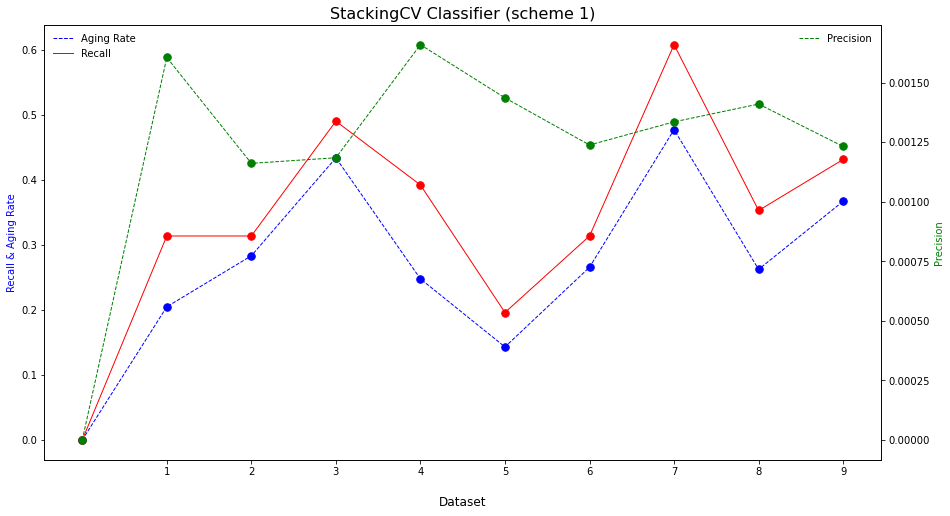

In [9]:
table_setC, coefC = runall_LR(10, train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (scheme 1)')

In [10]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,558.245552,156867.0,281.0,0.0,3.0,51.0,48595.0,0.000000,0.000000,0.000062,0.000000,0.000000
dataset 1,1.000000,2758.0,2758.0,16.0,9951.0,35.0,38647.0,0.001605,0.313725,0.204876,1.531296,0.291367
dataset 2,1.000000,3775.0,3775.0,16.0,13763.0,35.0,34835.0,0.001161,0.313725,0.283233,1.107659,0.233907
dataset 3,1.000000,3084.0,3084.0,25.0,21080.0,26.0,27518.0,0.001185,0.490196,0.433822,1.129948,0.370636
dataset 4,1.000000,2809.0,2809.0,20.0,12035.0,31.0,36563.0,0.001659,0.392157,0.247795,1.582583,0.372075
dataset 5,1.009339,2810.0,2784.0,10.0,6954.0,41.0,41644.0,0.001436,0.196078,0.143148,1.369762,0.169174
dataset 6,0.820198,2810.0,3426.0,16.0,12907.0,35.0,35691.0,0.001238,0.313725,0.265638,1.181029,0.244642
dataset 7,1.000000,2810.0,2810.0,31.0,23185.0,20.0,25413.0,0.001335,0.607843,0.477214,1.273732,0.499296
dataset 8,1.000000,2810.0,2810.0,18.0,12748.0,33.0,35850.0,0.001410,0.352941,0.262410,1.344997,0.300806
dataset 9,10.000000,2810.0,281.0,22.0,17836.0,29.0,30762.0,0.001232,0.431373,0.367078,1.175151,0.335219


### regressor

In [ ]:
pr_dict, table_setR, coefR = runall_RidgeR(10, train_firstR_x, test_firstR_x, train_firstR_y, test_firstR_y, 
                                           best_paramR, thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'StackingCV Regressor (scheme 1)')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
print(coefR)

### export

In [11]:
savedate = '20211207'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV_1_tree'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV_1_tree')